In [406]:
#imports
import os
import sys
import pandas as pd 
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools

from sqlalchemy import func, Integer, case, distinct, and_
from tabulate import tabulate  
from scipy.stats import chi2_contingency
from IPython.display import HTML, display, Markdown
from matplotlib import colormaps
from matplotlib.patches import Patch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
from sqlalchemy import func

if not os.path.exists("./DABI1.db"):
    !sh ../scripts/unzip.sh
    !python ../scripts/load_data_into_db.py


notebook_dir = os.getcwd()  
module_path = os.path.abspath(os.path.join(notebook_dir, '..'))  
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.db import get_engine, get_session
from custom_types.db_models import Order, Product, Einkaufskorb, Department, Aisle

engine = get_engine(path = "sqlite:///DABI1.db")
session = get_session(engine)

abbildung = 1

Verbindung erfolgreich


# 📊 Datenanalyse des Instacarts-Datensatzes
### *für die Marketing- und Dispositionsabteilung*

---
<!-- text-align weil im normalen Jupyter lab die Tabelle zentriert wird -->
<h1 style="text-align: center;">👥 Projektteam</h1>

| Name | Matrikelnummer |
|------|----------------|
| Benjamin | - |
| Vladimir | - |
| Jan-David Wiederstein | 88219 |

---


## 📝 **Inhaltsverzeichnis**
1. [EDA Marketing](#marketing)
2. [EDA Disposition](#disposition)
3. [Konkrete Fragen](#fragen)
4. [Handlungsempfehlungen](#handlungsempfehlungen)

---
# <h1 id="marketing">EDA Marketing</h1>

In [2]:
# insert Benjamins solution here

---
# <h1 id="disposition">EDA Disposition</h1>

## 📊 1. Allgemeine Analyse des Trinkgeldverhaltens

<div style="padding: 15px; border-radius: 5px; border-left: 5px solid #3498db; margin: 10px 0;">
    <strong>🎯 Zielsetzung:</strong>
    <p style="margin: 10px 0 0 0;">
        Untersuchung der generellen Verteilung der Trinkgeldvergabe über alle Bestellungen hinweg.
    </p>
</div>

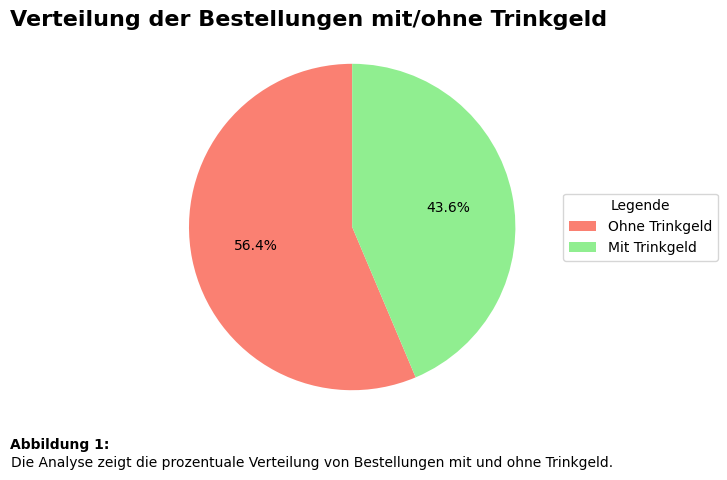

|    | tips   |   count |   percentage |
|---:|:-------|--------:|-------------:|
|  0 | False  |  942908 |      56.3596 |
|  1 | True   |  730113 |      43.6404 |

In [320]:
tip_counts = (
    session.query(
        Order.tips,               
        func.count(Order.order_id)  
    )
    .group_by(Order.tips)
    .all()
)

tip_counts_df = pd.DataFrame(tip_counts, columns=['tips', 'count'])
total_orders = tip_counts_df['count'].sum()
tip_counts_df['percentage'] = (tip_counts_df['count'] / total_orders) * 100
table_markdown = tabulate(tip_counts_df, headers='keys', tablefmt='pipe')

plt.figure(figsize=(6, 6))

labels = ['Ohne Trinkgeld', 'Mit Trinkgeld']
colors = ['salmon', 'lightgreen']
patches, texts, autotexts = plt.pie(tip_counts_df['count'],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)

plt.legend(patches, labels, title="Legende", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


fig = plt.gcf()  
fig.text(0.415, 0.875, 'Verteilung der Bestellungen mit/ohne Trinkgeld', 
         fontweight='bold', fontsize=16, ha='center')
description = 'Die Analyse zeigt die prozentuale Verteilung von Bestellungen mit und ohne Trinkgeld.'
fig.text(0, 0.17, f'Abbildung 1:', fontweight='bold', ha='center')
fig.text(0.42, 0.14, description, ha='center')

plt.subplots_adjust(bottom=0.2, right=0.85)  

plt.show()
display(Markdown(f"{table_markdown}"))

<div style="padding: 10px; border-radius: 5px; border-left: 5px solid #3498db;">
<b>📊 Interpretation:</b><br>
Es gibt im Allgemeinen etwas mehr Bestellungen ohne Trinkgeld als Bestellungen mit Trinkgeld.<br>
<br>
<b>📌 Nächster Schritt:</b><br>
Wir möchten nun herausfinden welche Ursachen es haben könnte, wieso es weniger Bestellungen ohne Trinkgeld gibt. Außerdem wollen wir herausfinden ob es möglicherweise Variablen gibt die im Zusammenhang mit der Trinkgeldvergabe stehen
</div>

## 📈 2. Produktspezifische Analyse

<div style="padding: 15px; border-radius: 5px; border-left: 5px solid #3498db; margin: 10px 0;">
    <strong>🎯 Zielsetzung:</strong>
    <p style="margin: 10px 0 0 0;">
        Analyse des Trinkgeldverhaltens in Bezug auf spezifische Produktkategorien und deren Einfluss auf das Kundenverhalten.
    </p>
</div>

In [321]:
# Query: Anzahl der Bestellungen mit und ohne Trinkgeld pro Abteilung
orders_by_department_with_tips = session.query(
    Department.department_name,
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips'),
    func.sum(case((Order.tips == False, 1), else_=0)).label('orders_without_tips')
).join(Product, Product.department_id == Department.department_id)\
 .join(Einkaufskorb, Einkaufskorb.product_id == Product.product_id)\
 .join(Order, Einkaufskorb.order_id == Order.order_id)\
 .group_by(Department.department_name).all()

departments = [department for department, _, _ in orders_by_department_with_tips]
orders_with_tips = [orders_with_tips for _, orders_with_tips, _ in orders_by_department_with_tips]
orders_without_tips = [orders_without_tips for _, _, orders_without_tips in orders_by_department_with_tips]


### 📊 Analyse des Trinkgeldverhaltens nach Produktabteilungen
<div style="padding: 10px; border-radius: 5px; border-left: 5px solid #3498db;">
    <div padding: 20px; border-radius: 8px; border-left: 5px solid #28a745; margin: 10px 0;">
        <strong style="margin-top: 0;">📈 Visualisierung</strong>
        <p style="margin-bottom: 15px; line-height: 1.6;">
            Der folgende Graph zeigt die Verteilung von Bestellungen mit und ohne Trinkgeld für verschiedene Produktabteilungen. 
            Die Abteilungen sind nach dem Verhältnis von Trinkgeld-Bestellungen zu Gesamtbestellungen sortiert.
        </p>
        <p style="margin-bottom: 20px; line-height: 1.6;">
            <strong>Wichtig:</strong> Eine Bestellung wird einer Produktabteilung zugeordnet, wenn sie mindestens ein Produkt 
            dieser Abteilung enthält. Dabei kann eine Bestellung mehreren Produktabteilungen zugeteilt werden.
        </p>
        <strong style="margin-top: 0;">🔍 Lesehinweise</strong>
        <ul style="list-style-type: none; padding-left: 0;">
            <li style="margin-bottom: 5px;">📊 <strong>Balken:</strong> Zeigen absolute Anzahl der Bestellungen</li>
            <li style="margin-bottom: 5px;">🟢 <strong>Grün:</strong> Bestellungen mit Trinkgeld</li>
            <li style="margin-bottom: 5px;">🔴 <strong>Rot:</strong> Bestellungen ohne Trinkgeld</li>
            <li style="margin-bottom: 5px;">📝 <strong>Verhältnis:</strong> Zahlen rechts zeigen Quotient (Trinkgeld/Gesamt)</li>
        </ul>
    </div>
</div>


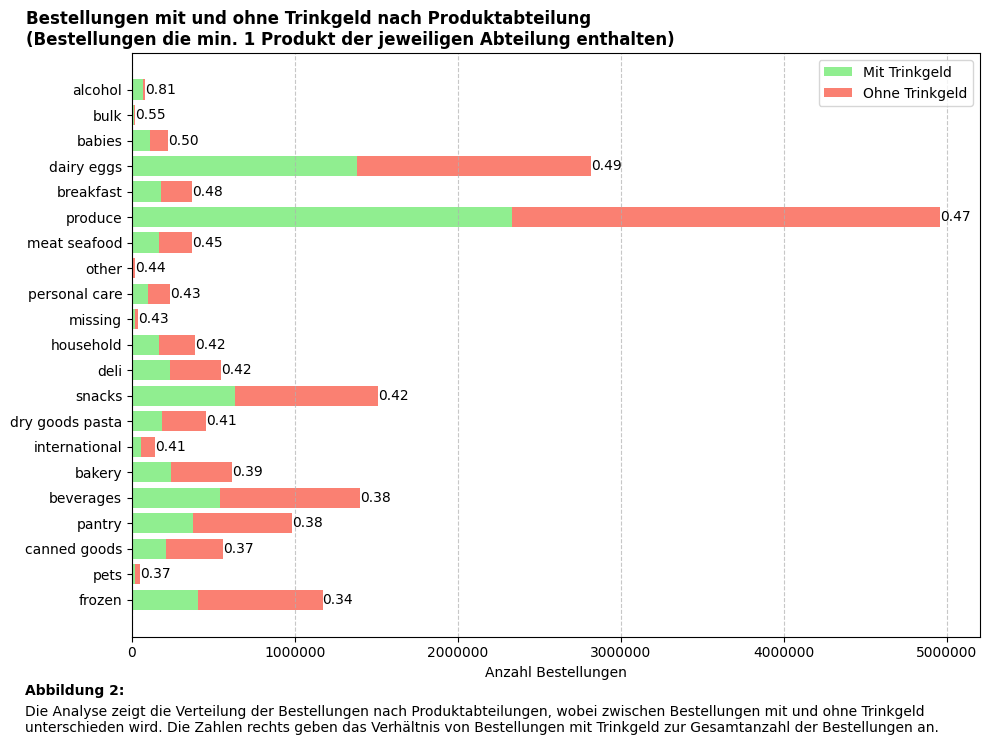

In [322]:
# plot code
# Positionen für die Balken (nun nach Quotienten sortiert)
ratios = [
    orders_with_tips[i] / (orders_with_tips[i] + orders_without_tips[i]) if (orders_with_tips[i] + orders_without_tips[i]) > 0 else 0
    for i in range(len(departments))
]

# Abteilungen nach dem Quotienten sortieren (Index des Quotienten als Sortierschlüssel)
sorted_indices = np.argsort(ratios)

# Abteilungen und Bestellungen nach der Sortierung anpassen
departments_sorted = [departments[i] for i in sorted_indices]
orders_with_tips_sorted = [orders_with_tips[i] for i in sorted_indices]
orders_without_tips_sorted = [orders_without_tips[i] for i in sorted_indices]
ratios_sorted = [ratios[i] for i in sorted_indices]

x = np.arange(len(departments_sorted))

fig, ax = plt.subplots(figsize=(10, 7))
plt.subplots_adjust(left=0.08)
bar_width = 0.5

ax.barh(x, orders_with_tips_sorted, color='lightgreen', label='Mit Trinkgeld')
ax.barh(x, orders_without_tips_sorted, left=orders_with_tips_sorted, color='salmon', label='Ohne Trinkgeld')

ax.set_xlabel('Anzahl Bestellungen')
ax.set_yticks(x)
ax.set_yticklabels(departments_sorted)
ax.set_title('Bestellungen mit und ohne Trinkgeld nach Produktabteilung\n(Bestellungen die min. 1 Produkt der jeweiligen Abteilung enthalten)', 
             loc='left', 
             weight='bold', 
             x=-0.125
             )

# Quotienten (Bestellungen mit Trinkgeld / Gesamtbestellungen) berechnen und anzeigen
for i, department in enumerate(departments_sorted):
    total_orders = orders_with_tips_sorted[i] + orders_without_tips_sorted[i]
    ratio = ratios_sorted[i]
    
    ax.text(
        orders_with_tips_sorted[i] + orders_without_tips_sorted[i] + 100,
        i,
        f'{ratio:.2f}',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

ax.legend(loc='upper right')
ax.ticklabel_format(style='plain', axis='x')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

title = 'Abbildung 2:'
description = 'Die Analyse zeigt die Verteilung der Bestellungen nach Produktabteilungen, wobei zwischen Bestellungen mit und ohne Trinkgeld unterschieden wird. Die Zahlen rechts geben das Verhältnis von Bestellungen mit Trinkgeld zur Gesamtanzahl der Bestellungen an.'

fig.text(0.03, 0, title, fontweight='bold')
fig.text(0.03, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

### 📊 Chi-Quadrat-Test: Analyse der Verteilungsunterschiede

<div style="padding: 15px; border-radius: 5px; border-left: 5px solid #3498db; margin: 10px 0;">
    <strong>🎯 Zielsetzung:</strong>
    <p style="margin: 10px 0;">
        Statistische Überprüfung, ob die beobachteten Unterschiede in der Verteilung von Bestellungen mit und ohne Trinkgeld 
        signifikant sind.
    </p>
    <strong>📌 Hypothesen:</strong>
    <ul>
        <li>H₀: Keine Abhängigkeit zwischen Produktabteilung und Trinkgeldverhalten</li>
        <li>H₁: Signifikanter Zusammenhang zwischen Produktabteilung und Trinkgeldverhalten</li>
    </ul>
    <strong>⚙️ Testparameter:</strong>
    <ul>
        <li>Signifikanzniveau: α = 0.05</li>
        <li>Statistische Methode: Chi-Quadrat-Unabhängigkeitstest</li>
    </ul>
</div>

In [240]:
# chi² code
contingency_table = pd.DataFrame({
    'Mit_Trinkgeld': orders_with_tips,
    'Ohne_Trinkgeld': orders_without_tips
}, index=departments)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Testergebnisse in Tabelle formatieren
test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p_value}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))

contingency_table['Gesamt'] = contingency_table['Mit_Trinkgeld'] + contingency_table['Ohne_Trinkgeld']
contingency_table['Anteil_mit_Trinkgeld'] = (contingency_table['Mit_Trinkgeld'] / contingency_table['Gesamt']).round(3)

print("\nKontingenztabelle:")
print(tabulate(contingency_table, headers='keys', tablefmt="fancy_grid", 
              numalign="right", floatfmt=".3f"))


Chi-Quadrat Testergebnisse:
╒═══════════════════════╤═════════╕
│ Metrik                │    Wert │
╞═══════════════════════╪═════════╡
│ Chi-Quadrat Statistik │ 30670.2 │
├───────────────────────┼─────────┤
│ p-Wert                │       0 │
├───────────────────────┼─────────┤
│ Freiheitsgrade        │      20 │
╘═══════════════════════╧═════════╛

Interpretation:
╒══════════════════╤═══════════════════════════════════════════════╕
│                  │                                               │
╞══════════════════╪═══════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang        │
├──────────────────┼───────────────────────────────────────────────┤
│ Begründung       │ p-Wert (0.0) < Signifikanzniveau (0.05)       │
├──────────────────┼───────────────────────────────────────────────┤
│ Schlussfolgerung │ Department und Trinkgeldvergabe sind abhängig │
╘══════════════════╧═══════════════════════════════════════════════╛

Kontinge

### 🔥 Visualisierung der Chi-Quadrat-Residuen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">📊 Analyse der standardisierten Residuen</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Um die Ergebnisse des Chi-Quadrat-Tests detaillierter zu untersuchen, visualisieren wir die standardisierten 
        Residuen in Form einer Heatmap. Diese zeigt die Abweichungen zwischen beobachteten und erwarteten Häufigkeiten.
    </p>
    <div style="padding: 15px;">
        <strong>📐 Berechnung der standardisierten Residuen:</strong>
        <p style="margin: 10px 0; font-family: 'Courier New', monospace;">
            Residuum = (O - E) / √[E * (1 - Rᵢ/N) * (1 - Cⱼ/N)]
        </p>
        <p style="margin: 5px 0; font-size: 0.9em;">
            wobei:<br>
            O = beobachtete Häufigkeit<br>
            E = erwartete Häufigkeit<br>
            Rᵢ = Zeilensumme<br>
            Cⱼ = Spaltensumme<br>
            N = Gesamtsumme
        </p>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>🎯 Interpretation der Farben:</strong>
        <ul style="margin: 10px 0;">
            <li><strong style="color: #ef476f;">Rot (negative Werte):</strong> Weniger Fälle als statistisch erwartet</li>
            <li><strong style="color: #fff;">Weiß (nahe 0):</strong> Etwa so viele Fälle wie erwartet</li>
            <li><strong style="color: #0077b6;">Blau (positive Werte):</strong> Mehr Fälle als statistisch erwartet</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>📝 Signifikanzgrenzen:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Werte < -2 oder > 2: statistisch signifikante Abweichung (p < 0.05)</li>
            <li>Werte < -2.58 oder > 2.58: hochsignifikante Abweichung (p < 0.01)</li>
        </ul>
    </div>
</div>

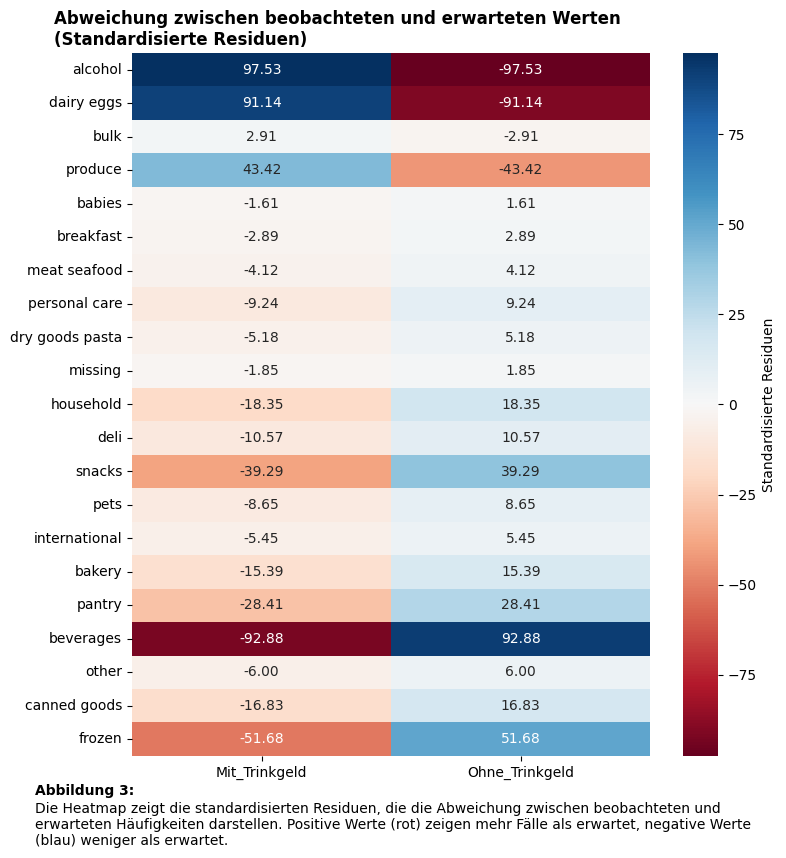


Interpretation der standardisierten Residuen:
╒═════════════════════════════╤═════════════════════════════════════╕
│ Werte                       │ Bedeutung                           │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Stark negative Werte (< -2) │ Deutlich weniger Fälle als erwartet │
├─────────────────────────────┼─────────────────────────────────────┤
│ Werte nahe 0 (-2 bis 2)     │ Etwa so viele Fälle wie erwartet    │
├─────────────────────────────┼─────────────────────────────────────┤
│ Stark positive Werte (> 2)  │ Deutlich mehr Fälle als erwartet    │
╘═════════════════════════════╧═════════════════════════════════════╛


In [ ]:
# plot code

observed = contingency_table[['Mit_Trinkgeld', 'Ohne_Trinkgeld']].values

_, _, _, expected = chi2_contingency(observed)

# Korrigierte standardisierte Residuen berechnen
# Formel: (O - E) / sqrt(E * (1 - row_total/grand_total) * (1 - col_total/grand_total))
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.sum()

corrected_residuals = np.zeros_like(observed, dtype=float)
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        E = expected[i, j]
        O = observed[i, j]
        correction = np.sqrt((1 - row_totals[i]/grand_total) * 
                           (1 - col_totals[j]/grand_total))
        corrected_residuals[i, j] = (O - E) / (np.sqrt(E) * correction)

residuals_df = pd.DataFrame(
    corrected_residuals,
    index=departments,
    columns=['Mit_Trinkgeld', 'Ohne_Trinkgeld']
)

residuals_df = residuals_df.reindex(departments_sorted[::-1])

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(residuals_df, 
            annot=True,
            cmap='RdBu',
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardisierte Residuen'},
            ax=ax)

ax.set_title('Abweichung zwischen beobachteten und erwarteten Werten\n(Standardisierte Residuen)', 
             loc='left',
             weight='bold',
             x=-0.15)

description = 'Die Heatmap zeigt die standardisierten Residuen, die die Abweichung zwischen beobachteten und erwarteten Häufigkeiten darstellen. Positive Werte (rot) zeigen mehr Fälle als erwartet, negative Werte (blau) weniger als erwartet.'
fig.text(0.05, 0, 'Abbildung 3:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

print("\nInterpretation der standardisierten Residuen:")
interpretation_table = [
    ["Stark negative Werte (< -2)", "Deutlich weniger Fälle als erwartet"],
    ["Werte nahe 0 (-2 bis 2)", "Etwa so viele Fälle wie erwartet"],
    ["Stark positive Werte (> 2)", "Deutlich mehr Fälle als erwartet"]
]
print(tabulate(interpretation_table, headers=["Werte", "Bedeutung"], 
              tablefmt="fancy_grid"))

In [323]:
# Query: Bestellungen mit und ohne Trinkgeld pro Abteilung, aber nur für Bestellungen die Produkte aus genau einer Abteilung enthalten
orders_with_single_department = session.query(
    Order.order_id,
    func.count(distinct(Product.department_id)).label('dept_count')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id)\
 .join(Product, Product.product_id == Einkaufskorb.product_id)\
 .group_by(Order.order_id)\
 .having(func.count(distinct(Product.department_id)) == 1)\
 .subquery()

orders_by_department_with_tips = session.query(
    Department.department_name,
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips'),
    func.sum(case((Order.tips == False, 1), else_=0)).label('orders_without_tips')
).join(Product, Product.department_id == Department.department_id)\
 .join(Einkaufskorb, Einkaufskorb.product_id == Product.product_id)\
 .join(Order, Einkaufskorb.order_id == Order.order_id)\
 .join(orders_with_single_department, orders_with_single_department.c.order_id == Order.order_id)\
 .group_by(Department.department_name).all()

departments = [department for department, _, _ in orders_by_department_with_tips]
orders_with_tips = [orders_with_tips for _, orders_with_tips, _ in orders_by_department_with_tips]
orders_without_tips = [orders_without_tips for _, _, orders_without_tips in orders_by_department_with_tips]

### 📊 Analyse von Single-Department-Bestellungen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Fokussierte Departmentanalyse</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Analyse aller Bestellungen betrachten wir nun spezifisch die Bestellungen, die ausschließlich Produkte 
        aus einer einzelnen Produktabteilung enthalten. Dies ermöglicht eine präzisere Untersuchung des 
        Trinkgeldverhaltens ohne Überschneidungseffekte.
    </p>
    <div style="margin-top: 15px;">
        <strong>📌 Besonderheiten der Analyse:</strong>
        <ul>
            <li>Nur Bestellungen mit Produkten aus genau einer Abteilung</li>
            <li>Keine Überschneidungen zwischen Abteilungen</li>
            <li>Reinere Darstellung des abteilungsspezifischen Trinkgeldverhaltens</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>📊 Darstellung:</strong>
        <ul style="">
            <li>Horizontale Balken zeigen absolute Anzahl der Bestellungen</li>
            <li>Grün: Bestellungen mit Trinkgeld</li>
            <li>Rot: Bestellungen ohne Trinkgeld</li>
            <li>Zahlen rechts: Verhältnis (Trinkgeld/Gesamt)</li>
        </ul>
    </div>
</div>

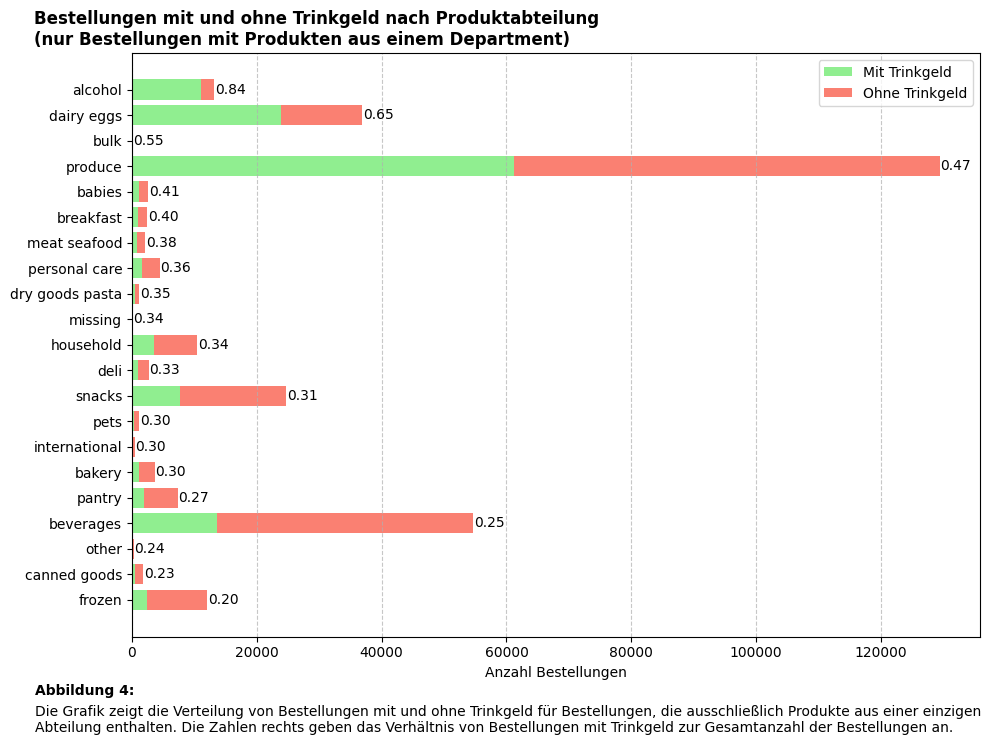

In [324]:
# plot code
# Quotient berechnen
ratios = [
    orders_with_tips[i] / (orders_with_tips[i] + orders_without_tips[i]) if (orders_with_tips[i] + orders_without_tips[i]) > 0 else 0
    for i in range(len(departments))
]

sorted_indices = np.argsort(ratios)

departments_sorted = [departments[i] for i in sorted_indices]
orders_with_tips_sorted = [orders_with_tips[i] for i in sorted_indices]
orders_without_tips_sorted = [orders_without_tips[i] for i in sorted_indices]
ratios_sorted = [ratios[i] for i in sorted_indices]

x = np.arange(len(departments_sorted))
fig, ax = plt.subplots(figsize=(10, 7))
plt.subplots_adjust(left=0.08)  # Anpassung für einheitliche Einrückung
bar_width = 0.5

ax.barh(x, orders_with_tips_sorted, color='lightgreen', label='Mit Trinkgeld')
ax.barh(x, orders_without_tips_sorted, left=orders_with_tips_sorted, color='salmon', label='Ohne Trinkgeld')

ax.set_xlabel('Anzahl Bestellungen')
ax.set_yticks(x)
ax.set_yticklabels(departments_sorted)
ax.set_title('Bestellungen mit und ohne Trinkgeld nach Produktabteilung\n(nur Bestellungen mit Produkten aus einem Department)', 
             loc='left', 
             weight='bold',
             x=-0.115)

for i, department in enumerate(departments_sorted):
    total_orders = orders_with_tips_sorted[i] + orders_without_tips_sorted[i]
    ratio = ratios_sorted[i]
    
    ax.text(
        orders_with_tips_sorted[i] + orders_without_tips_sorted[i] + 100,
        i,
        f'{ratio:.2f}',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

ax.legend(loc='upper right')
ax.ticklabel_format(style='plain', axis='x')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

description = 'Die Grafik zeigt die Verteilung von Bestellungen mit und ohne Trinkgeld für Bestellungen, die ausschließlich Produkte aus einer einzigen Abteilung enthalten. Die Zahlen rechts geben das Verhältnis von Bestellungen mit Trinkgeld zur Gesamtanzahl der Bestellungen an.'
fig.text(0.04, 0, 'Abbildung 4:', weight='bold', ha='left')
fig.text(0.04, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

### 🔍 Zentrale Erkenntnisse der Single-Department-Analyse

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">⚡ Überraschungen</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0">
        <strong>📈 Auffälliger Zuwachs</strong>
        <ul style="margin: 5px 0;">
            <li>Dairy Eggs</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0">
        <strong>📉 Auffälliger Rückgang</strong>
        <ul style="margin: 5px 0;">
            <li>Frozen</li>
            <li>Beverages</li>
        </ul>
    </div>
</div>


In [11]:
# chi² code
contingency_table = pd.DataFrame({
    'Mit_Trinkgeld': orders_with_tips,
    'Ohne_Trinkgeld': orders_without_tips
}, index=departments)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p_value}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))

contingency_table['Gesamt'] = contingency_table['Mit_Trinkgeld'] + contingency_table['Ohne_Trinkgeld']
contingency_table['Anteil_mit_Trinkgeld'] = (contingency_table['Mit_Trinkgeld'] / contingency_table['Gesamt']).round(3)

print("\nKontingenztabelle:")
print(tabulate(contingency_table, headers='keys', tablefmt="fancy_grid", 
              numalign="right", floatfmt=".3f"))


Chi-Quadrat Testergebnisse:
╒═══════════════════════╤═════════╕
│ Metrik                │    Wert │
╞═══════════════════════╪═════════╡
│ Chi-Quadrat Statistik │ 30670.2 │
├───────────────────────┼─────────┤
│ p-Wert                │       0 │
├───────────────────────┼─────────┤
│ Freiheitsgrade        │      20 │
╘═══════════════════════╧═════════╛

Interpretation:
╒══════════════════╤═══════════════════════════════════════════════╕
│                  │                                               │
╞══════════════════╪═══════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang        │
├──────────────────┼───────────────────────────────────────────────┤
│ Begründung       │ p-Wert (0.0) < Signifikanzniveau (0.05)       │
├──────────────────┼───────────────────────────────────────────────┤
│ Schlussfolgerung │ Department und Trinkgeldvergabe sind abhängig │
╘══════════════════╧═══════════════════════════════════════════════╛

Kontinge

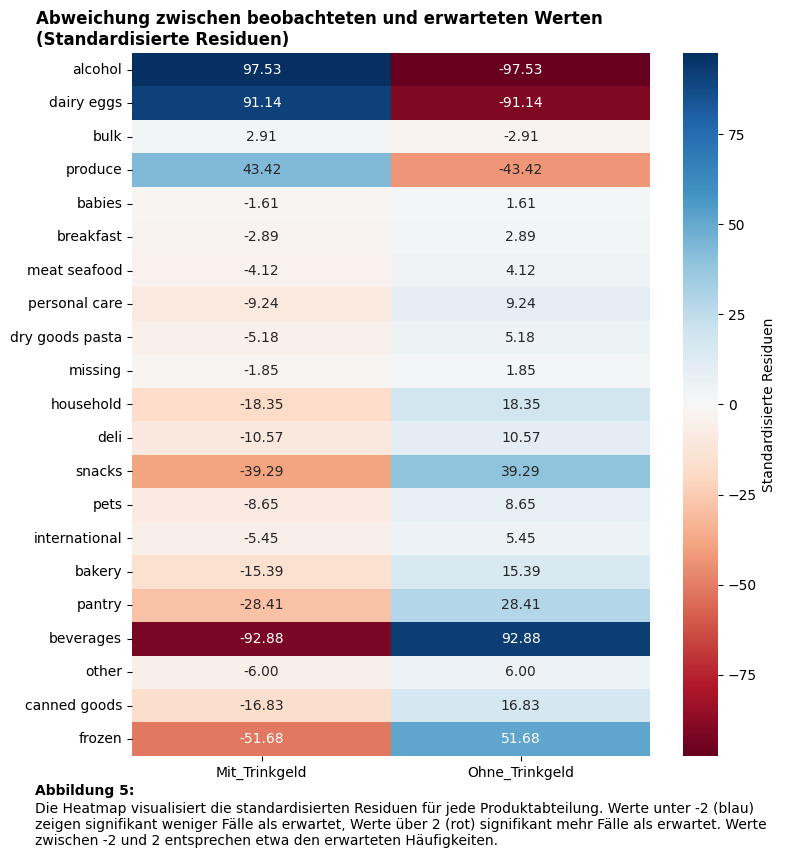


Interpretation der standardisierten Residuen:
╒═════════════════════════════╤═════════════════════════════════════╕
│ Werte                       │ Bedeutung                           │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Stark negative Werte (< -2) │ Deutlich weniger Fälle als erwartet │
├─────────────────────────────┼─────────────────────────────────────┤
│ Werte nahe 0 (-2 bis 2)     │ Etwa so viele Fälle wie erwartet    │
├─────────────────────────────┼─────────────────────────────────────┤
│ Stark positive Werte (> 2)  │ Deutlich mehr Fälle als erwartet    │
╘═════════════════════════════╧═════════════════════════════════════╛


In [26]:
# code plot
observed = contingency_table[['Mit_Trinkgeld', 'Ohne_Trinkgeld']].values

_, _, _, expected = chi2_contingency(observed)

# Korrigierte standardisierte Residuen berechnen
# Formel: (O - E) / sqrt(E * (1 - row_total/grand_total) * (1 - col_total/grand_total))
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.sum()

corrected_residuals = np.zeros_like(observed, dtype=float)
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        E = expected[i, j]
        O = observed[i, j]
        correction = np.sqrt((1 - row_totals[i]/grand_total) * 
                           (1 - col_totals[j]/grand_total))
        corrected_residuals[i, j] = (O - E) / (np.sqrt(E) * correction)

residuals_df = pd.DataFrame(
    corrected_residuals,
    index=departments,
    columns=['Mit_Trinkgeld', 'Ohne_Trinkgeld']
)

residuals_df = residuals_df.reindex(departments_sorted[::-1])

fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.08)

sns.heatmap(residuals_df, 
            annot=True,
            cmap='RdBu',
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardisierte Residuen'},
            ax=ax)

ax.set_title('Abweichung zwischen beobachteten und erwarteten Werten\n(Standardisierte Residuen)', 
             loc='left',
             weight='bold',
             x=-0.185)

description = 'Die Heatmap visualisiert die standardisierten Residuen für jede Produktabteilung. Werte unter -2 (blau) zeigen signifikant weniger Fälle als erwartet, Werte über 2 (rot) signifikant mehr Fälle als erwartet. Werte zwischen -2 und 2 entsprechen etwa den erwarteten Häufigkeiten.'
fig.text(0.05, 0, 'Abbildung 5:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

print("\nInterpretation der standardisierten Residuen:")
interpretation_table = [
    ["Stark negative Werte (< -2)", "Deutlich weniger Fälle als erwartet"],
    ["Werte nahe 0 (-2 bis 2)", "Etwa so viele Fälle wie erwartet"],
    ["Stark positive Werte (> 2)", "Deutlich mehr Fälle als erwartet"]
]
print(tabulate(interpretation_table, headers=["Werte", "Bedeutung"], 
              tablefmt="fancy_grid"))

In [328]:
# Anzahl der Gesamtbestellungen und Bestellungen mit Trinkgeld pro Gang (Aisle)
aisles_stats = session.query(
    Aisle.aisle_name,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Product, Product.aisle_id == Aisle.aisle_id) \
 .join(Einkaufskorb, Einkaufskorb.product_id == Product.product_id) \
 .join(Order, Einkaufskorb.order_id == Order.order_id) \
 .group_by(Aisle.aisle_name) \
 .all()


In [329]:
# utils code
aisles_df = pd.DataFrame(aisles_stats, columns=['aisle_name', 'total_orders', 'orders_with_tips'])
aisles_df['orders_without_tips'] = aisles_df['total_orders'] - aisles_df['orders_with_tips']
aisles_df['tip_ratio'] = aisles_df['orders_with_tips'] / aisles_df['total_orders']

aisles_top_10 = aisles_df.nlargest(10, 'tip_ratio').iloc[::-1]  # Top 10 nach Quote, Reihenfolge umkehren
aisles_flop_10 = aisles_df.nsmallest(10, 'tip_ratio')

def plot_aisles(aisles_data, title, ax):
    x = np.arange(len(aisles_data))

    ax.barh(x, aisles_data['orders_with_tips'], color='lightgreen', label='Mit Trinkgeld')
    ax.barh(x, aisles_data['orders_without_tips'], left=aisles_data['orders_with_tips'], color='salmon', label='Ohne Trinkgeld')

    ax.set_xlabel('Anzahl Bestellungen')
    ax.set_yticks(x)
    ax.set_yticklabels(aisles_data['aisle_name'])
    ax.set_title(title, loc='left', weight='bold')

    for tick in ax.get_xticks():
        ax.axvline(x=tick, color='grey', linestyle='--', linewidth=0.5)

    for i, aisle in enumerate(aisles_data['aisle_name']):
        ratio = aisles_data['tip_ratio'].iloc[i]
        total_orders = aisles_data['total_orders'].iloc[i]
        ax.text(
            aisles_data['orders_with_tips'].iloc[i] + aisles_data['orders_without_tips'].iloc[i] + 130,  
            i,  
            f'{ratio:.2f}',  
            va='center',  
            ha='left',  
            fontsize=10,
            color='black'
        )

    ax.legend(loc='upper right')


### 📊 Detailanalyse der Produktkategorien (Aisles)

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Top & Flop Analyse</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Untersuchung der übergeordneten Departments zoomen wir nun tiefer in die einzelnen Produktkategorien 
        (Aisles) hinein. Diese detailliertere Betrachtung ermöglicht es uns, spezifischere Muster im Trinkgeldverhalten 
        zu identifizieren.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Visualisierungsdetails:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Top 10 Aisles mit höchstem Trinkgeld-Verhältnis</li>
            <li><strong>Rechter Plot:</strong> Flop 10 Aisles mit niedrigstem Trinkgeld-Verhältnis</li>
            <li>Grüne Balken: Bestellungen mit Trinkgeld</li>
            <li>Rote Balken: Bestellungen ohne Trinkgeld</li>
            <li>Zahlen rechts: Verhältnis (Trinkgeld/Gesamt)</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Analyseziel:</strong>
        <p style="margin: 10px 0;">
            Identifikation von spezifischen Produktkategorien, die besonders stark mit dem Trinkgeldverhalten 
            korrelieren, um gezieltere Erkenntnisse für Marketing- und Service-Strategien zu gewinnen.
        </p>
    </div>
</div>

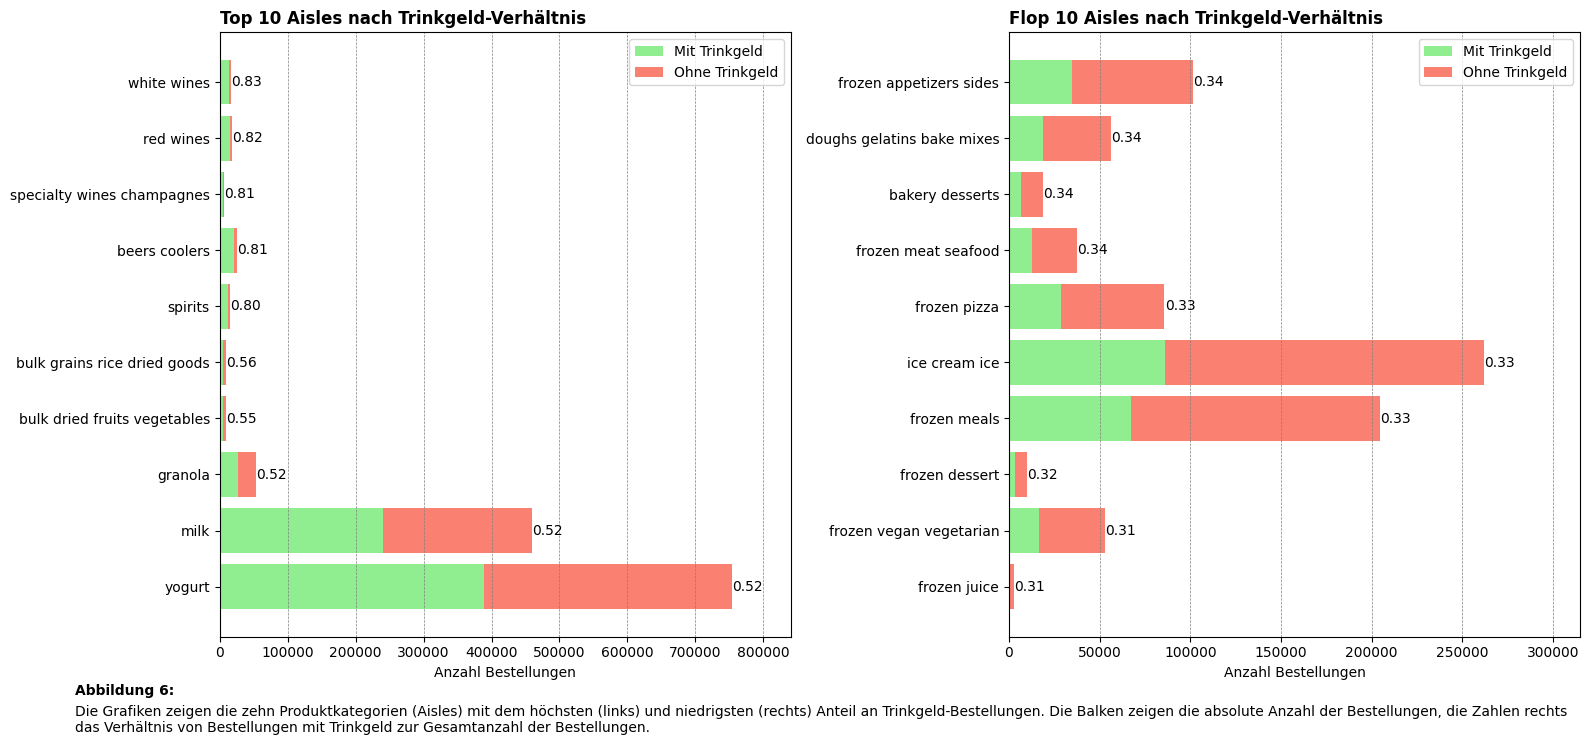

In [330]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
plt.subplots_adjust(left=0.08)

plot_aisles(aisles_top_10, 'Top 10 Aisles nach Trinkgeld-Verhältnis', ax1)

plot_aisles(aisles_flop_10, 'Flop 10 Aisles nach Trinkgeld-Verhältnis', ax2)

description = 'Die Grafiken zeigen die zehn Produktkategorien (Aisles) mit dem höchsten (links) und niedrigsten (rechts) Anteil an Trinkgeld-Bestellungen. Die Balken zeigen die absolute Anzahl der Bestellungen, die Zahlen rechts das Verhältnis von Bestellungen mit Trinkgeld zur Gesamtanzahl der Bestellungen.'
fig.text(0.05, 0, 'Abbildung 6:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()


<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Bestätigung übergeordneter Muster</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>🍷 Alkoholische Produkte in den Top 10</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die detaillierte Analyse der Aisles bestätigt den bereits auf Department-Ebene beobachteten Trend: 
            Alkoholische Produkte sind überproportional häufig in Bestellungen mit Trinkgeld vertreten. Dies zeigt sich durch:
        </p>
        <ul style="margin: 5px 0;">
            <li>Mehrere alkoholbezogene Kategorien in den Top 10</li>
            <li>Konsistenz mit der hohen Trinkgeldquote des Alcohol-Departments</li>
            <li>Möglicherweise höhere Serviceerwartung bei diesen Produkten</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>❄️ Tiefkühlprodukte in den Flop 10</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Auch am unteren Ende der Skala bestätigen sich die Department-Level-Erkenntnisse:
            Tiefkühlprodukte weisen durchgängig niedrigere Trinkgeldquoten auf. Dies spiegelt sich wider in:
        </p>
        <ul style="margin: 5px 0;">
            <li>Mehreren Tiefkühl-Kategorien unter den Flop 10</li>
            <li>Übereinstimmung mit der niedrigen Quote des Frozen-Departments</li>
            <li>Konsistentes Muster über verschiedene Tiefkühl-Produktkategorien hinweg</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>📊 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Aisle-Level-Analyse bestätigt und verfeinert die Erkenntnisse der Department-Analyse. 
            Dies unterstreicht die Robustheit der beobachteten Muster im Trinkgeldverhalten und 
            ermöglicht eine noch gezieltere Ansprache verschiedener Produktsegmente.
        </p>
    </div>
</div>

In [326]:
# Statistik über Produkte die mindestens 500 mal bestellt wurden: Gesamtbestellungen und Bestellungen mit Trinkgeld
products_stats = session.query(
    Product.product_name,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.product_id == Product.product_id) \
 .join(Order, Einkaufskorb.order_id == Order.order_id) \
 .group_by(Product.product_name) \
 .having(func.count(Order.order_id) >= 500).all()

products_df = pd.DataFrame(products_stats, columns=['product_name', 'total_orders', 'orders_with_tips'])
products_df['orders_without_tips'] = products_df['total_orders'] - products_df['orders_with_tips']
products_df['tip_ratio'] = products_df['orders_with_tips'] / products_df['total_orders']

products_top_10 = products_df.nlargest(10, 'tip_ratio').iloc[::-1]  # Top 10 nach Quote, Reihenfolge umkehren
products_flop_10 = products_df.nsmallest(10, 'tip_ratio')

def plot_products(products_data, title, ax):
    x = np.arange(len(products_data))

    ax.barh(x, products_data['orders_with_tips'], color='lightgreen', label='Mit Trinkgeld')
    ax.barh(x, products_data['orders_without_tips'], left=products_data['orders_with_tips'], color='salmon', label='Ohne Trinkgeld')

    ax.set_xlabel('Anzahl Bestellungen')
    ax.set_yticks(x)
    ax.set_yticklabels(products_data['product_name'])
    ax.set_title(title, loc='left', weight='bold')

    for tick in ax.get_xticks():
        ax.axvline(x=tick, color='grey', linestyle='--', linewidth=0.5)

    for i, product in enumerate(products_data['product_name']):
        ratio = products_data['tip_ratio'].iloc[i]
        total_orders = products_data['total_orders'].iloc[i]
        ax.text(
            products_data['orders_with_tips'].iloc[i] + products_data['orders_without_tips'].iloc[i] + 10, 
            i,  
            f'{ratio:.2f}',  
            va='center',  
            ha='left',  
            fontsize=10,
            color='black'
        )

    ax.legend(loc='upper right')


### 📊 Analyse auf Produktebene

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Detailanalyse einzelner Produkte</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Analyse der Departments und Aisles gehen wir nun auf die granularste Ebene: 
        die einzelnen Produkte. Diese Mikroanalyse ermöglicht es uns, sehr spezifische Muster 
        im Trinkgeldverhalten zu identifizieren.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Visualisierungsaufbau:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Die 10 Produkte mit der höchsten Trinkgeldquote</li>
            <li><strong>Rechter Plot:</strong> Die 10 Produkte mit der niedrigsten Trinkgeldquote</li>
            <li>Absolute Anzahl der Bestellungen (Balkenlänge)</li>
            <li>Verhältnis Trinkgeld/Gesamt (Zahlen rechts)</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Analyseziele:</strong>
        <ul style="margin: 10px 0;">
            <li>Identifikation von Produkten mit außergewöhnlichem Trinkgeldverhalten</li>
            <li>Verständnis produktspezifischer Kundenentscheidungen</li>
            <li>Ableitung von Handlungsempfehlungen auf Produktebene</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>💡 Besonderheit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Diese Analyse auf Produktebene ermöglicht die präziseste Sicht auf das Trinkgeldverhalten 
            und kann wichtige Einblicke für Produktplatzierung, Marketing und Serviceoptimierung liefern.
        </p>
    </div>
</div>

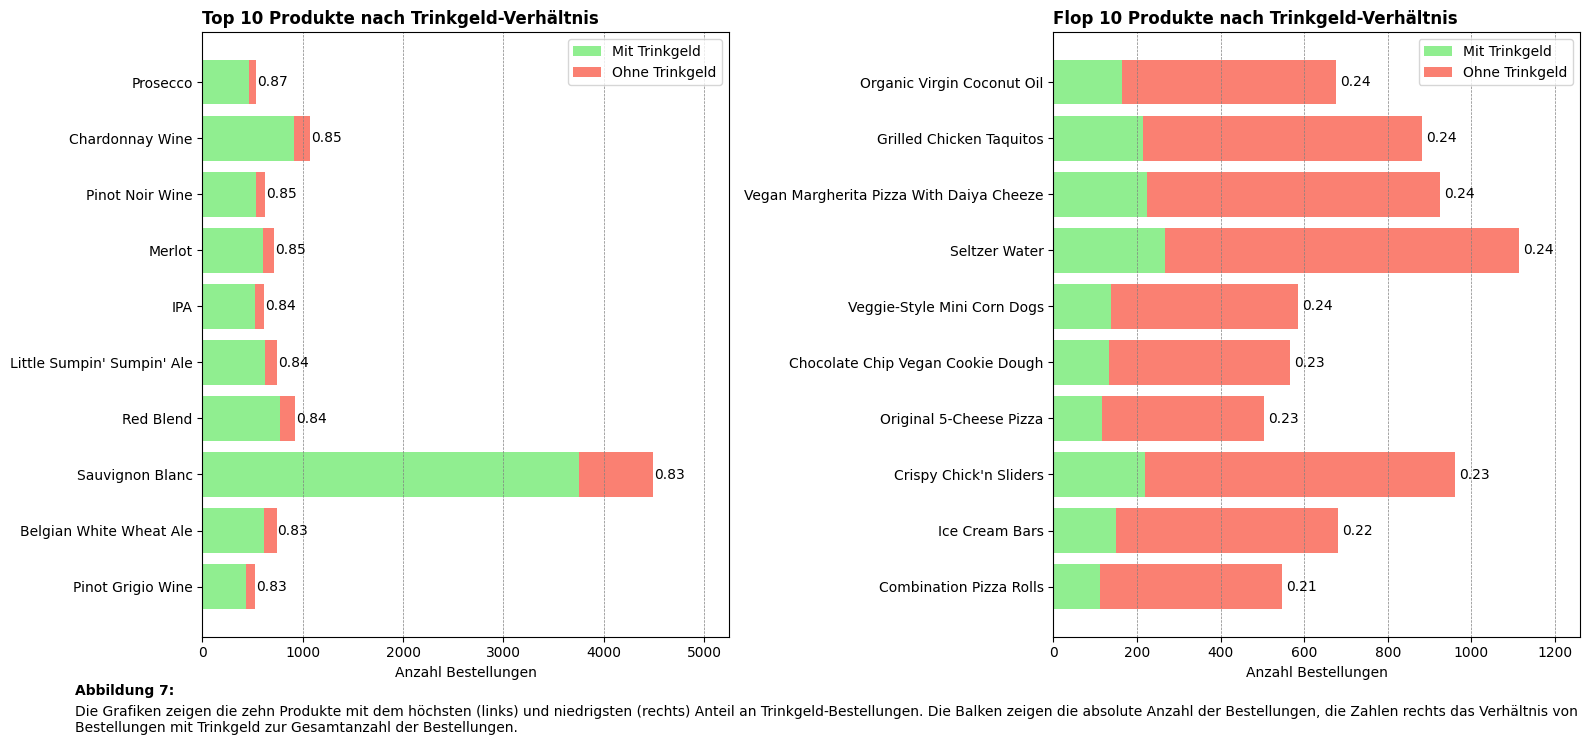

In [332]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
plt.subplots_adjust(left=0.08)

plot_products(products_top_10, 'Top 10 Produkte nach Trinkgeld-Verhältnis', ax1)

plot_products(products_flop_10, 'Flop 10 Produkte nach Trinkgeld-Verhältnis', ax2)

description = 'Die Grafiken zeigen die zehn Produkte mit dem höchsten (links) und niedrigsten (rechts) Anteil an Trinkgeld-Bestellungen. Die Balken zeigen die absolute Anzahl der Bestellungen, die Zahlen rechts das Verhältnis von Bestellungen mit Trinkgeld zur Gesamtanzahl der Bestellungen.'
fig.text(0.05, 0, 'Abbildung 7:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()


### 💡 Erkenntnisse der Produktanalyse

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Konsistente Muster über alle Analyseebenen</h4> 
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>🍷 Top 10 Produkte: Dominanz alkoholischer Getränke</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Analyse auf Produktebene bestätigt eindrucksvoll die bereits beobachteten Trends:
        </p>
        <ul style="margin: 5px 0;">
            <li>Starke Präsenz alkoholischer Getränke in den Top 10</li>
            <li>Konsistenz mit den Ergebnissen der Aisle-Analyse</li>
            <li>Bestätigung des Department-Level-Trends für alkoholische Produkte</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>❄️ Flop 10 Produkte: Tiefkühlprodukte dominieren</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Auch am unteren Ende der Skala setzen sich die bereits erkannten Muster fort:
        </p>
        <ul style="margin: 5px 0;">
            <li>Häufiges Auftreten von Tiefkühlprodukten unter den Flop 10</li>
            <li>Spiegelung der Erkenntnisse aus der Aisle-Analyse</li>
            <li>Weitere Bestätigung der niedrigen Trinkgeldquote im Frozen-Department</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>🎯 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Analyse auf Produktebene verstärkt die Erkenntnisse der vorherigen Untersuchungen und zeigt 
            eine bemerkenswerte Konsistenz über alle Analyseebenen hinweg - von Department über Aisles bis hin 
            zu einzelnen Produkten. Diese durchgängigen Muster unterstreichen die Robustheit unserer Erkenntnisse 
            zum Trinkgeldverhalten.
        </p>
    </div>
</div>

### 🕒 Temporale Analyse des Trinkgeldverhaltens nach Produktkategorien Alkohol und Frozen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Zeitliche Muster auf Stunden- und Tagesebene</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Identifikation der Produktkategorien mit besonders hohen (Alcohol) und niedrigen (Frozen) 
        Trinkgeldquoten, untersuchen wir nun deren zeitliche Dimension. Diese mehrstufige temporale Analyse 
        betrachtet sowohl Tages- als auch Stundenverläufe, um ein umfassendes Bild der zeitlichen Dynamik 
        zu erhalten.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>⏰ Zeitliche Dimensionen:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Stundenanalyse:</strong> Verlauf über 24 Stunden (0-23 Uhr)</li>
            <li><strong>Tagesanalyse:</strong> Verteilung über die Wochentage</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Analysefokus:</strong>
        <ul style="margin: 10px 0;">
            <li>Vergleich von absoluten Bestellzahlen und Trinkgeldquoten</li>
            <li>Separate Betrachtung der Extremkategorien:
                <ul>
                    <li>🍷 Alcohol (höchste Trinkgeldquote)</li>
                    <li>❄️ Frozen (niedrigste Trinkgeldquote)</li>
                </ul>
            </li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Erkenntnisziele:</strong>
        <ul style="margin: 10px 0;">
            <li>Identifikation von Tageszeit- und Wochentagsmustern</li>
            <li>Verständnis kategorienspezifischer Unterschiede im Zeitverlauf</li>
            <li>Erkennung von Stoßzeiten und ruhigen Perioden</li>
            <li>Ableitung von zeit- und kategorieabhängigen Handlungsempfehlungen</li>
        </ul>
    </div>
</div>


<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Alkoholbestellungen im Tagesverlauf</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Identifikation von Alkoholprodukten als Kategorie mit der höchsten Trinkgeldquote 
        untersuchen wir nun das zeitliche Muster dieser Bestellungen. Diese Analyse soll Aufschluss 
        darüber geben, ob und wie sich das Trinkgeldverhalten bei Alkoholbestellungen im Tagesverlauf verändert.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Visualisierungsdetails:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Absolute Zahlen der Bestellungen nach Stunden</li>
            <li><strong>Rechter Plot:</strong> Verlauf der Trinkgeldquote über den Tag</li>
            <li>24-Stunden-Analyse (0-23 Uhr)</li>
            <li>Berücksichtigung aller Bestellungen mit alkoholischen Produkten</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Analyseziele:</strong>
        <ul style="margin: 10px 0;">
            <li>Identifikation von Stoßzeiten für Alkoholbestellungen</li>
            <li>Erkennung von Mustern im Trinkgeldverhalten</li>
            <li>Verständnis des zeitlichen Einflusses auf das Kundenverhalten</li>
            <li>Ableitung möglicher operativer Empfehlungen</li>
        </ul>
    </div>
</div>

In [44]:
# Bestellungen von alkoholischen Produkten nach Tageszeit: Gesamtbestellungen und Bestellungen mit Trinkgeld pro Stunde
alcohol_orders_stats = session.query(
    Order.hour_of_day,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%alcohol%')) \
 .group_by(Order.hour_of_day) \
 .all()


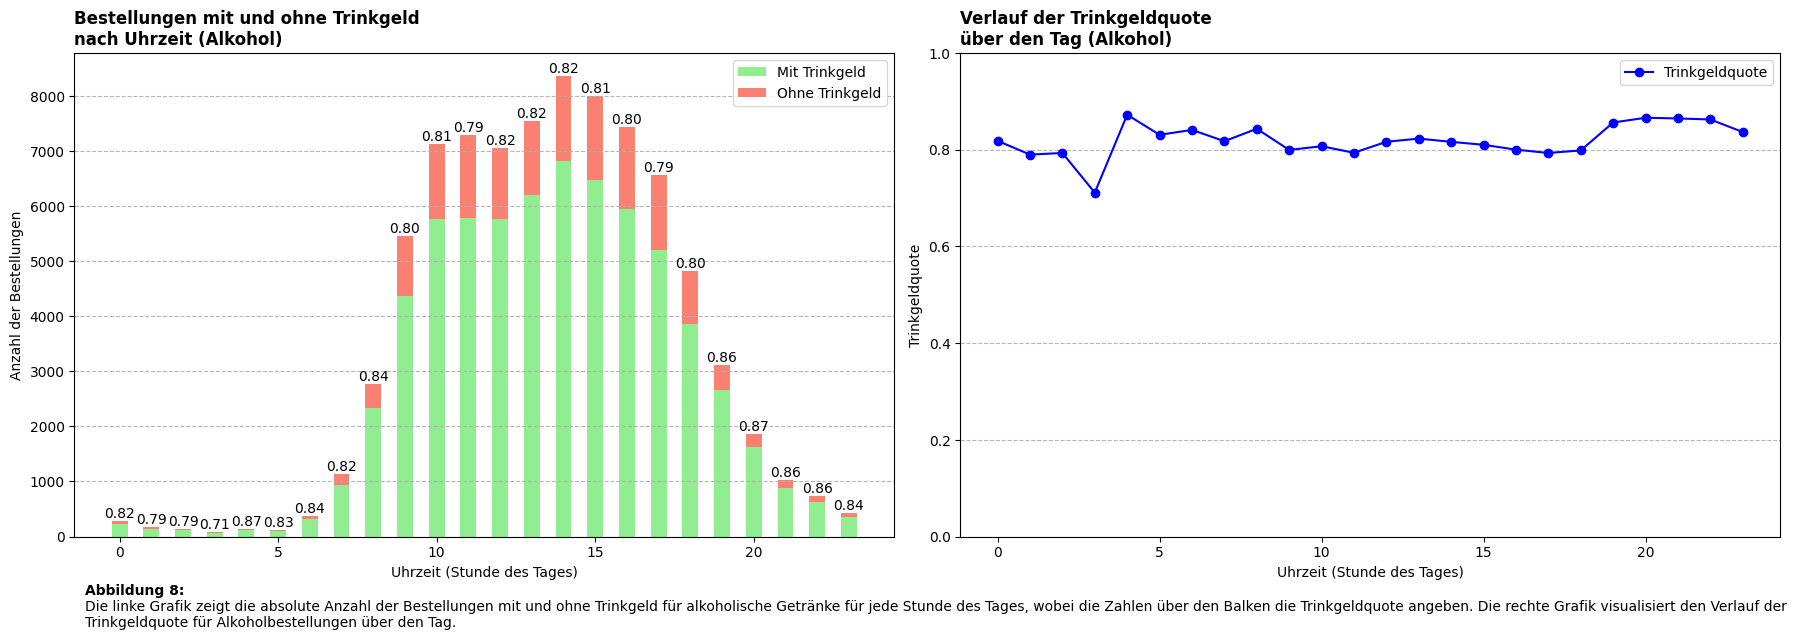

In [248]:
# plot code
alcohol_orders_df = pd.DataFrame(alcohol_orders_stats, columns=['hour_of_day', 'total_orders', 'orders_with_tips'])
alcohol_orders_df['orders_without_tips'] = alcohol_orders_df['total_orders'] - alcohol_orders_df['orders_with_tips']
alcohol_orders_df['tip_ratio'] = alcohol_orders_df['orders_with_tips'] / alcohol_orders_df['total_orders']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

bar_with_tips = ax1.bar(alcohol_orders_df['hour_of_day'], alcohol_orders_df['orders_with_tips'], 
                        bar_width, label='Mit Trinkgeld', color='lightgreen')
bar_without_tips = ax1.bar(alcohol_orders_df['hour_of_day'], alcohol_orders_df['orders_without_tips'], 
                          bar_width, bottom=alcohol_orders_df['orders_with_tips'], 
                          label='Ohne Trinkgeld', color='salmon')

for i, rect in enumerate(bar_with_tips):
    height = rect.get_height() + bar_without_tips[i].get_height()
    ratio = alcohol_orders_df['tip_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom')

ax1.set_title('Bestellungen mit und ohne Trinkgeld\nnach Uhrzeit (Alkohol)', 
              loc='left', weight='bold')
ax1.set_xlabel('Uhrzeit (Stunde des Tages)')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.9)

ax2.plot(alcohol_orders_df['hour_of_day'], alcohol_orders_df['tip_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote\nüber den Tag (Alkohol)', 
              loc='left', weight='bold')
ax2.set_xlabel('Uhrzeit (Stunde des Tages)')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.9)

description = 'Die linke Grafik zeigt die absolute Anzahl der Bestellungen mit und ohne Trinkgeld für alkoholische Getränke für jede Stunde des Tages, wobei die Zahlen über den Balken die Trinkgeldquote angeben. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote für Alkoholbestellungen über den Tag.'
fig.text(0.05, 0, 'Abbildung 8:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

### 💡 Erkenntnisse der Stundenanalyse: Alkoholbestellungen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Zeitliche Muster bei Alkoholbestellungen</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Bestellvolumen im Tagesverlauf</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Analyse zeigt einen deutlichen Tagesrhythmus bei Alkoholbestellungen:
        </p>
        <ul style="margin: 5px 0;">
            <li>Deutlich höheres Bestellaufkommen während der Tagesstunden</li>
            <li>Signifikanter Rückgang der Bestellungen in den Nachtstunden</li>
            <li>Erkennbares Muster typischen Konsumverhaltens</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Stabilität der Trinkgeldquote</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Bemerkenswerterweise zeigt die Trinkgeldquote eine hohe Konstanz:
        </p>
        <ul style="margin: 5px 0;">
            <li>Kaum Schwankungen im Tagesverlauf</li>
            <li>Stabile Trinkgeldbereitschaft unabhängig von der Tageszeit</li>
            <li>Keine erkennbare Korrelation zwischen Bestellvolumen und Trinkgeldquote</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>🎯 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Während das Bestellvolumen deutlichen tageszeitlichen Schwankungen unterliegt, 
            bleibt die Bereitschaft Trinkgeld zu geben bei Alkoholbestellungen konstant hoch. 
            Dies deutet darauf hin, dass die Trinkgeldvergabe bei Alkoholbestellungen weniger von 
            der Tageszeit als vielmehr von der Produktkategorie selbst beeinflusst wird.
        </p>
    </div>
</div>


In [ ]:
# Vergleich von Gesamtbestellungen und Alkoholbestellungen pro Stunde des Tages
total_orders = session.query(
    Order.hour_of_day,
    func.count(distinct(Order.order_id)).label('total_orders')
).group_by(Order.hour_of_day).subquery()

alcohol_orders = session.query(
    Order.hour_of_day,
    func.count(distinct(Order.order_id)).label('alcohol_orders')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%alcohol%')) \
 .group_by(Order.hour_of_day).subquery()

combined_stats = session.query(
    total_orders.c.hour_of_day,
    total_orders.c.total_orders,
    func.coalesce(alcohol_orders.c.alcohol_orders, 0).label('alcohol_orders')
).outerjoin(
    alcohol_orders,
    total_orders.c.hour_of_day == alcohol_orders.c.hour_of_day
).order_by(total_orders.c.hour_of_day).all()

combined_df = pd.DataFrame(combined_stats, columns=['hour_of_day', 'total_orders', 'alcohol_orders'])
combined_df['alcohol_ratio'] = combined_df['alcohol_orders'] / combined_df['total_orders']


### 📊 Einschub: Alkoholanteil im Bestellungsmix

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Relativer Anteil von Alkoholbestellungen</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Um ein vollständigeres Bild der Alkoholbestellungen zu erhalten, betrachten wir ergänzend den relativen 
        Anteil alkoholhaltiger Bestellungen am gesamten Bestellvolumen im Tagesverlauf. Diese Analyse hilft uns 
        zu verstehen, ob Alkoholbestellungen zu bestimmten Tageszeiten überproportional vertreten sind.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Analysefokus:</strong>
        <ul style="margin: 10px 0;">
            <li>Verhältnis: Bestellungen mit Alkohol / Gesamtbestellungen</li>
            <li>Stundenweise Betrachtung über 24 Stunden</li>
            <li>Prozentuale Darstellung der Anteile</li>
        </ul>
    </div>
</div>

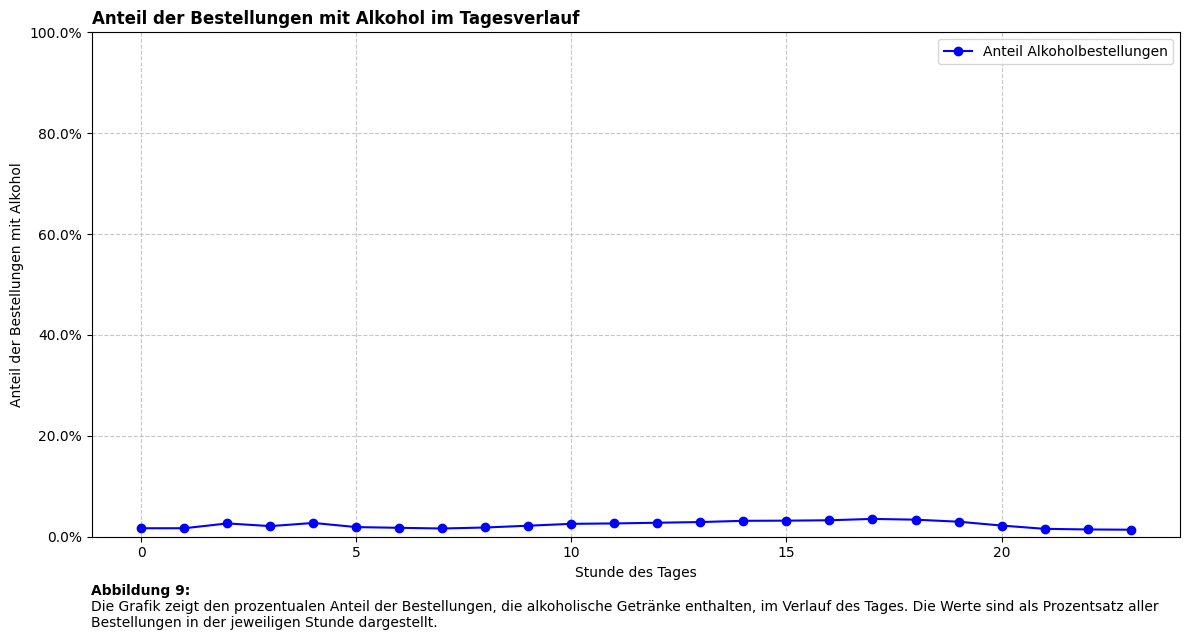

In [ ]:
# plot code
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

ax.plot(combined_df['hour_of_day'], combined_df['alcohol_ratio'], 
        marker='o', color='blue', label='Anteil Alkoholbestellungen')

ax.set_title('Anteil der Bestellungen mit Alkohol im Tagesverlauf', 
             loc='left', weight='bold')
ax.set_xlabel('Stunde des Tages')
ax.set_ylabel('Anteil der Bestellungen mit Alkohol')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
ax.set_ylim(0, 1)

description = 'Die Grafik zeigt den prozentualen Anteil der Bestellungen, die alkoholische Getränke enthalten, im Verlauf des Tages. Die Werte sind als Prozentsatz aller Bestellungen in der jeweiligen Stunde dargestellt.'
fig.text(0.08, 0, 'Abbildung 9:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

### 💡 Erkenntnisse zum Bestellmix

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Konstanz im Bestellverhalten</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Analyse des relativen Anteils</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Untersuchung des relativen Anteils von Alkoholbestellungen zeigt ein bemerkenswertes Muster:
        </p>
        <ul style="margin: 5px 0;">
            <li>Weitgehend konstanter Anteil über den gesamten Tagesverlauf</li>
            <li>Nur minimale Schwankungen ohne erkennbare zeitliche Systematik</li>
            <li>Keine signifikanten Ausreißer zu bestimmten Tageszeiten</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>🎯 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Stabilität des relativen Anteils deutet darauf hin, dass Alkoholbestellungen ein konstanter 
            Bestandteil des Bestellmix sind. Während die absolute Anzahl der Bestellungen im Tagesverlauf 
            variiert, bleibt der proportionale Anteil von Alkoholbestellungen bemerkenswert stabil.
        </p>
    </div>
</div>

In [334]:
# Bestellungen von alkoholischen Produkten nach Wochentag: Gesamtbestellungen und Bestellungen mit Trinkgeld

alcohol_orders_weekday_stats = session.query(
    Order.day_of_the_week,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%alcohol%')) \
 .group_by(Order.day_of_the_week) \
 .all()

### 📅 Wochenanalyse der Alkoholbestellungen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Betrachtung des Tagesverlaufs erweitern wir unsere zeitliche Analyse auf die Wochentage. 
        Dies ermöglicht uns, potenzielle Unterschiede zwischen Werktagen und Wochenenden sowie wöchentliche 
        Muster im Bestell- und Trinkgeldverhalten bei Alkoholprodukten zu identifizieren.
    </p>
</div>

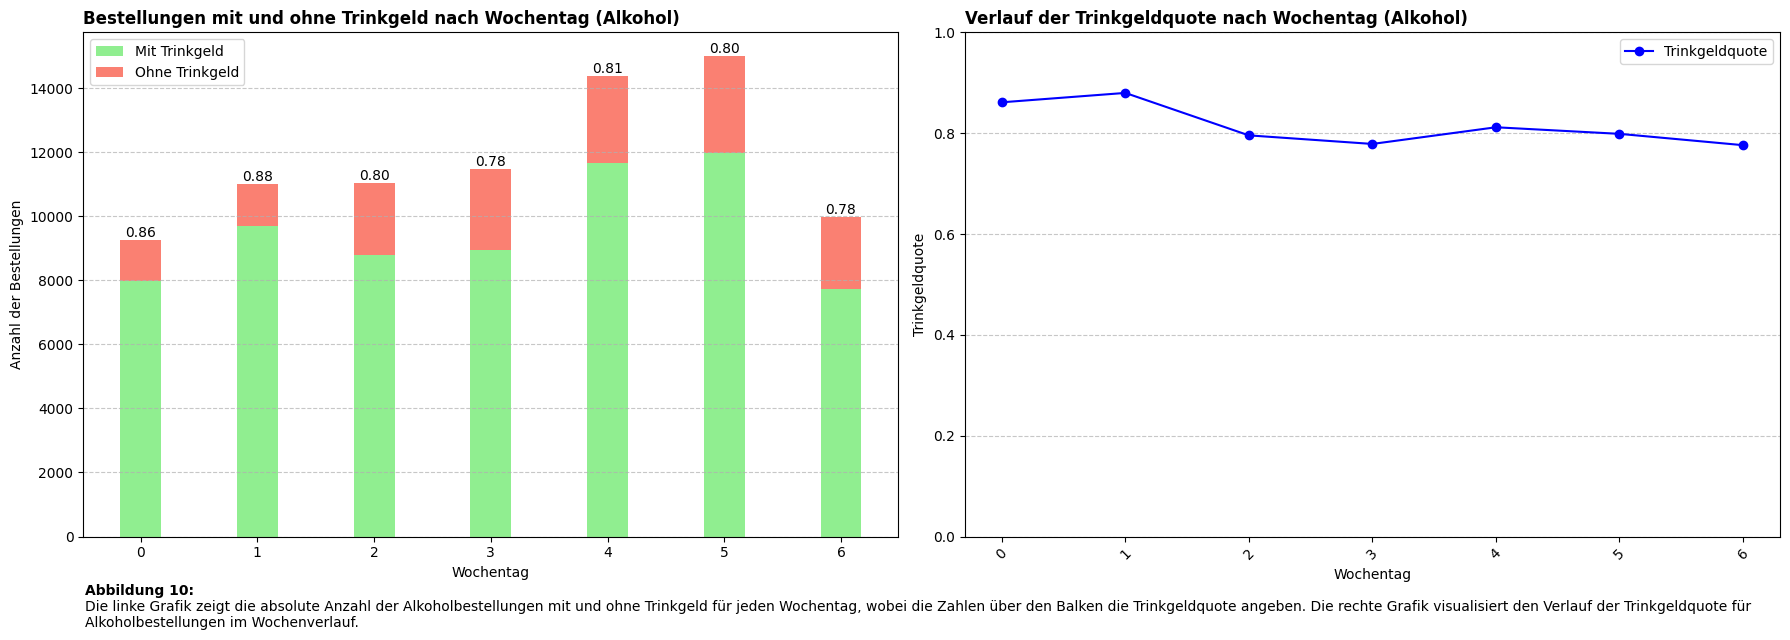

In [335]:
# plot code
alcohol_orders_weekday_df = pd.DataFrame(alcohol_orders_weekday_stats, columns=['day_of_the_week', 'total_orders', 'orders_with_tips'])

alcohol_orders_weekday_df['orders_without_tips'] = alcohol_orders_weekday_df['total_orders'] - alcohol_orders_weekday_df['orders_with_tips']
alcohol_orders_weekday_df['tip_ratio'] = alcohol_orders_weekday_df['orders_with_tips'] / alcohol_orders_weekday_df['total_orders']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

bar_width = 0.35

bar_with_tips = ax1.bar(alcohol_orders_weekday_df['day_of_the_week'], 
                        alcohol_orders_weekday_df['orders_with_tips'], 
                        bar_width, label='Mit Trinkgeld', color='lightgreen')
bar_without_tips = ax1.bar(alcohol_orders_weekday_df['day_of_the_week'], 
                          alcohol_orders_weekday_df['orders_without_tips'], 
                          bar_width, bottom=alcohol_orders_weekday_df['orders_with_tips'], 
                          label='Ohne Trinkgeld', color='salmon')

for i, rect in enumerate(bar_with_tips):
    height = rect.get_height() + bar_without_tips[i].get_height()
    ratio = alcohol_orders_weekday_df['tip_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom')

ax1.set_title('Bestellungen mit und ohne Trinkgeld nach Wochentag (Alkohol)', 
              loc='left', weight='bold')
ax1.set_xlabel('Wochentag')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

ax2.plot(alcohol_orders_weekday_df['day_of_the_week'], 
         alcohol_orders_weekday_df['tip_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote nach Wochentag (Alkohol)', 
              loc='left', weight='bold')
ax2.set_xlabel('Wochentag')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

description = 'Die linke Grafik zeigt die absolute Anzahl der Alkoholbestellungen mit und ohne Trinkgeld für jeden Wochentag, wobei die Zahlen über den Balken die Trinkgeldquote angeben. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote für Alkoholbestellungen im Wochenverlauf.'
fig.text(0.05, 0, 'Abbildung 10:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### 💡 Erkenntnisse der Wochenanalyse

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Wöchentliche Muster bei Alkoholbestellungen</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Trinkgeldverhalten (Tag 0-1)</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Zu Beginn der Woche zeigt sich eine erhöhte Trinkgeldbereitschaft:
        </p>
        <ul style="margin: 5px 0;">
            <li>Höhere Trinkgeldquote an den ersten beiden Wochentagen</li>
            <li>Möglicherweise erhöhte Kundenfreundlichkeit nach dem Wochenende</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Bestellvolumen (Tag 4-5)</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Zum Ende der Woche ist ein deutlicher Anstieg der Bestellmenge erkennbar:
        </p>
        <ul style="margin: 5px 0;">
            <li>Spitze im Bestellvolumen an Tag 4 und 5</li>
            <li>Typisches Muster für Wochenend-Einkäufe alkoholischer Getränke</li>
        </ul>
    </div>
</div>

In [338]:
# Detaillierte Trinkgeld-Analyse für Alkoholbestellungen: Anzahl und Verhältnis von Bestellungen mit Trinkgeld pro Wochentag und Stunde
results = (
    session.query(
        Order.day_of_the_week,
        Order.hour_of_day,
        func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips'),
        func.count(Order.order_id).label('total_orders'),
        (func.sum(case((Order.tips == True, 1), else_=0)) / func.count(Order.order_id)).label('tip_ratio')
    )
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)  # Verknüpfung mit Einkaufskorb
    .join(Product, Einkaufskorb.product_id == Product.product_id)  # Verknüpfung mit Product
    .join(Department, Product.department_id == Department.department_id)  # Verknüpfung mit Department
    .filter(Department.department_name == 'alcohol')  # Filter auf Alkohol-Abteilung
    .group_by(Order.day_of_the_week, Order.hour_of_day)
    .order_by(Order.day_of_the_week, Order.hour_of_day)
    .all()
)

df = pd.DataFrame(results, columns=['day_of_the_week', 'hour_of_day', 'orders_with_tips', 'total_orders', 'tip_ratio'])
df['tip_ratio'] = pd.to_numeric(df['tip_ratio'], errors='coerce')

all_days = range(7)  # 0–6 
all_hours = range(24)  # 0–23 
full_index = pd.DataFrame(itertools.product(all_days, all_hours), columns=['day_of_the_week', 'hour_of_day'])

df = full_index.merge(df, on=['day_of_the_week', 'hour_of_day'], how='left')
df['tip_ratio'] = df['tip_ratio'].fillna(0)

heatmap_data = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='tip_ratio'
)

total_orders_heatmap = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='total_orders'
)

orders_with_tips_heatmap = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='orders_with_tips'
)


### 🌡️ Kombinierte Zeitanalyse: Heatmap-Visualisierung

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Zweidimensionale Zeitanalyse</h4>  
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der separaten Betrachtung von Tages- und Wochenverlauf kombinieren wir nun beide zeitliche 
        Dimensionen in einer Heatmap. Diese Visualisierung ermöglicht es uns, spezifische Zeitfenster 
        mit besonders hoher oder niedriger Trinkgeldquote zu identifizieren.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Visualisierungsdetails:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>X-Achse:</strong> Stunden des Tages (0-23)</li>
            <li><strong>Y-Achse:</strong> Wochentage</li>
            <li><strong>Farbskala:</strong> 
                <ul>
                    <li>Rot = Hohe Trinkgeldquote</li>
                    <li>Blau = Niedrige Trinkgeldquote</li>
                </ul>
            </li>
        </ul>
    </div>
</div>

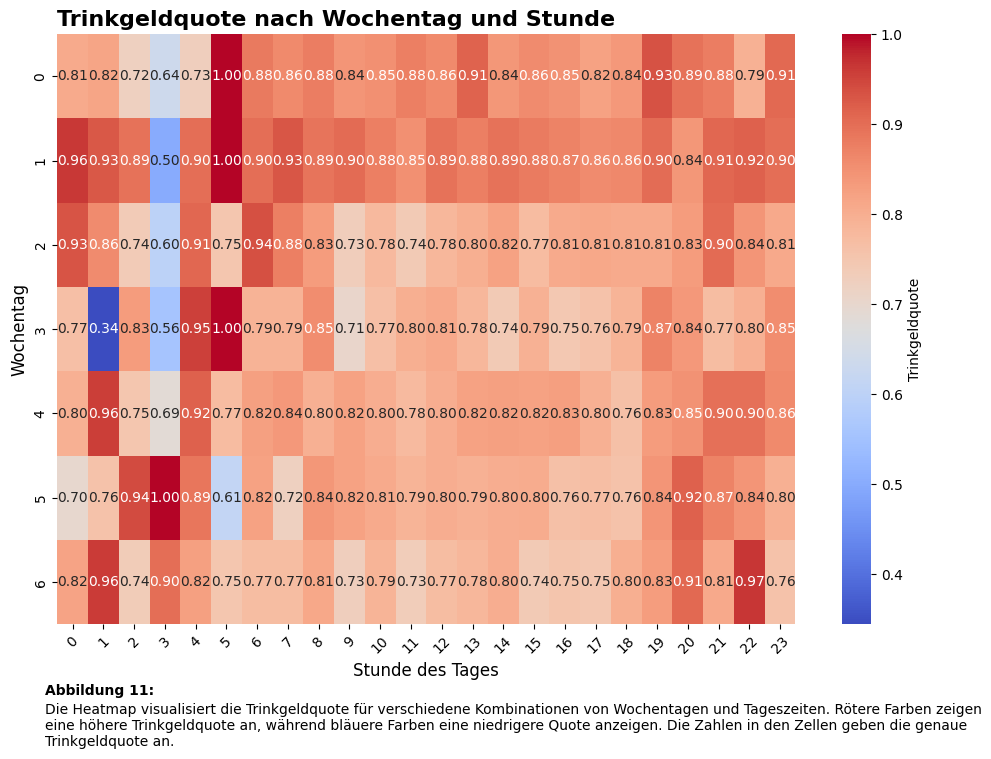

hour_of_day        0     1     2     3     4     5     6      7      8   \
day_of_the_week                                                           
0                36.0  22.0  18.0  11.0  22.0  19.0  52.0  135.0  296.0   
1                27.0  27.0  19.0  14.0  10.0  10.0  40.0  127.0  480.0   
2                44.0  21.0  19.0  10.0  11.0  16.0  48.0  178.0  371.0   
3                30.0  29.0  18.0   9.0  22.0  19.0  67.0  153.0  343.0   
4                49.0  23.0  20.0  16.0  24.0  22.0  57.0  172.0  450.0   
5                50.0  29.0  17.0  10.0  27.0  18.0  56.0  245.0  487.0   
6                39.0  25.0  34.0  20.0  17.0  20.0  57.0  135.0  340.0   

hour_of_day          9   ...      14      15      16      17     18     19  \
day_of_the_week          ...                                                 
0                 611.0  ...  1005.0   945.0   811.0   749.0  482.0  353.0   
1                 837.0  ...  1066.0  1082.0   978.0   923.0  625.0  407.0   
2                 717.0  ...  1070.0  1099.0  1005.0   883.0  749.0  420.0   
3                 764.0  ...  1153.0  1096.0  1083.0   930.0  728.0  425.0   
4                1003.0  ...  1444.0  1385.0  1291.0  1026.0  807.0  528.0   
5                1002.0  ...  1608.0  1354.0  1279.0  1143.0  795.0  555.0   
6                 535.0  ...  1024.0  1040.0  1004.0   909.0  645.0  426.0   

hour_of_day         20     21     22    23  
day_of_the_week                             
0                227.0  106.0   63.0  53.0  
1                249.0  175.0   84.0  49.0  
2                267.0  156.0  133.0  73.0  
3                306.0  162.0  142.0  48.0  
4                301.0  175.0  135.0  86.0  
5                300.0  131.0   89.0  49.0  
6                222.0  121.0   88.0  70.0  

[7 rows x 24 columns]

In [339]:
# plot code

fig, ax = plt.subplots(figsize=(10, 7))
plt.subplots_adjust(left=0.08)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Trinkgeldquote'},
    ax=ax
)

ax.set_title('Trinkgeldquote nach Wochentag und Stunde', 
             loc='left', 
             weight='bold',
             fontsize=16)
ax.set_xlabel('Stunde des Tages', fontsize=12)
ax.set_ylabel('Wochentag', fontsize=12)

description = 'Die Heatmap visualisiert die Trinkgeldquote für verschiedene Kombinationen von Wochentagen und Tageszeiten. Rötere Farben zeigen eine höhere Trinkgeldquote an, während bläuere Farben eine niedrigere Quote anzeigen. Die Zahlen in den Zellen geben die genaue Trinkgeldquote an.'
fig.text(0.05, -0, 'Abbildung 11:', weight='bold', ha='left')
fig.text(0.05, -0.07, description, wrap=True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_orders_heatmap

### 💡 Erkenntnisse der Heatmap-Analyse

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Identifizierte Muster und Einschränkungen</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>⚠️ Einschränkungen in der Nachtzeit</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Nachtstunden zeigen starke Schwankungen in der Trinkgeldquote, die jedoch aufgrund des geringen 
            Bestellvolumens statistisch wenig aussagekräftig sind:
        </p>
        <ul style="margin: 5px 0;">
            <li>Hohe Variabilität durch kleine Stichprobengrößen</li>
            <li>Zufallsbedingte Ausschläge in den Nachtstunden</li>
            <li>Eingeschränkte Interpretierbarkeit der nächtlichen Werte</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Stabile Muster</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Zuverlässige Erkenntnisse lassen sich aus den Tagesstunden und dem Wochenverlauf ableiten:
        </p>
        <ul style="margin: 5px 0;">
            <li>Erhöhte Trinkgeldquote an den Tagen 0 und 1</li>
            <li>Stabilere Quoten während der Tagesstunden</li>
            <li>Konsistenteres Muster im regulären Tagesgeschäft</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>🎯 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die aussagekräftigsten Muster zeigen sich in den Tagesstunden, während die Nachtzeit aufgrund 
            geringer Bestellzahlen keine verlässlichen Schlüsse zulässt. Die Wochentagseffekte sind besonders 
            zu Beginn der Woche deutlich erkennbar.
        </p>
    </div>
</div>

In [318]:
# Bestellungen von Tiefkühlprodukten nach Tageszeit: Gesamtbestellungen und Bestellungen mit Trinkgeld pro Stunde
frozen_orders_stats = session.query(
    Order.hour_of_day,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%frozen%')) \
 .group_by(Order.hour_of_day) \
 .all()

### ❄️ Zeitliche Analyse der Frozen-Kategorie

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔄 Vergleichsanalyse: Frozen Department</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der detaillierten Analyse der Alkoholkategorie wenden wir nun die gleiche methodische 
        Vorgehensweise auf das Frozen Department an. Als Kategorie mit der niedrigsten Trinkgeldquote 
        bildet sie einen interessanten Gegenpol zu den Alkoholbestellungen.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Analysestruktur:</strong>
        <ul style="margin: 10px 0;">
            <li>Stundenweise Analyse des Bestellverhaltens</li>
            <li>Wöchentliche Verteilung der Bestellungen</li>
            <li>Kombinierte Betrachtung in Form einer Heatmap</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Analyseziel:</strong>
        <p style="margin: 10px 0;">
            Identifikation möglicher zeitlicher Muster, die die niedrige Trinkgeldquote dieser 
            Kategorie erklären könnten, sowie Vergleich mit den Erkenntnissen aus der Alkohol-Analyse.
        </p>
    </div>
</div>

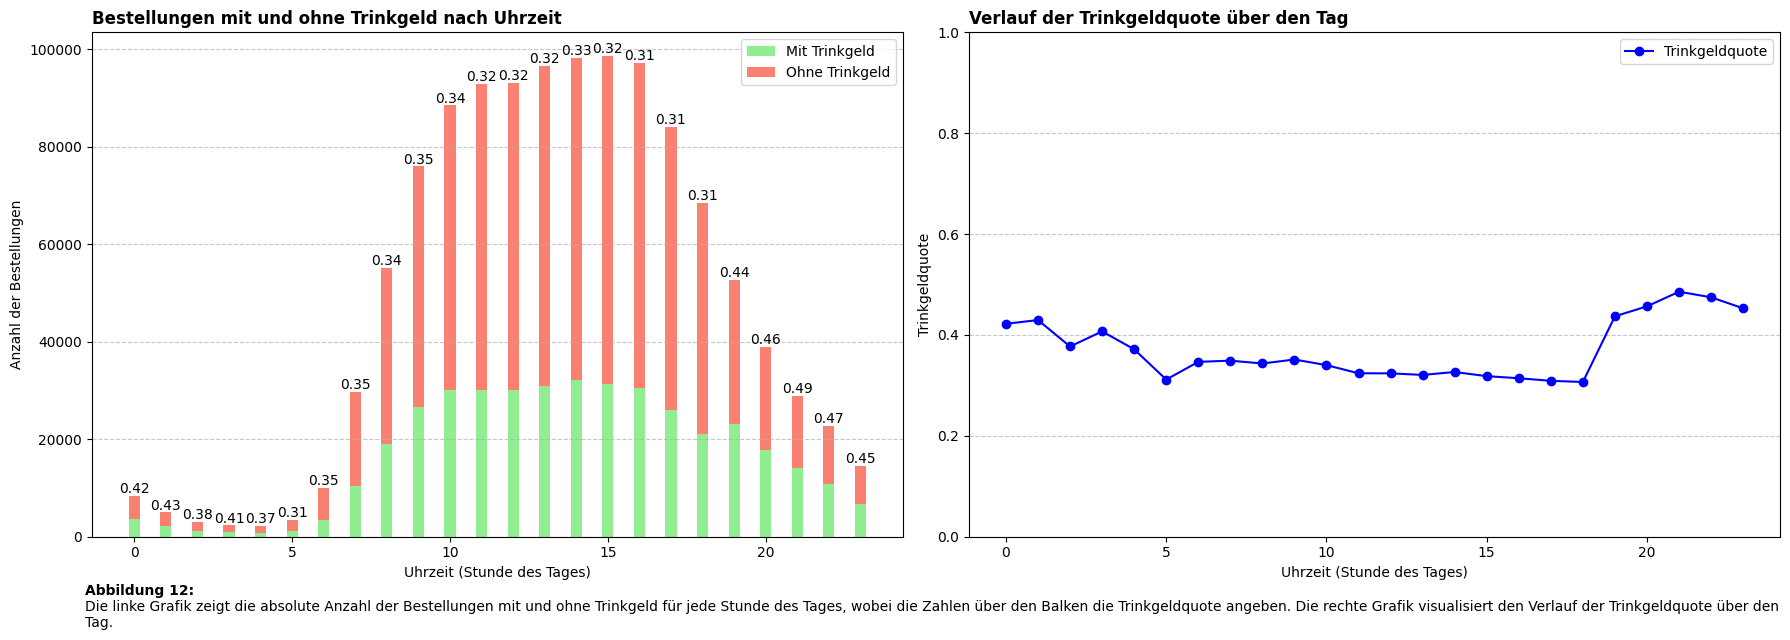

In [251]:
# plot code
frozen_orders_df = pd.DataFrame(frozen_orders_stats, columns=['hour_of_day', 'total_orders', 'orders_with_tips'])
frozen_orders_df['orders_without_tips'] = frozen_orders_df['total_orders'] - frozen_orders_df['orders_with_tips']
frozen_orders_df['tip_ratio'] = frozen_orders_df['orders_with_tips'] / frozen_orders_df['total_orders']

# Subplots erstellen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Linker Plot: Gestapeltes Balkendiagramm
bar_with_tips = ax1.bar(frozen_orders_df['hour_of_day'], frozen_orders_df['orders_with_tips'], 
                        bar_width, label='Mit Trinkgeld', color='lightgreen')
bar_without_tips = ax1.bar(frozen_orders_df['hour_of_day'], frozen_orders_df['orders_without_tips'], 
                          bar_width, bottom=frozen_orders_df['orders_with_tips'], 
                          label='Ohne Trinkgeld', color='salmon')

# Quotienten oben auf den Balken im linken Plot anzeigen
for i, rect in enumerate(bar_with_tips):
    height = rect.get_height() + bar_without_tips[i].get_height()
    ratio = frozen_orders_df['tip_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom')

# Titel und Achsenbeschriftungen für linken Plot
ax1.set_title('Bestellungen mit und ohne Trinkgeld nach Uhrzeit', 
              loc='left', weight='bold')
ax1.set_xlabel('Uhrzeit (Stunde des Tages)')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Rechter Plot: Liniendiagramm der Trinkgeldquote
ax2.plot(frozen_orders_df['hour_of_day'], frozen_orders_df['tip_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote über den Tag', 
              loc='left', weight='bold')
ax2.set_xlabel('Uhrzeit (Stunde des Tages)')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Bildunterschrift
description = 'Die linke Grafik zeigt die absolute Anzahl der Bestellungen mit und ohne Trinkgeld für jede Stunde des Tages, wobei die Zahlen über den Balken die Trinkgeldquote angeben. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote über den Tag.'
fig.text(0.05, 0, 'Abbildung 12:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

In [73]:
# Vergleich von Gesamtbestellungen und Tiefkühlprodukt-Bestellungen pro Stunde des Tages

total_orders = session.query(
    Order.hour_of_day,
    func.count(distinct(Order.order_id)).label('total_orders')
).group_by(Order.hour_of_day).subquery()

frozen_orders = session.query(
    Order.hour_of_day,
    func.count(distinct(Order.order_id)).label('frozen_orders')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%frozen%')) \
 .group_by(Order.hour_of_day).subquery()

combined_stats = session.query(
    total_orders.c.hour_of_day,
    total_orders.c.total_orders,
    func.coalesce(frozen_orders.c.frozen_orders, 0).label('frozen_orders')
).outerjoin(
    frozen_orders,
    total_orders.c.hour_of_day == frozen_orders.c.hour_of_day
).order_by(total_orders.c.hour_of_day).all()


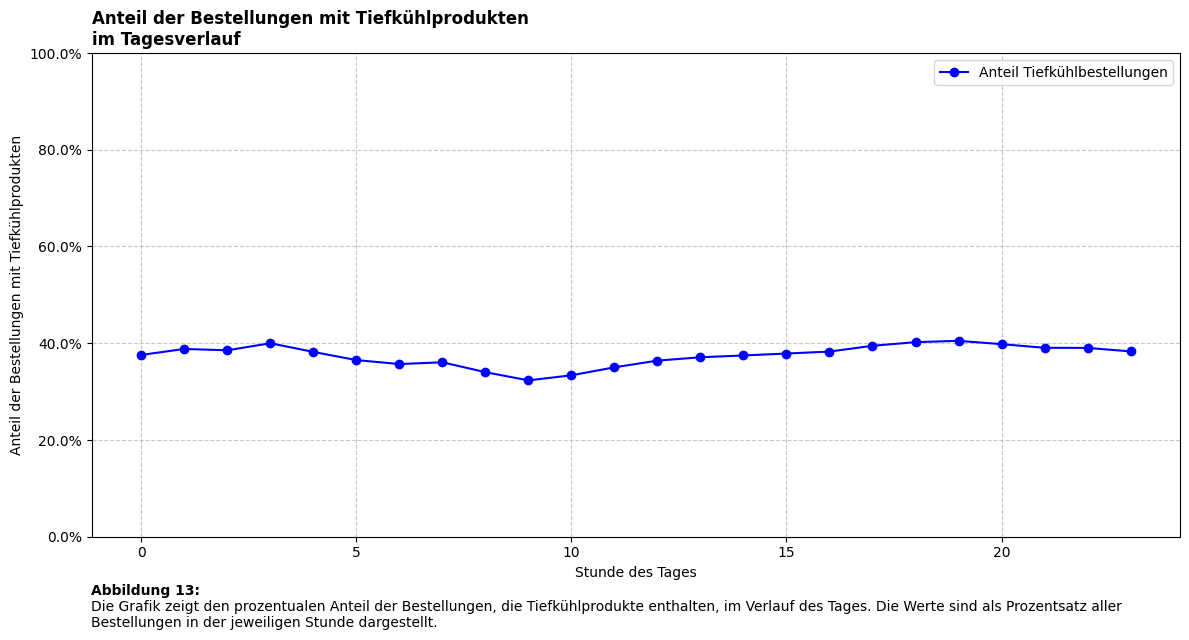

In [80]:
# plot code
combined_df = pd.DataFrame(combined_stats, columns=['hour_of_day', 'total_orders', 'frozen_orders'])
combined_df['frozen_ratio'] = combined_df['frozen_orders'] / combined_df['total_orders']

fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

ax.plot(combined_df['hour_of_day'], combined_df['frozen_ratio'], 
        marker='o', color='blue', label='Anteil Tiefkühlbestellungen')

ax.set_title('Anteil der Bestellungen mit Tiefkühlprodukten\nim Tagesverlauf', 
             loc='left', weight='bold')
ax.set_xlabel('Stunde des Tages')
ax.set_ylabel('Anteil der Bestellungen mit Tiefkühlprodukten')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
ax.set_ylim(0, 1)

description = 'Die Grafik zeigt den prozentualen Anteil der Bestellungen, die Tiefkühlprodukte enthalten, im Verlauf des Tages. Die Werte sind als Prozentsatz aller Bestellungen in der jeweiligen Stunde dargestellt.'
fig.text(0.08, 0, 'Abbildung 13:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

In [81]:
# Bestellungen von Tiefkühlprodukten nach Wochentag: Gesamtbestellungen und Bestellungen mit Trinkgeld
frozen_orders_weekday_stats = session.query(
    Order.day_of_the_week,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%frozen%')) \
 .group_by(Order.day_of_the_week) \
 .all()

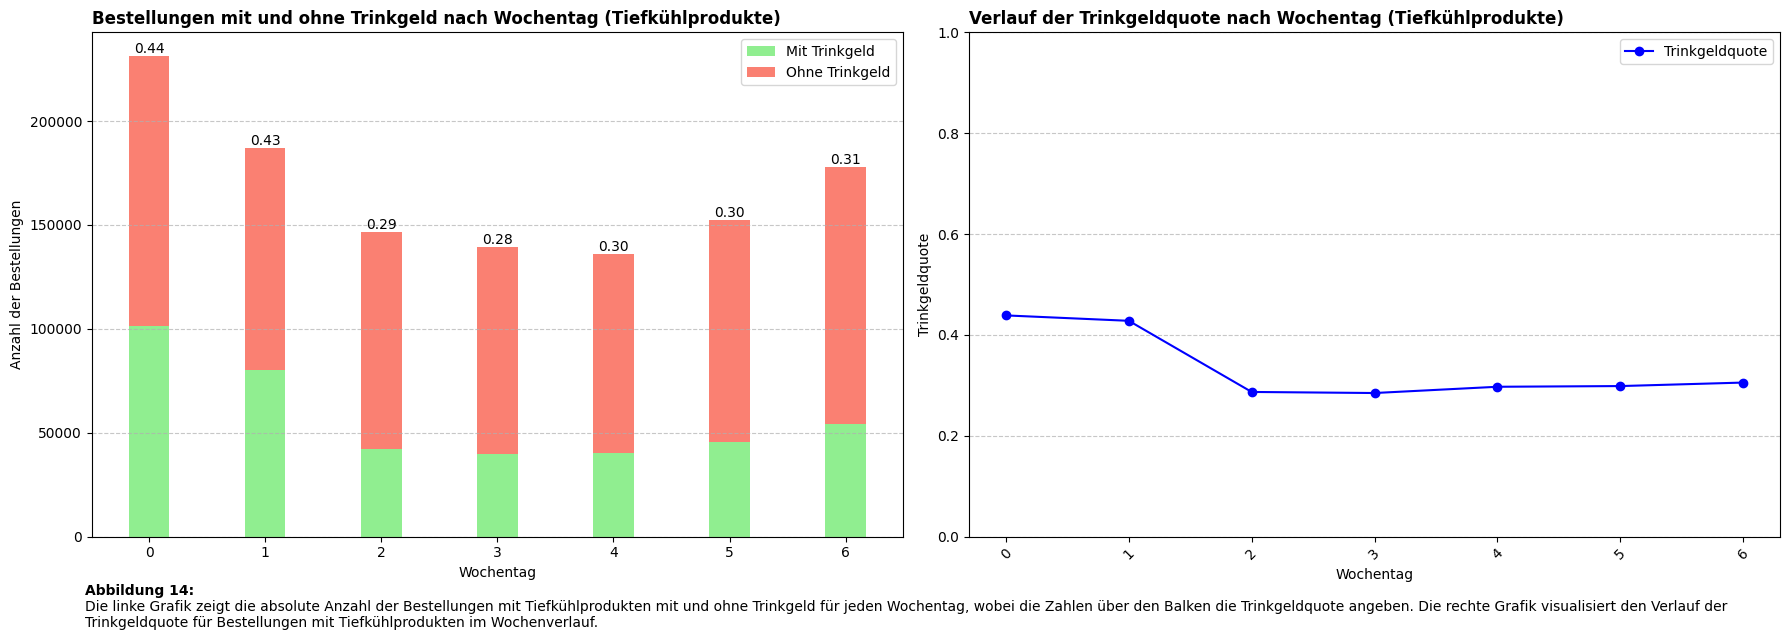

In [252]:
# plot code
frozen_orders_weekday_df = pd.DataFrame(frozen_orders_weekday_stats, columns=['day_of_the_week', 'total_orders', 'orders_with_tips'])

frozen_orders_weekday_df['orders_without_tips'] = frozen_orders_weekday_df['total_orders'] - frozen_orders_weekday_df['orders_with_tips']
frozen_orders_weekday_df['tip_ratio'] = frozen_orders_weekday_df['orders_with_tips'] / frozen_orders_weekday_df['total_orders']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

bar_width = 0.35

bar_with_tips = ax1.bar(frozen_orders_weekday_df['day_of_the_week'], 
                        frozen_orders_weekday_df['orders_with_tips'], 
                        bar_width, label='Mit Trinkgeld', color='lightgreen')
bar_without_tips = ax1.bar(frozen_orders_weekday_df['day_of_the_week'], 
                          frozen_orders_weekday_df['orders_without_tips'], 
                          bar_width, bottom=frozen_orders_weekday_df['orders_with_tips'], 
                          label='Ohne Trinkgeld', color='salmon')

for i, rect in enumerate(bar_with_tips):
    height = rect.get_height() + bar_without_tips[i].get_height()
    ratio = frozen_orders_weekday_df['tip_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom')

ax1.set_title('Bestellungen mit und ohne Trinkgeld nach Wochentag (Tiefkühlprodukte)', 
              loc='left', weight='bold')
ax1.set_xlabel('Wochentag')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)


ax2.plot(frozen_orders_weekday_df['day_of_the_week'], 
         frozen_orders_weekday_df['tip_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote nach Wochentag (Tiefkühlprodukte)', 
              loc='left', weight='bold')
ax2.set_xlabel('Wochentag')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


description = 'Die linke Grafik zeigt die absolute Anzahl der Bestellungen mit Tiefkühlprodukten mit und ohne Trinkgeld für jeden Wochentag, wobei die Zahlen über den Balken die Trinkgeldquote angeben. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote für Bestellungen mit Tiefkühlprodukten im Wochenverlauf.'
fig.text(0.05, 0, 'Abbildung 14:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Vergleich von Gesamtbestellungen und Tiefkühlprodukt-Bestellungen pro Wochentag
total_orders = session.query(
    Order.day_of_the_week,
    func.count(distinct(Order.order_id)).label('total_orders')
).group_by(Order.day_of_the_week).subquery()

frozen_orders = session.query(
    Order.day_of_the_week,
    func.count(distinct(Order.order_id)).label('frozen_orders')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%frozen%')) \
 .group_by(Order.day_of_the_week).subquery()

combined_stats = session.query(
    total_orders.c.day_of_the_week,
    total_orders.c.total_orders,
    func.coalesce(frozen_orders.c.frozen_orders, 0).label('frozen_orders')
).outerjoin(
    frozen_orders,
    total_orders.c.day_of_the_week == frozen_orders.c.day_of_the_week
).order_by(total_orders.c.day_of_the_week).all()

combined_df = pd.DataFrame(combined_stats, columns=['day_of_week', 'total_orders', 'frozen_orders'])
combined_df['frozen_ratio'] = combined_df['frozen_orders'] / combined_df['total_orders']


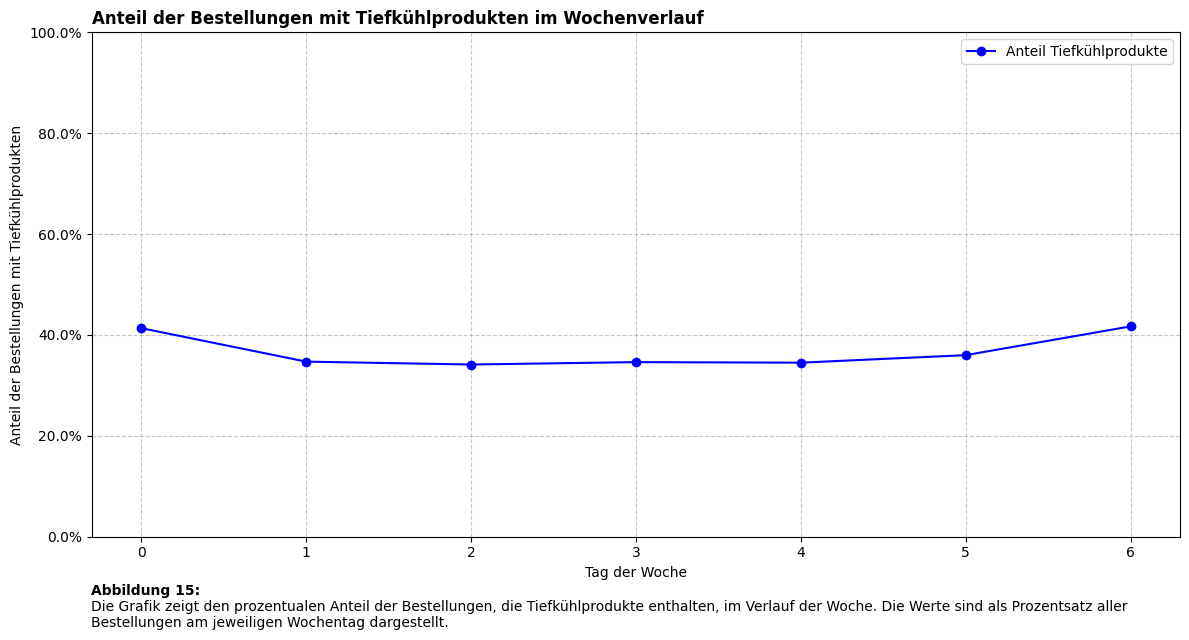

In [ ]:
# plot code
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

ax.plot(combined_df['day_of_week'], combined_df['frozen_ratio'], 
        marker='o', color='blue', label='Anteil Tiefkühlprodukte')

ax.set_title('Anteil der Bestellungen mit Tiefkühlprodukten im Wochenverlauf', 
             loc='left', weight='bold')
ax.set_xlabel('Tag der Woche')
ax.set_ylabel('Anteil der Bestellungen mit Tiefkühlprodukten')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

ax.set_ylim(0, 1)

ax.set_xticks(range(7))

description = 'Die Grafik zeigt den prozentualen Anteil der Bestellungen, die Tiefkühlprodukte enthalten, im Verlauf der Woche. Die Werte sind als Prozentsatz aller Bestellungen am jeweiligen Wochentag dargestellt.'
fig.text(0.08, 0, 'Abbildung 15:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

In [92]:
# Detaillierte Trinkgeld-Analyse für Tiefkühlprodukte: Anzahl und Verhältnis von Bestellungen mit Trinkgeld pro Wochentag und Stunde
results = (
    session.query(
        Order.day_of_the_week,
        Order.hour_of_day,
        func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips'),
        func.count(Order.order_id).label('total_orders'),
        (func.sum(case((Order.tips == True, 1), else_=0)) / func.count(Order.order_id)).label('tip_ratio')
    )
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)  # Verknüpfung mit Einkaufskorb
    .join(Product, Einkaufskorb.product_id == Product.product_id)  # Verknüpfung mit Product
    .join(Department, Product.department_id == Department.department_id)  # Verknüpfung mit Department
    .filter(Department.department_name == 'frozen')  # Filter auf Alkohol-Abteilung
    .group_by(Order.day_of_the_week, Order.hour_of_day)
    .order_by(Order.day_of_the_week, Order.hour_of_day)
    .all()
)


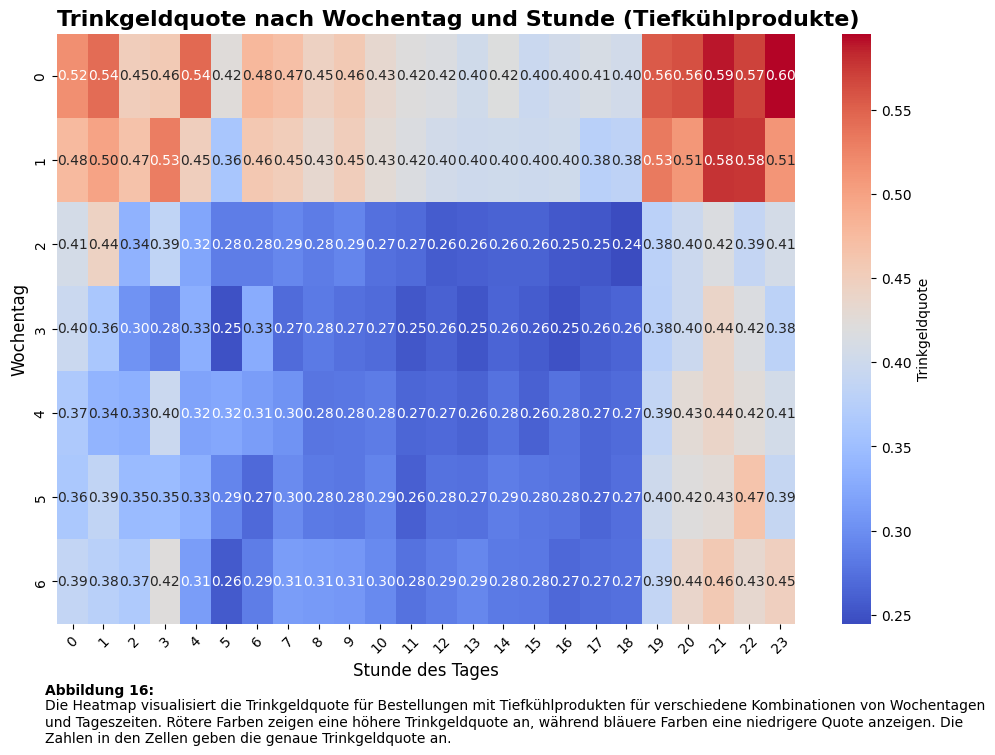

hour_of_day          0      1      2      3      4      5       6       7   \
day_of_the_week                                                              
0                1454.0  915.0  550.0  406.0  301.0  454.0  1380.0  4633.0   
1                1294.0  735.0  402.0  292.0  278.0  480.0  1560.0  4855.0   
2                1096.0  621.0  333.0  283.0  313.0  478.0  1328.0  3928.0   
3                1040.0  658.0  408.0  232.0  299.0  456.0  1420.0  3832.0   
4                 995.0  520.0  318.0  273.0  241.0  461.0  1360.0  3982.0   
5                1089.0  637.0  480.0  409.0  411.0  622.0  1645.0  4373.0   
6                1322.0  856.0  450.0  377.0  331.0  504.0  1311.0  4093.0   

hour_of_day           8        9   ...       14       15       16       17  \
day_of_the_week                    ...                                       
0                10573.0  15247.0  ...  21459.0  21618.0  19536.0  15894.0   
1                 9083.0  13342.0  ...  15199.0  15480.0  14989.0  12897.0   
2                 6817.0   9195.0  ...  11855.0  11742.0  12076.0  11079.0   
3                 6507.0   8495.0  ...  10837.0  11272.0  11866.0  10765.0   
4                 6219.0   8177.0  ...  10668.0  10998.0  11213.0  10033.0   
5                 7194.0   9925.0  ...  12449.0  12228.0  12420.0  11009.0   
6                 8677.0  11552.0  ...  15811.0  15236.0  15060.0  12329.0   

hour_of_day           18      19      20      21      22      23  
day_of_the_week                                                   
0                11441.0  8534.0  6855.0  5283.0  4203.0  2347.0  
1                10475.0  8119.0  6056.0  4273.0  3217.0  2005.0  
2                 9435.0  7279.0  5483.0  3746.0  2850.0  2015.0  
3                 9139.0  7095.0  4887.0  3721.0  2950.0  1770.0  
4                 8876.0  7181.0  5189.0  3989.0  3101.0  1999.0  
5                 9166.0  7251.0  5022.0  3753.0  3004.0  2105.0  
6                 9932.0  7195.0  5473.0  4135.0  3301.0  2290.0  

[7 rows x 24 columns]

In [ ]:
# plot code
df = pd.DataFrame(results, columns=['day_of_the_week', 'hour_of_day', 'orders_with_tips', 'total_orders', 'tip_ratio'])
df['tip_ratio'] = pd.to_numeric(df['tip_ratio'], errors='coerce')

all_days = range(7)  # 0–6
all_hours = range(24)  # 0–23 
full_index = pd.DataFrame(itertools.product(all_days, all_hours), columns=['day_of_the_week', 'hour_of_day'])

df = full_index.merge(df, on=['day_of_the_week', 'hour_of_day'], how='left')
df['tip_ratio'] = df['tip_ratio'].fillna(0)

heatmap_data = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='tip_ratio'
)

total_orders_heatmap = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='total_orders'
)

orders_with_tips_heatmap = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='orders_with_tips'
)


fig, ax = plt.subplots(figsize=(10, 7))
plt.subplots_adjust(left=0.08)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Trinkgeldquote'},
    ax=ax
)

ax.set_title('Trinkgeldquote nach Wochentag und Stunde (Tiefkühlprodukte)', 
             loc='left', 
             weight='bold',
             fontsize=16)
ax.set_xlabel('Stunde des Tages', fontsize=12)
ax.set_ylabel('Wochentag', fontsize=12)

description = 'Die Heatmap visualisiert die Trinkgeldquote für Bestellungen mit Tiefkühlprodukten für verschiedene Kombinationen von Wochentagen und Tageszeiten. Rötere Farben zeigen eine höhere Trinkgeldquote an, während bläuere Farben eine niedrigere Quote anzeigen. Die Zahlen in den Zellen geben die genaue Trinkgeldquote an.'
fig.text(0.05, 0, 'Abbildung 16:', weight='bold', ha='left')
fig.text(0.05, -0.065, description, wrap=True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_orders_heatmap

### 💡 Zentrale Erkenntnisse der Frozen-Analyse

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Zeitliche Muster im Frozen Department</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Tagesverlauf</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Im Tagesverlauf zeigen sich interessante Muster:
        </p>
        <ul style="margin: 5px 0;">
            <li>Höheres Bestellaufkommen während der Tagesstunden, ähnlich wie bei Alkohol</li>
            <li>Überraschend erhöhte Trinkgeldquote in den Nachtstunden</li>
            <li>Leicht erhöhter relativer Anteil von Frozen-Produkten in Nachtbestellungen</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📅 Wochenverlauf</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Im Wochenverlauf sind deutliche Variationen erkennbar:
        </p>
        <ul style="margin: 5px 0;">
            <li>Erhöhte Trinkgeldquote an den Tagen 0 und 1</li>
            <li>Gesteigerter Anteil von Frozen-Bestellungen an den Tagen 6 und 0</li>
            <li>Niedrigere Trinkgeldquoten im mittleren Wochenverlauf</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>🌡️ Heatmap-Erkenntnisse</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die kombinierte Zeit-Analyse zeigt ein besonders markantes Muster:
        </p>
        <ul style="margin: 5px 0;">
            <li>Deutlich erhöhte Trinkgeldquote in den Nachtstunden der Tage 0 und 1</li>
            <li>Kontrastierend niedrigere Quoten an den Tagen 2-6 während der Tagesstunden</li>
            <li>Klare zeitliche und wöchentliche Strukturierung des Trinkgeldverhaltens</li>
        </ul>
    </div>
</div>

In [341]:
# Query: Anzahl der Produkte pro Bestellung und ob Trinkgeld gegeben wurde
all_orders_item_count_with_tips = session.query(
    Order.order_id,
    func.count(Einkaufskorb.product_id).label('item_count'),
    Order.tips,
    func.count(Order.order_id).label('total_orders')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .group_by(Order.order_id) \
 .all()

### 🛒 Analyse des Zusammenhangs zwischen Bestellgröße und Trinkgeldverhalten

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Einfluss der Produktanzahl auf Trinkgeld</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach den zeitlichen Analysen untersuchen wir nun den Zusammenhang zwischen der Anzahl der Produkte 
        in einer Bestellung und der Wahrscheinlichkeit einer Trinkgeldgabe. Diese Analyse soll Aufschluss 
        darüber geben, ob größere Bestellungen zu einem anderen Trinkgeldverhalten führen.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Visualisierungsdetails:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Absolute Verteilung der Bestellungen nach Produktanzahl</li>
            <li><strong>Rechter Plot:</strong> Trinkgeldquote in Abhängigkeit von der Bestellgröße</li>
            <li><strong>Besonderheit:</strong> Markierung der Grenze, ab der die Stichprobengröße für 
            statistisch belastbare Aussagen zu klein wird (< 500 Bestellungen)</li>
        </ul>
    </div>
</div>

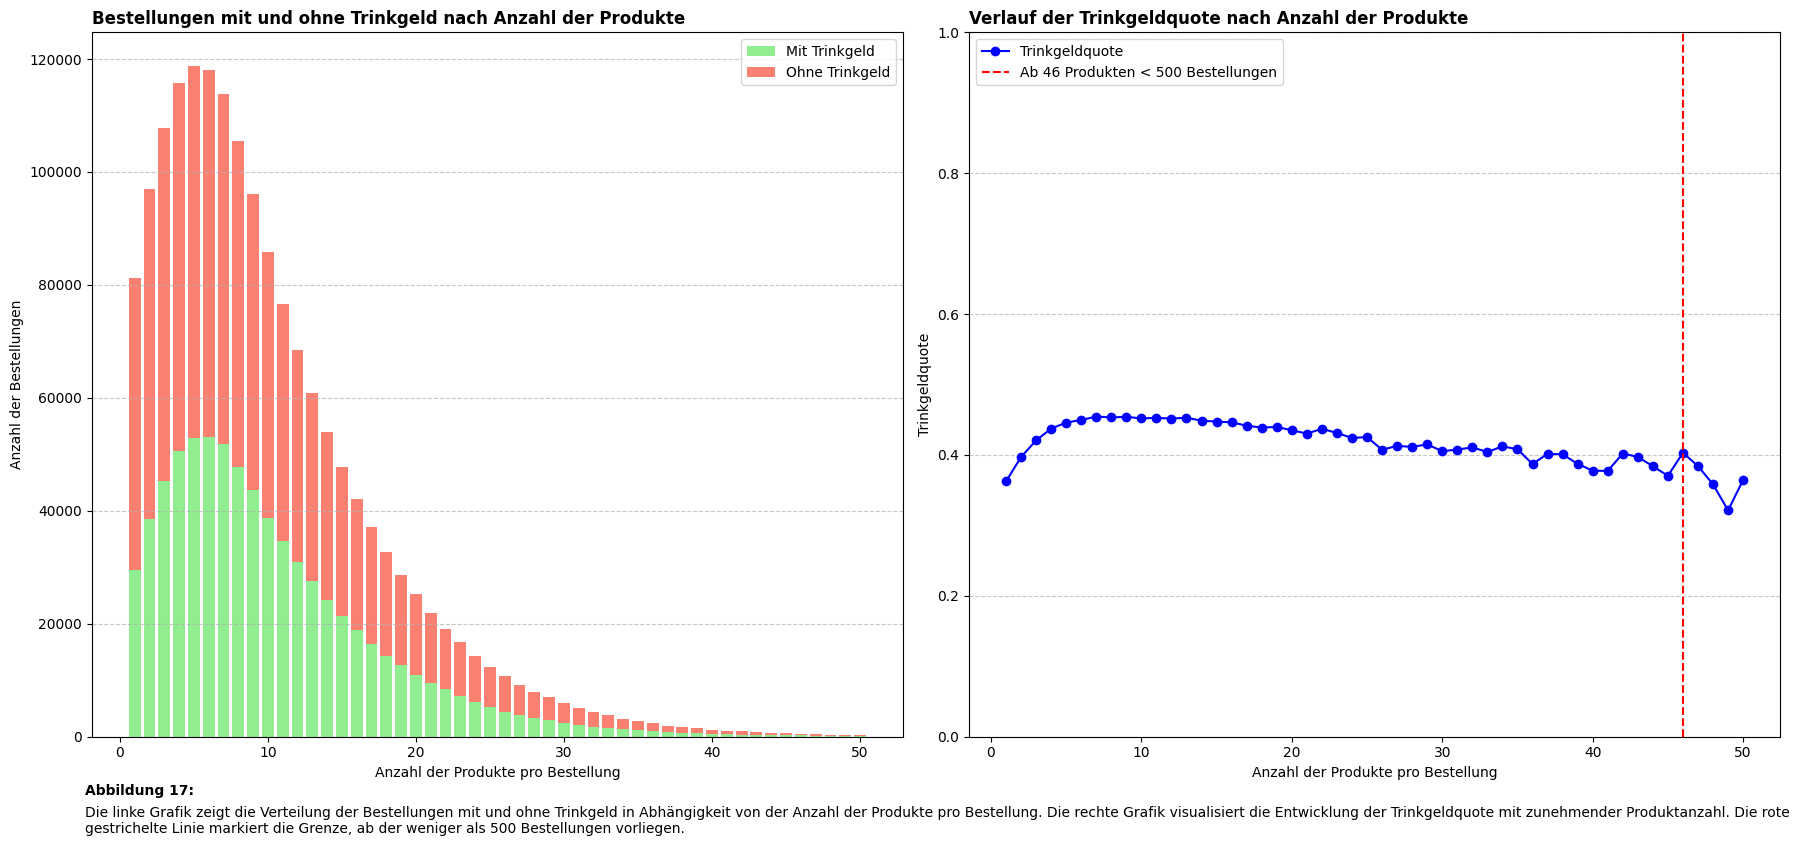

In [342]:
# plot code
results = all_orders_item_count_with_tips

df = pd.DataFrame(results, columns=['order_id', 'item_count', 'tips', 'total_orders'])

df['with_tips'] = df['tips'].apply(lambda x: 1 if x else 0)
df['without_tips'] = df['tips'].apply(lambda x: 0 if x else 1)

df = df[df['item_count'] <= 50]

agg_df = df.groupby('item_count').agg(
    orders_with_tips=('with_tips', 'sum'),
    orders_without_tips=('without_tips', 'sum'),
    total_orders=('order_id', 'count')
).reset_index()

agg_df['tips_ratio'] = agg_df['orders_with_tips'] / agg_df['total_orders']

threshold_item_count = agg_df[agg_df['total_orders'] < 500]['item_count'].min()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
plt.subplots_adjust(left=0.08)

bar_width = 0.8

bar_with_tips = ax1.bar(agg_df['item_count'], agg_df['orders_with_tips'], 
                        bar_width, label='Mit Trinkgeld', color='lightgreen')
bar_without_tips = ax1.bar(agg_df['item_count'], agg_df['orders_without_tips'], 
                          bar_width, bottom=agg_df['orders_with_tips'], 
                          label='Ohne Trinkgeld', color='salmon')

ax1.set_xlabel('Anzahl der Produkte pro Bestellung')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen mit und ohne Trinkgeld nach Anzahl der Produkte', 
              loc='left', weight='bold')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)


ax2.plot(agg_df['item_count'], agg_df['tips_ratio'], 
         marker='o', color='b', label='Trinkgeldquote')
ax2.set_xlabel('Anzahl der Produkte pro Bestellung')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote nach Anzahl der Produkte', 
              loc='left', weight='bold')
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


ax2.set_ylim(0, 1)

if not pd.isna(threshold_item_count):
    ax2.axvline(x=threshold_item_count, color='red', linestyle='--', 
                label=f'Ab {threshold_item_count} Produkten < 500 Bestellungen')
    ax2.legend()

description = 'Die linke Grafik zeigt die Verteilung der Bestellungen mit und ohne Trinkgeld in Abhängigkeit von der Anzahl der Produkte pro Bestellung. Die rechte Grafik visualisiert die Entwicklung der Trinkgeldquote mit zunehmender Produktanzahl. Die rote gestrichelte Linie markiert die Grenze, ab der weniger als 500 Bestellungen vorliegen.'
fig.text(0.05, 0, 'Abbildung 17:', weight='bold', ha='left')
fig.text(0.05, -0.045, description, wrap=True)

plt.tight_layout()
plt.show()




### 💡 Erkenntnisse zur Bestellgröße und Trinkgeldverhalten

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">📊 Beobachtete Muster</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Entwicklung der Trinkgeldquote</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Analyse zeigt ein charakteristisches Muster:
        </p>
        <ul style="margin: 5px 0;">
            <li>Kleiner Anstieg der Trinkgeldquote bis ca. 8 Produkte pro Bestellung</li>
            <li>Anschließende Stabilisierung auf diesem erhöhten Niveau</li>
            <li>Keine weitere Steigerung bei noch größeren Bestellungen</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>🎯 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Es scheint einen "Schwellenwert" von etwa 8 Produkten zu geben, bis zu dem die Bestellgröße 
            einen positiven Einfluss auf die Trinkgeldbereitschaft hat. Darüber hinaus führen zusätzliche 
            Produkte zu keiner weiteren Steigerung der Trinkgeldquote.
        </p>
    </div>
</div>

### 🛍️ Detailanalyse: Bestellgröße nach Departments

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Abteilungsspezifische Untersuchung des Bestellvolumens</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der allgemeinen Analyse des Zusammenhangs zwischen Bestellgröße und Trinkgeldverhalten 
        vertiefen wir nun die Untersuchung auf Abteilungsebene. Dies ermöglicht uns, potenzielle 
        departmentspezifische Unterschiede in diesem Zusammenhang zu identifizieren.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Analysestruktur:</strong>
        <ul style="margin: 10px 0;">
            <li>Separate Analyse für jede Produktabteilung</li>
            <li>Identische Visualisierung wie in der Gesamtanalyse:
                <ul>
                    <li>Links: Absolute Verteilung der Bestellungen</li>
                    <li>Rechts: Trinkgeldquote nach Produktanzahl</li>
                </ul>
            </li>
            <li>Markierung der statistischen Relevanzschwelle (n < 500)</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Erkenntnisziel:</strong>
        <p style="margin: 10px 0;">
            Identifikation von abteilungsspezifischen Mustern im Zusammenhang zwischen 
            Bestellgröße und Trinkgeldverhalten, um mögliche Unterschiede zwischen den 
            Produktkategorien aufzudecken.
        </p>
    </div>
</div>

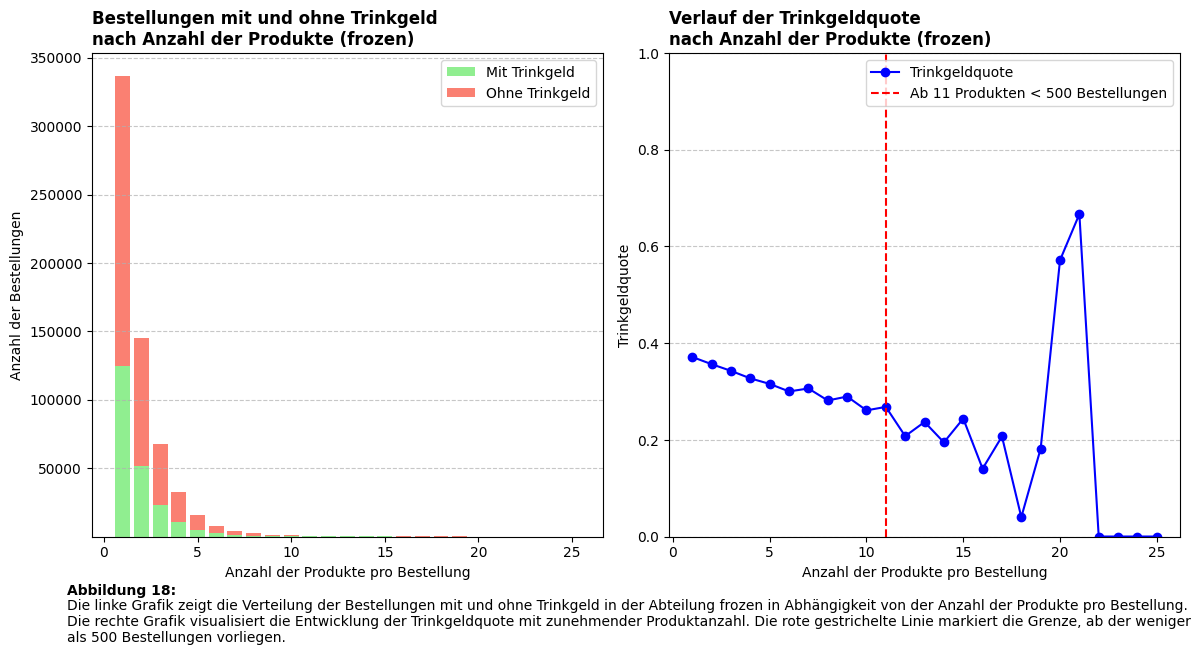

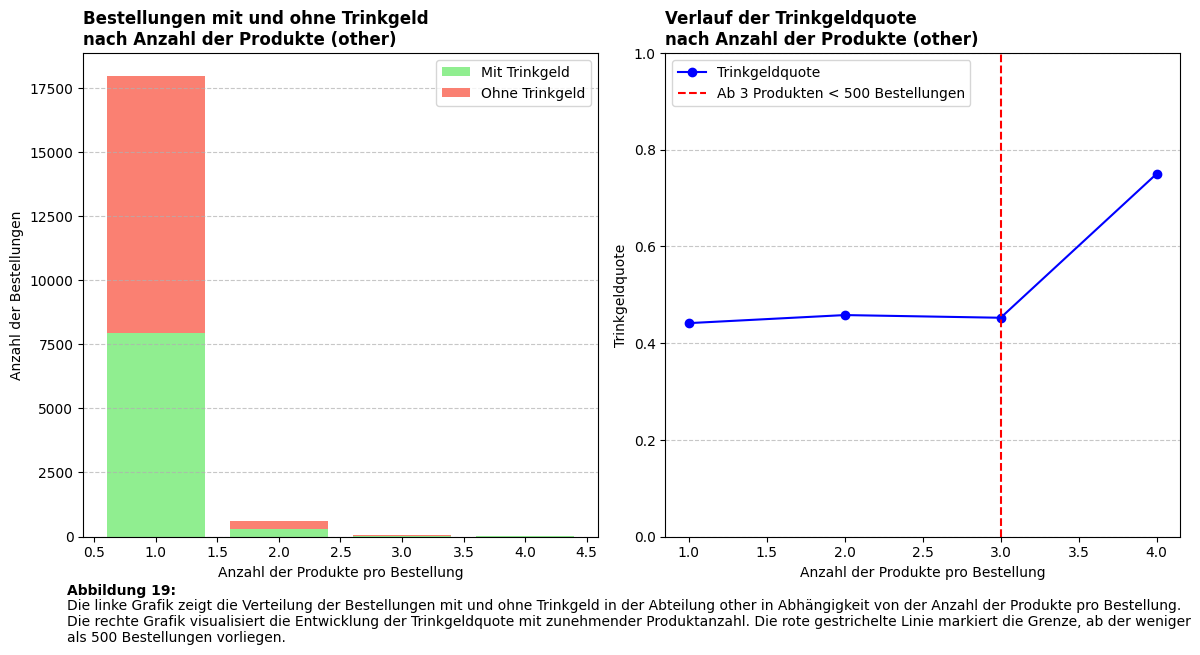

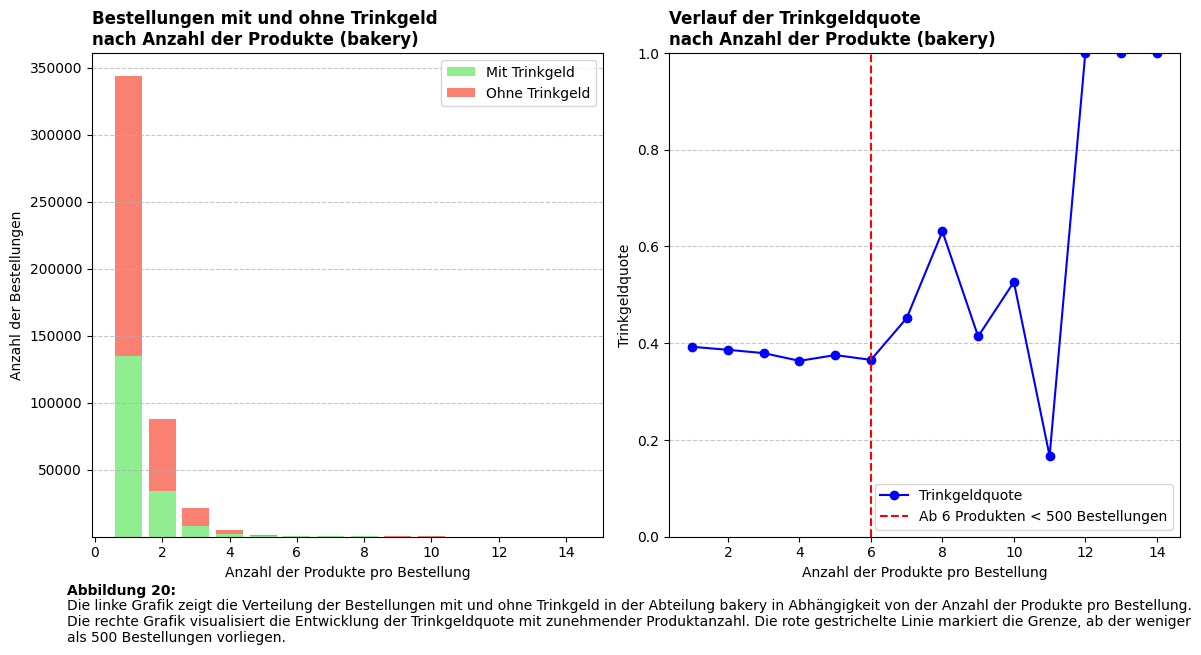

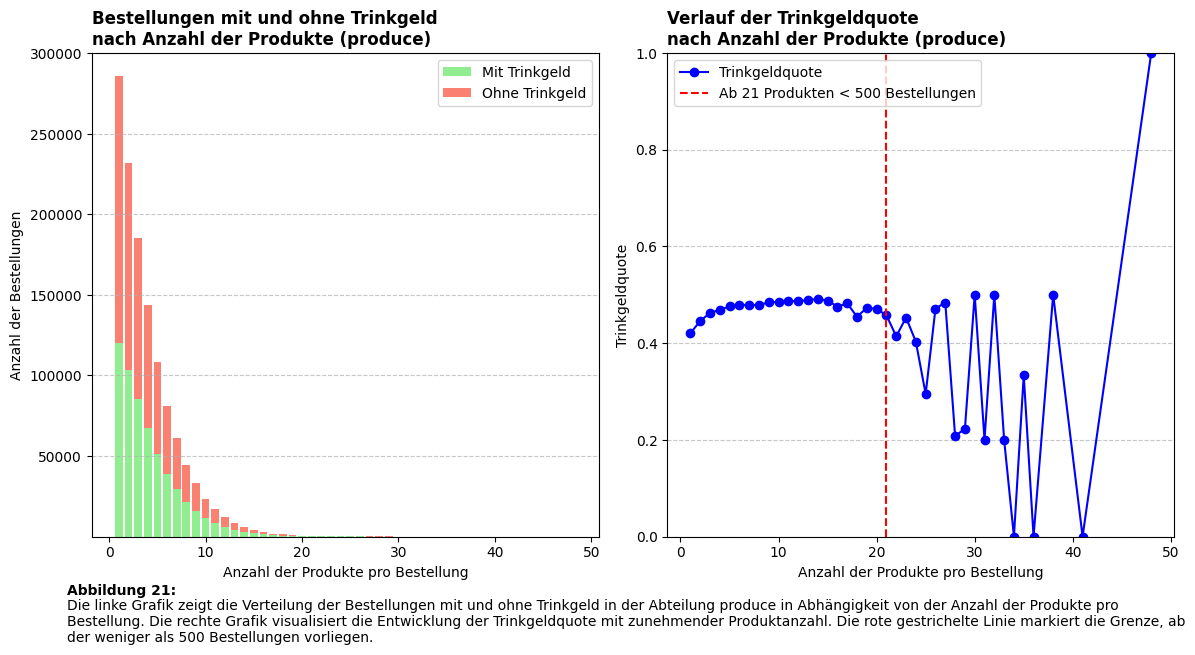

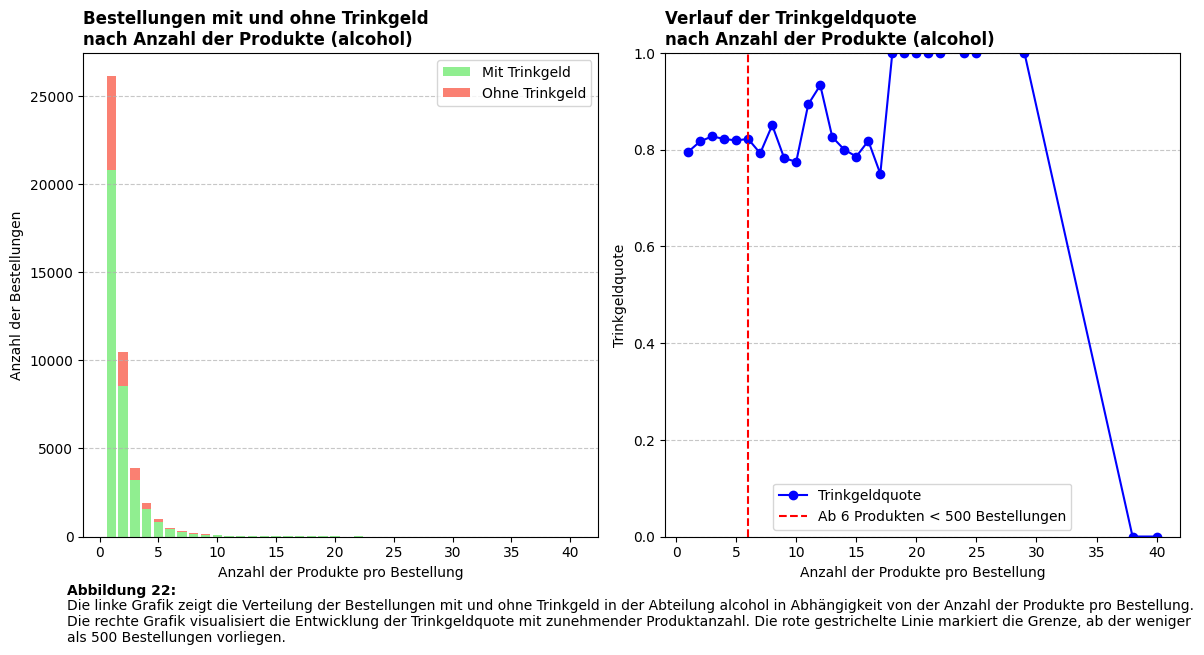

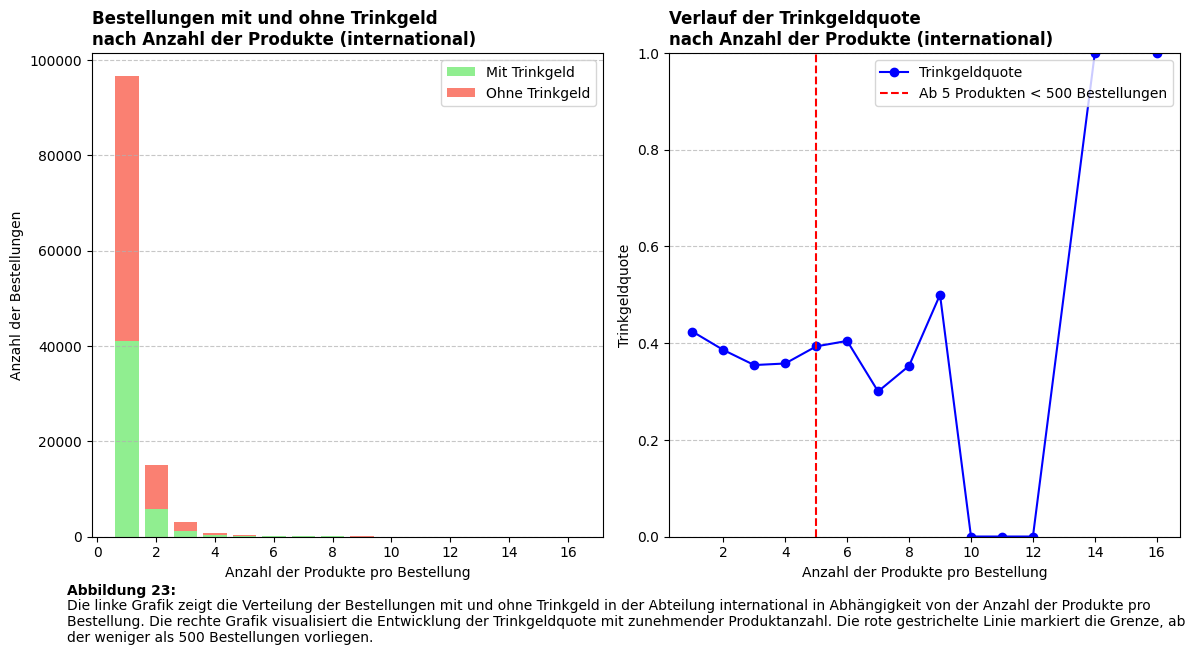

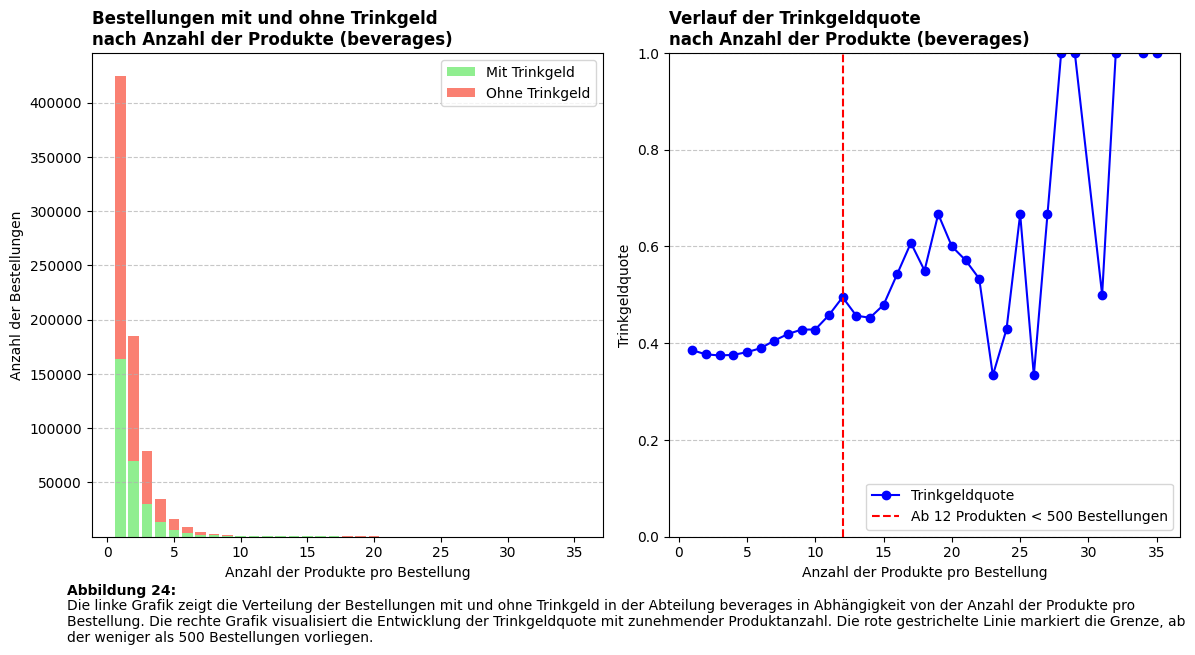

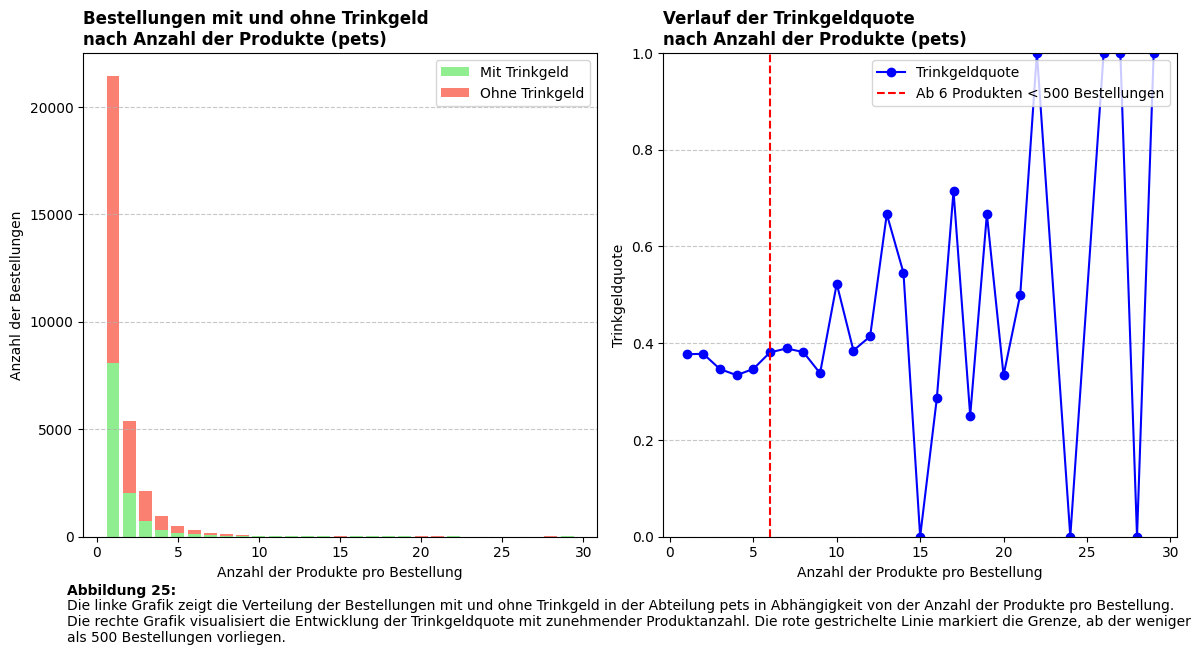

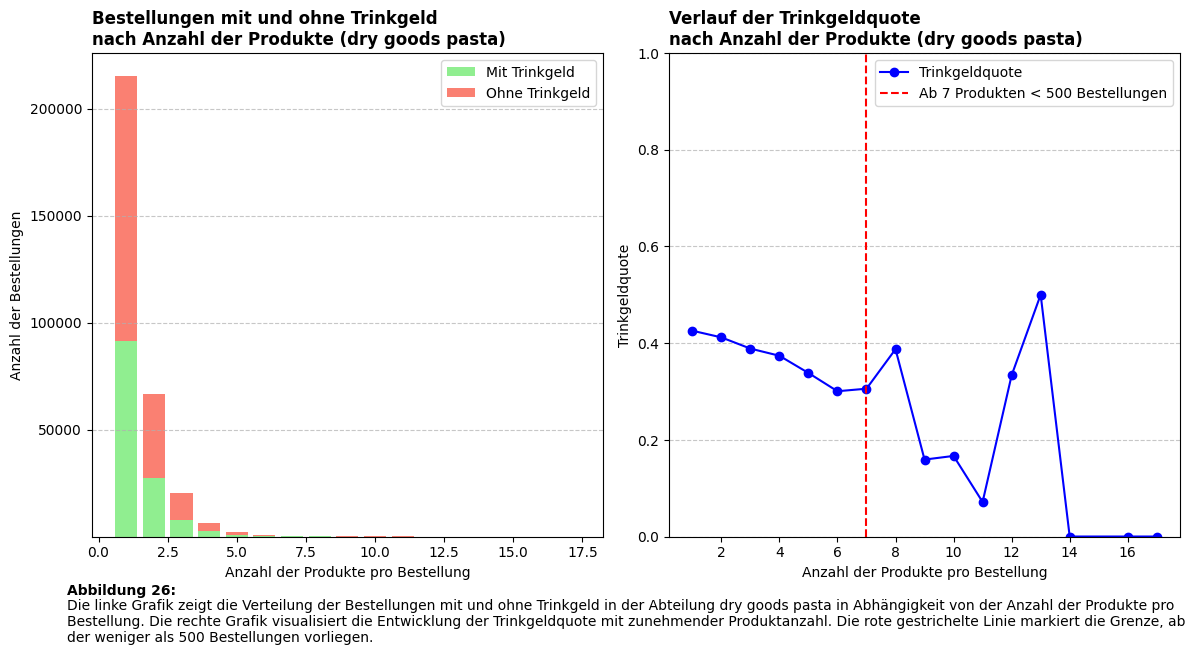

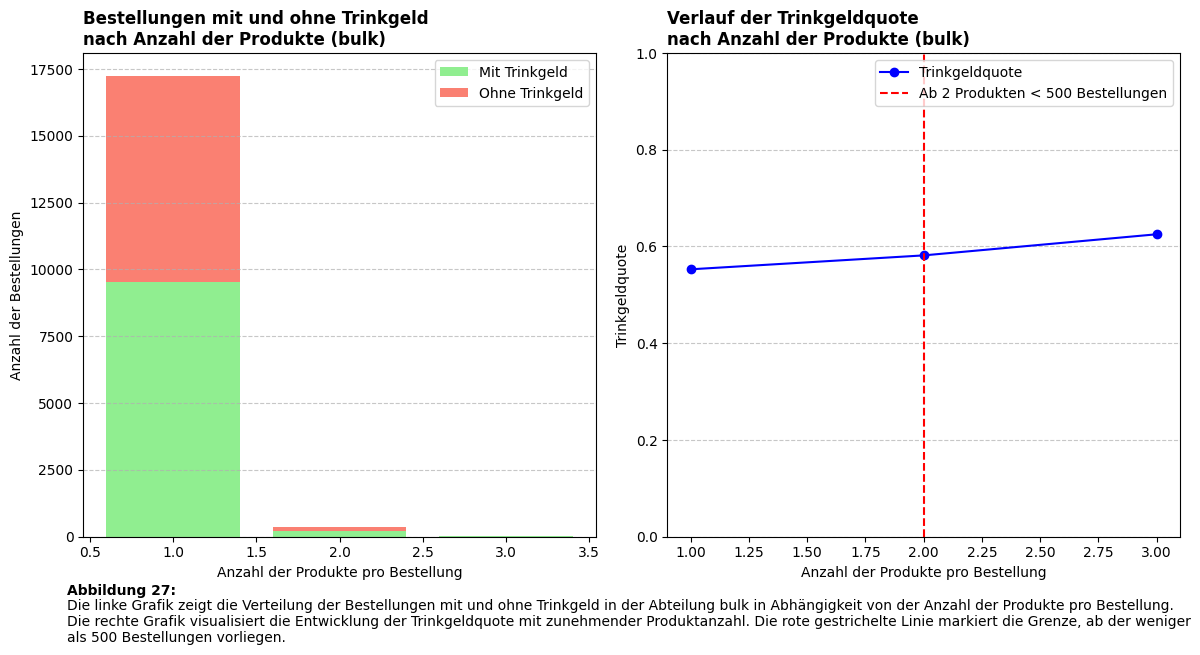

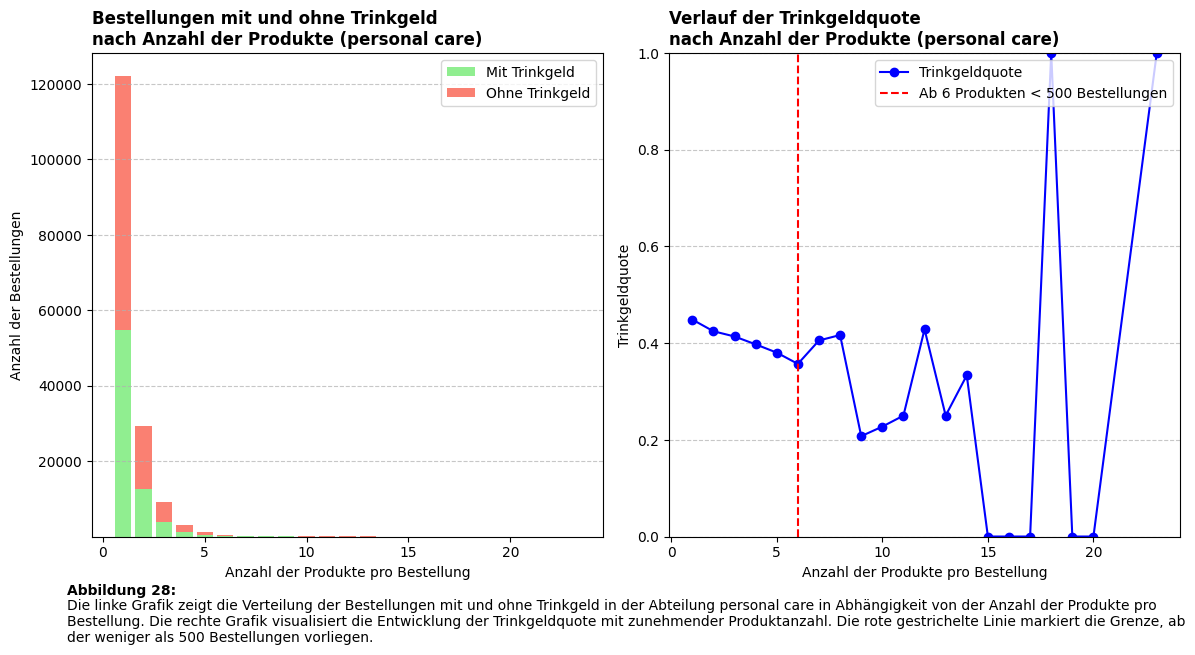

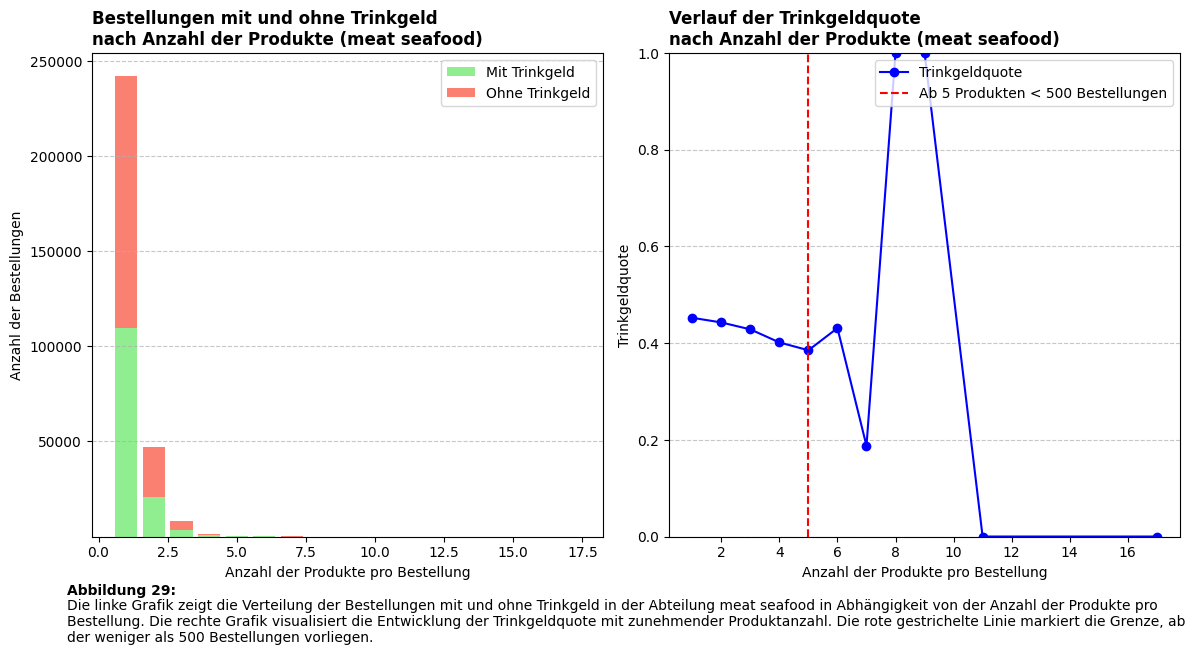

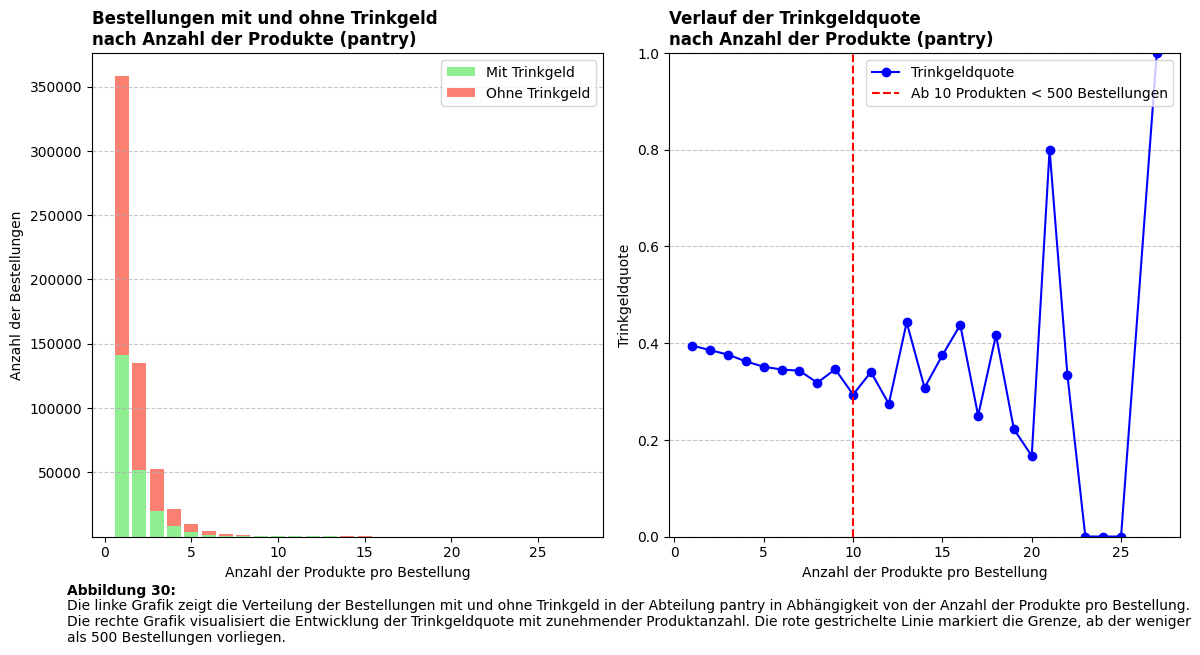

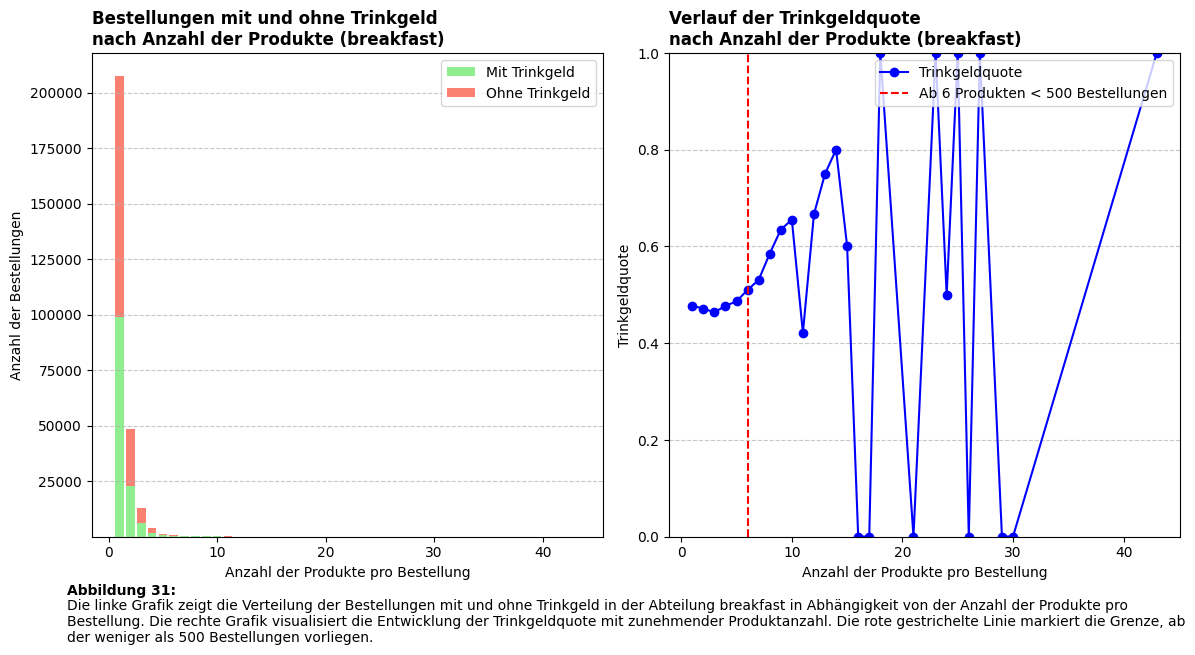

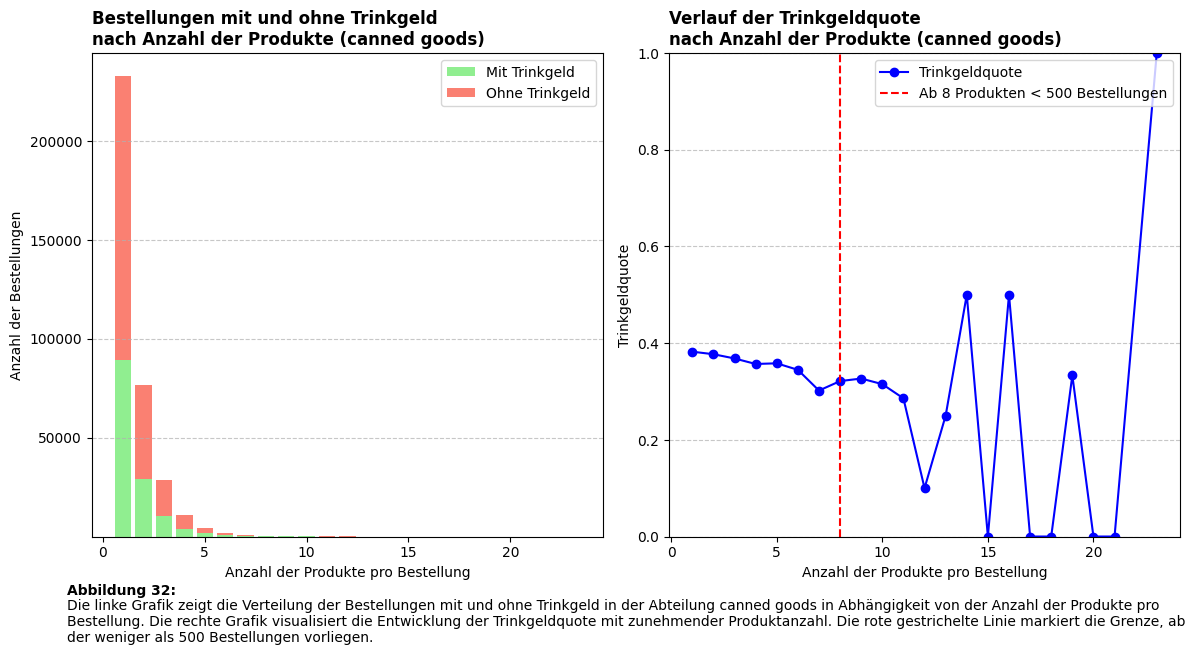

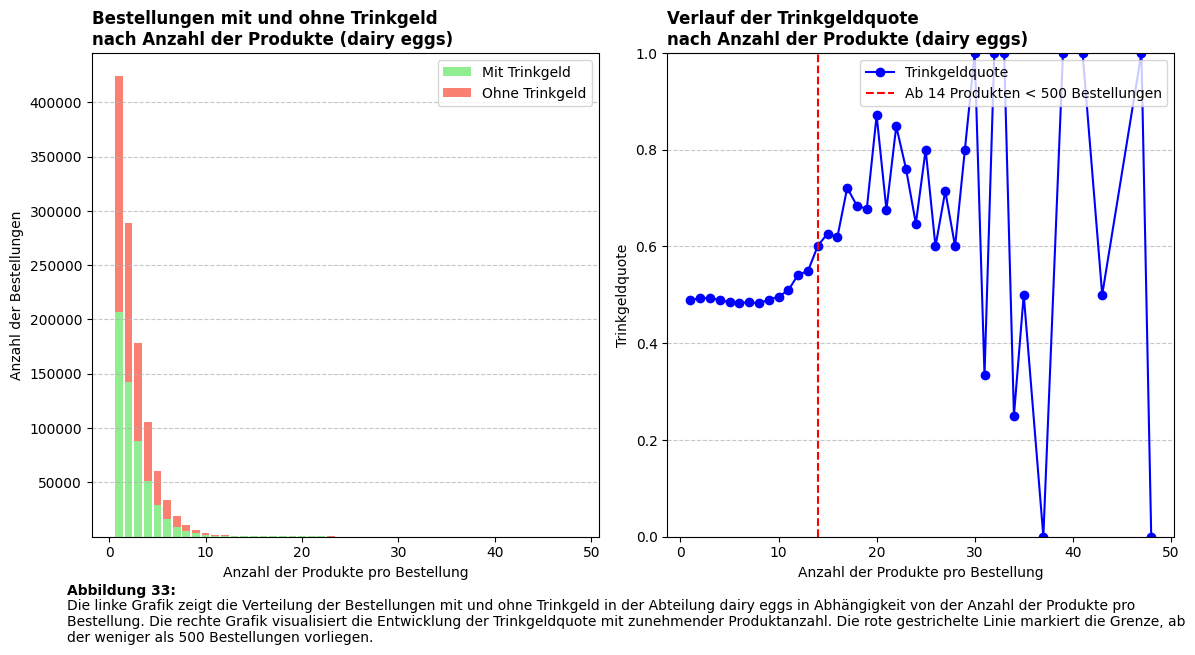

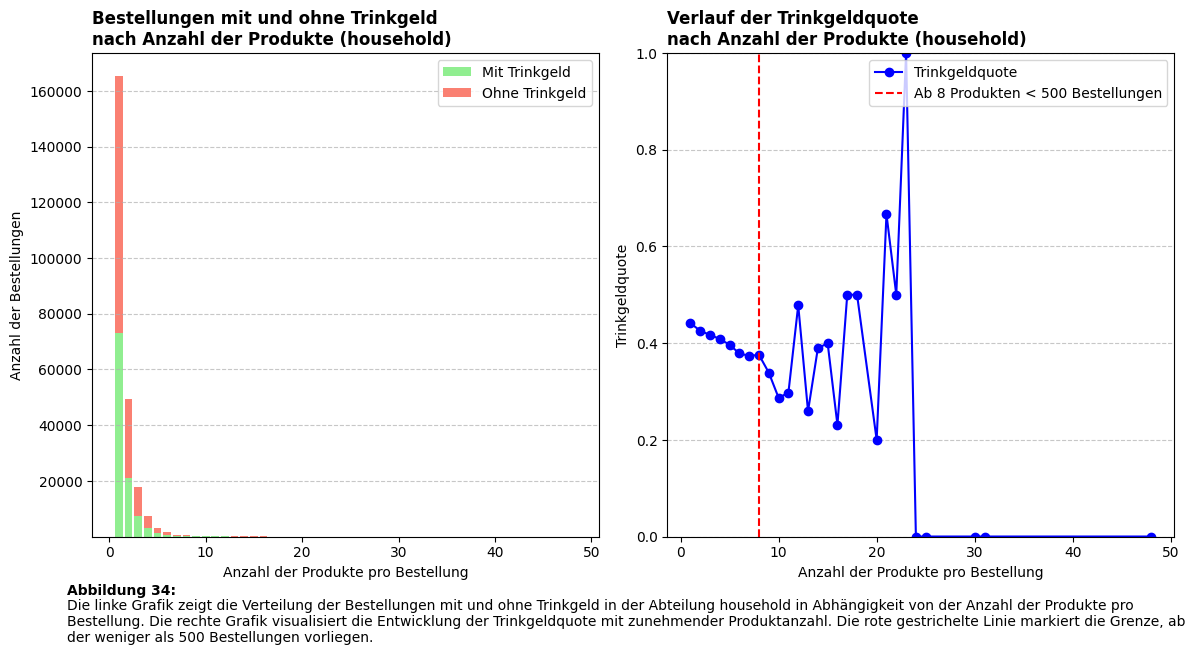

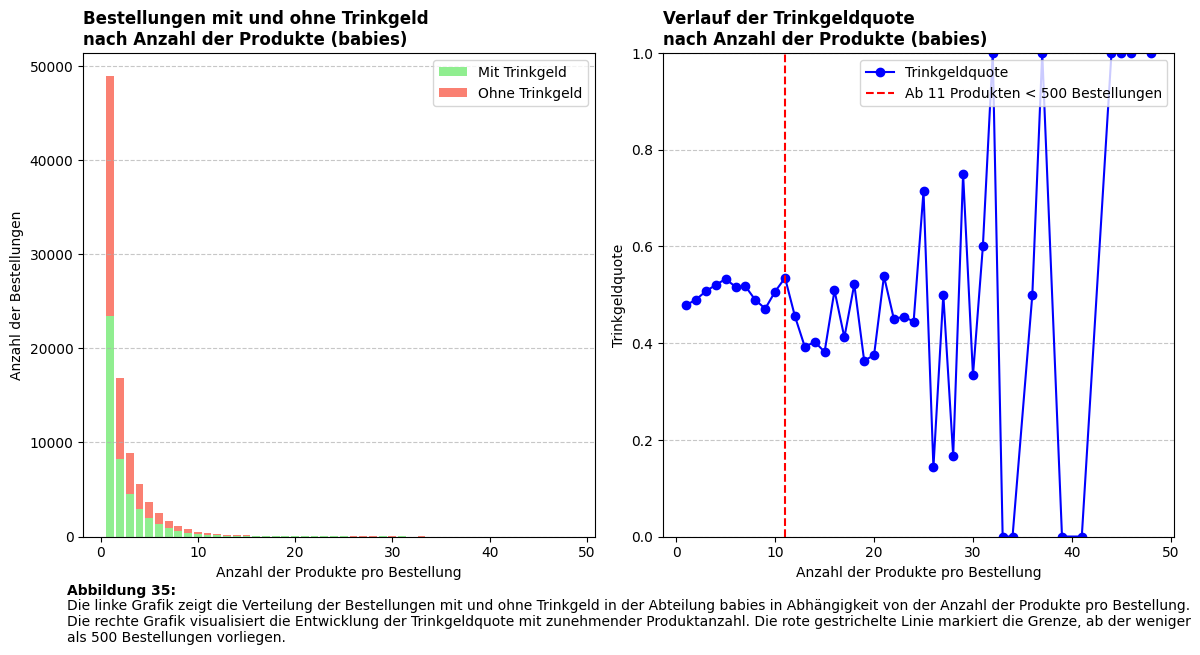

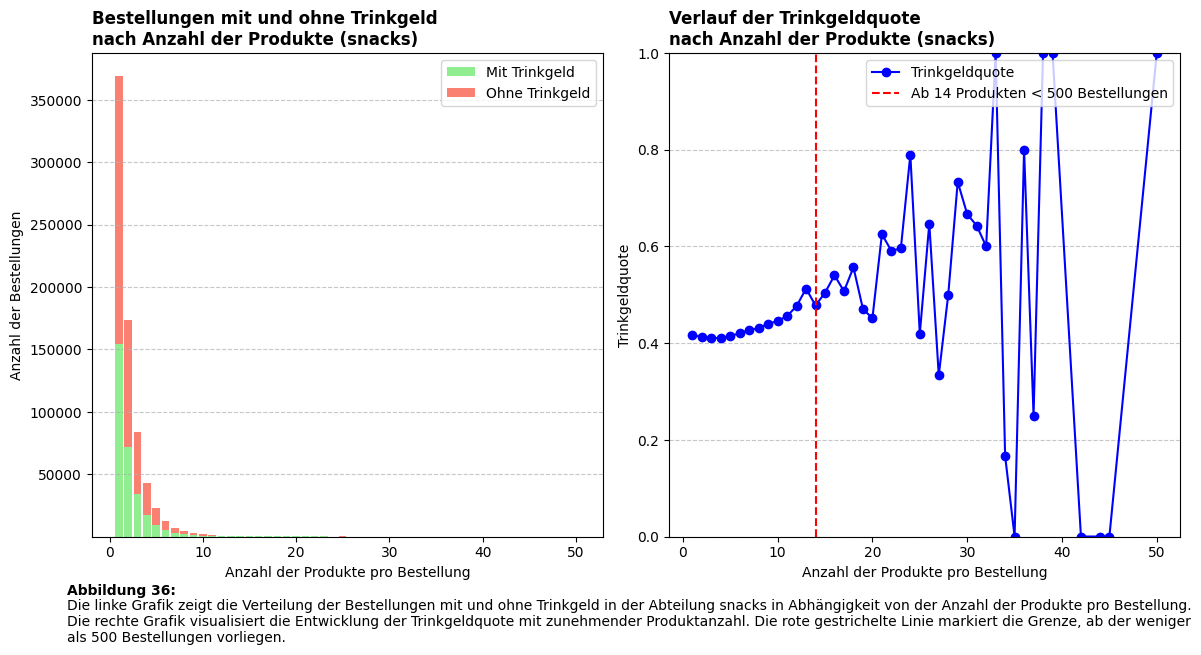

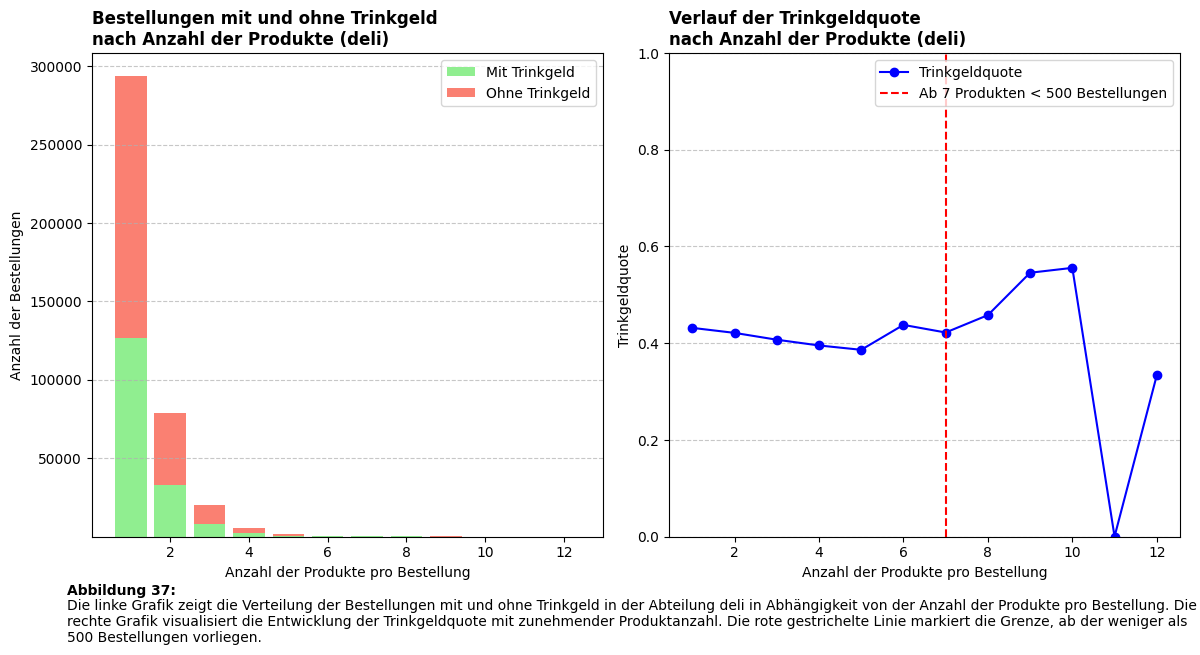

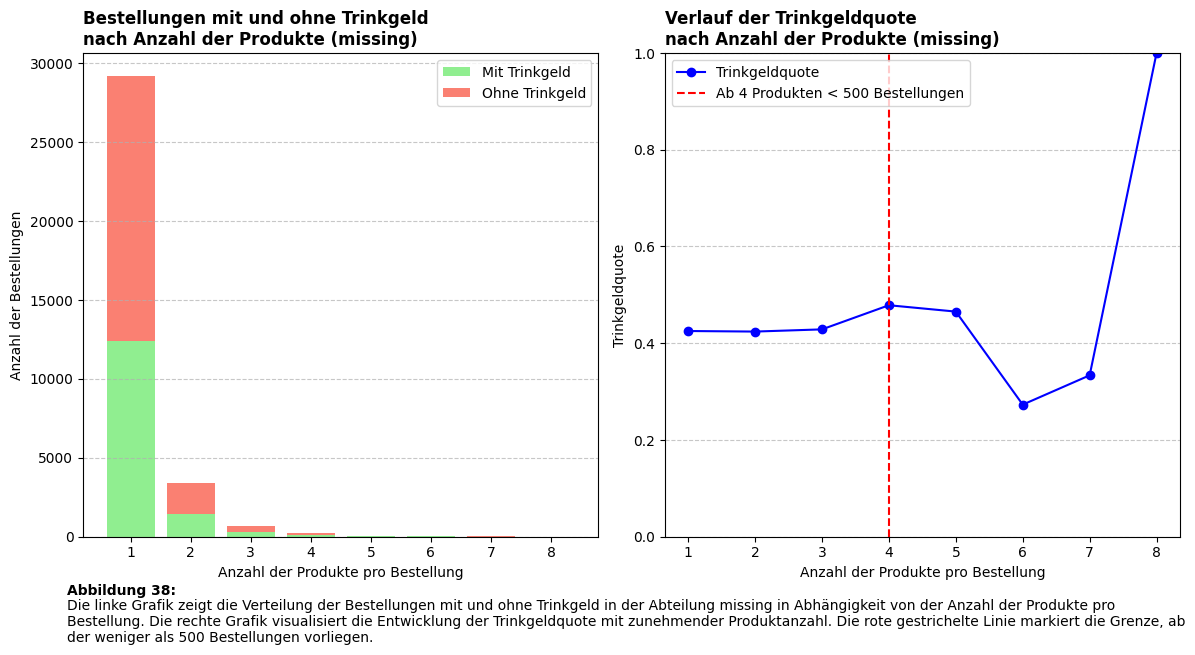

In [ ]:
# plot code
# Query: Alle Abteilungen
departments = session.query(Department.department_name).all()

for department in departments:
    department_name = department[0]  
    
    # Query: Anzahl der Produkte pro Bestellung und ob Trinkgeld gegeben wurde (für eine Abteilung)
    all_orders_item_count_with_tips = session.query(
        Order.order_id,
        func.count(Einkaufskorb.product_id).label('item_count'),
        Order.tips,
        func.count(Order.order_id).label('total_orders')
    ).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
     .join(Product, Product.product_id == Einkaufskorb.product_id) \
     .join(Department, Department.department_id == Product.department_id) \
     .filter(Department.department_name == department_name) \
     .group_by(Order.order_id) \
     .all()

    results = all_orders_item_count_with_tips

    df = pd.DataFrame(results, columns=['order_id', 'item_count', 'tips', 'total_orders'])

    df['with_tips'] = df['tips'].apply(lambda x: 1 if x else 0)
    df['without_tips'] = df['tips'].apply(lambda x: 0 if x else 1)

    df = df[df['item_count'] <= 50]

    agg_df = df.groupby('item_count').agg(
        orders_with_tips=('with_tips', 'sum'),
        orders_without_tips=('without_tips', 'sum'),
        total_orders=('order_id', 'count')
    ).reset_index()

    agg_df['tips_ratio'] = agg_df['orders_with_tips'] / agg_df['total_orders']

    threshold_item_count = agg_df[agg_df['total_orders'] < 500]['item_count'].min()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplots_adjust(left=0.08)

    bar_width = 0.8

    bar_with_tips = ax1.bar(agg_df['item_count'], agg_df['orders_with_tips'], 
                           bar_width, label='Mit Trinkgeld', color='lightgreen')
    bar_without_tips = ax1.bar(agg_df['item_count'], agg_df['orders_without_tips'], 
                              bar_width, bottom=agg_df['orders_with_tips'], 
                              label='Ohne Trinkgeld', color='salmon')

    ax1.set_xlabel('Anzahl der Produkte pro Bestellung')
    ax1.set_ylabel('Anzahl der Bestellungen')
    ax1.set_title(f'Bestellungen mit und ohne Trinkgeld\nnach Anzahl der Produkte ({department_name})', 
                  loc='left', weight='bold')
    ax1.legend()
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)


    ax2.plot(agg_df['item_count'], agg_df['tips_ratio'], 
             marker='o', color='b', label='Trinkgeldquote')
    
    if not pd.isna(threshold_item_count):
        ax2.axvline(x=threshold_item_count, color='red', linestyle='--', 
                    label=f'Ab {threshold_item_count} Produkten < 500 Bestellungen')

    ax2.set_xlabel('Anzahl der Produkte pro Bestellung')
    ax2.set_ylabel('Trinkgeldquote')
    ax2.set_title(f'Verlauf der Trinkgeldquote\nnach Anzahl der Produkte ({department_name})', 
                  loc='left', weight='bold')
    ax2.legend()
    ax2.set_ylim(0, 1)
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


    # Bildunterschrift
    description = f'Die linke Grafik zeigt die Verteilung der Bestellungen mit und ohne Trinkgeld in der Abteilung {department_name} in Abhängigkeit von der Anzahl der Produkte pro Bestellung. Die rechte Grafik visualisiert die Entwicklung der Trinkgeldquote mit zunehmender Produktanzahl. Die rote gestrichelte Linie markiert die Grenze, ab der weniger als 500 Bestellungen vorliegen.'
    fig.text(0.06, 0, f'Abbildung {18+departments.index(department)}:', weight='bold', ha='left')
    fig.text(0.06, -0.075, description, wrap=True)

    plt.tight_layout()
    plt.show()



In [347]:
# Query: Anzahl der Bestellungen mit Bio-Produkten vs. Gesamtanzahl der Bestellungen
orders_with_organic = (
    session.query(Order.order_id)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)  
    .join(Product, Einkaufskorb.product_id == Product.product_id) 
    .filter(Product.product_name.ilike('%organic%'))  
    .distinct()  
    .group_by(Order.order_id)  
    .count()  
)

total_orders = session.query(Order).count()


### 🌱 Analyse des Bio-Produkt-Einflusses auf das Trinkgeldverhalten

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Einfluss von Bio-Produkten auf Trinkgeld</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Ein weiterer interessanter Aspekt unserer Analyse ist der potenzielle Zusammenhang zwischen 
        Bio-Produkten und der Trinkgeldbereitschaft. Die Hypothese: Kunden, die Bio-Produkte bestellen, 
        könnten ein anderes Trinkgeldverhalten aufweisen als Kunden mit konventionellen Produkten.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Untersuchungsaspekte:</strong>
        <ul style="margin: 10px 0;">
            <li>Verteilung von Bio- vs. konventionellen Bestellungen</li>
            <li>Vergleich der Trinkgeldquoten</li>
            <li>Mögliche Korrelation zwischen Bio-Präferenz und Trinkgeldverhalten</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>💭 Hintergrund:</strong>
        <p style="margin: 10px 0;">
            Bio-Produkte werden oft mit erhöhtem Qualitätsbewusstsein und Zahlungsbereitschaft 
            in Verbindung gebracht. Diese Analyse soll zeigen, ob sich dieses Verhalten auch 
            im Trinkgeldverhalten widerspiegelt.
        </p>
    </div>
</div>

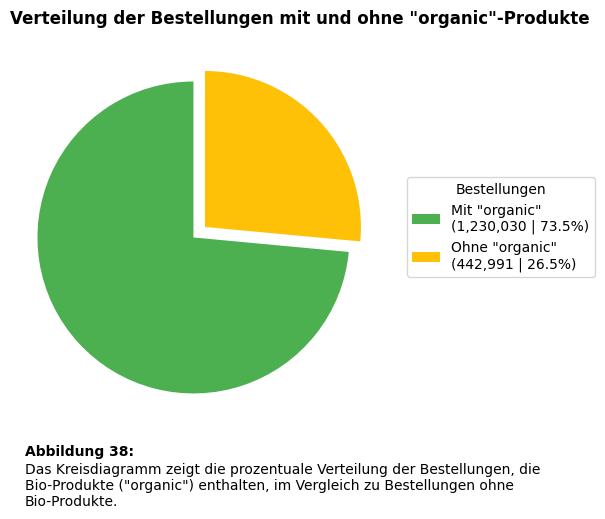

In [353]:
orders_without_organic = total_orders - orders_with_organic

labels = ['Mit "organic"', 'Ohne "organic"']
sizes = [orders_with_organic, orders_without_organic]
colors = ['#4CAF50', '#FFC107']  
explode = (0.1, 0)  

fig, ax = plt.subplots(figsize=(6, 6))
plt.subplots_adjust(left=0.08)

# Berechne die Prozentanteile
percentages = [s/total_orders*100 for s in sizes]
# Erstelle Labels mit absoluten Zahlen und Prozenten
labels_with_values = [f'{labels[i]}\n({sizes[i]:,} | {percentages[i]:.1f}%)' 
                     for i in range(len(labels))]

wedges, texts = ax.pie(sizes, labels=None, colors=colors, explode=explode, startangle=90)

ax.legend(wedges, labels_with_values,
         title="Bestellungen",
         loc="center left",
         bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title('Verteilung der Bestellungen mit und ohne "organic"-Produkte', 
             loc='left', weight='bold')

description = 'Das Kreisdiagramm zeigt die prozentuale Verteilung der Bestellungen, die Bio-Produkte ("organic") enthalten, im Vergleich zu Bestellungen ohne Bio-Produkte.'
fig.text(0.05, 0.1, 'Abbildung 38:', weight='bold', ha='left')
fig.text(0.05, 0.02, description, wrap=True)

plt.tight_layout()
plt.show()

### 💡 Verteilung von Bio-Produkten in Bestellungen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">📊 Hoher Anteil von Bio-Produkten</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>🌱 Zentrale Erkenntnis</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Analyse zeigt eine deutliche Präferenz für Bio-Produkte im Bestellverhalten:
        </p>
        <ul style="margin: 5px 0;">
            <li><strong>73,5%</strong> aller Bestellungen enthalten mindestens ein Bio-Produkt</li>
            <li>Nur <strong>26,5%</strong> der Bestellungen bestehen ausschließlich aus konventionellen Produkten</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>📈 Bedeutung:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Diese deutliche Mehrheit von Bestellungen mit Bio-Produkten bildet eine solide Basis für 
            die weitere Analyse des Zusammenhangs zwischen Bio-Präferenz und Trinkgeldverhalten.
        </p>
    </div>
</div>

In [ ]:
# Vergleichsanalyse: Trinkgeldverhalten bei Bestellungen mit und ohne Bio-Produkte
organic_with_tips = (
    session.query(Order)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .filter(Product.product_name.ilike('%organic%'))
    .filter(Order.tips == True)
    .distinct()
    .count()
)

organic_without_tips = (
    session.query(Order)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .filter(Product.product_name.ilike('%organic%'))
    .filter(Order.tips == False)
    .distinct()
    .count()
)

total_organic_orders = organic_with_tips + organic_without_tips

non_organic_with_tips = (
    session.query(Order)
    .outerjoin(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .outerjoin(Product, Einkaufskorb.product_id == Product.product_id)
    .filter(~Product.product_name.ilike('%organic%'))
    .filter(Order.tips == True)
    .distinct()
    .count()
)

non_organic_without_tips = (
    session.query(Order)
    .outerjoin(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .outerjoin(Product, Einkaufskorb.product_id == Product.product_id)
    .filter(~Product.product_name.ilike('%organic%'))
    .filter(Order.tips == False)
    .distinct()
    .count()
)

total_non_organic_orders = non_organic_with_tips + non_organic_without_tips

tip_probability_organic = organic_with_tips / total_organic_orders if total_organic_orders > 0 else 0
tip_probability_non_organic = non_organic_with_tips / total_non_organic_orders if total_non_organic_orders > 0 else 0


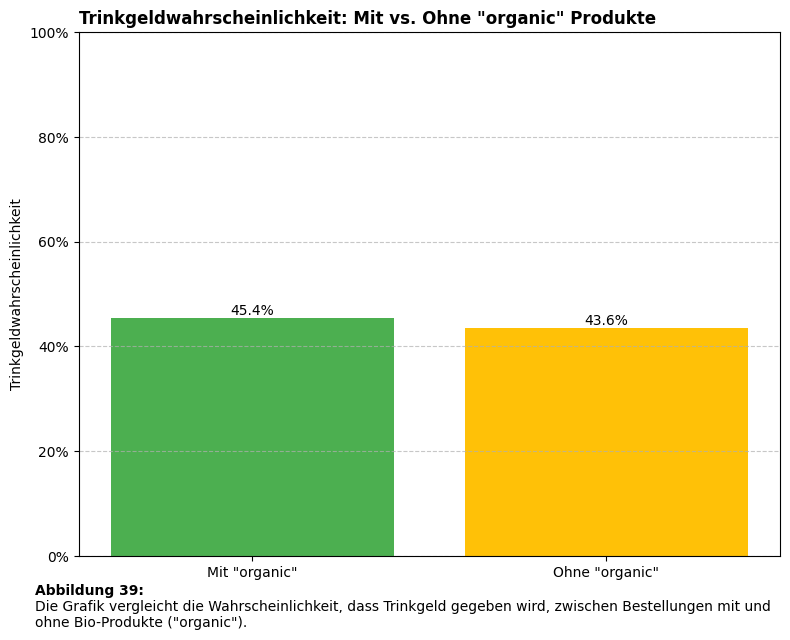

In [354]:
# plot code
labels = ['Mit "organic"', 'Ohne "organic"']
probabilities = [tip_probability_organic, tip_probability_non_organic]
colors = ['#4CAF50', '#FFC107']

fig, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(left=0.08)

bars = ax.bar(labels, probabilities, color=colors)

# Füge Prozentangaben auf den Balken hinzu
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1%}',
            ha='center', va='bottom')

ax.set_ylabel('Trinkgeldwahrscheinlichkeit')
ax.set_title('Trinkgeldwahrscheinlichkeit: Mit vs. Ohne "organic" Produkte', 
             loc='left', weight='bold')
ax.set_ylim(0, 1)  

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

description = 'Die Grafik vergleicht die Wahrscheinlichkeit, dass Trinkgeld gegeben wird, zwischen Bestellungen mit und ohne Bio-Produkte ("organic").'
fig.text(0.05, 0, 'Abbildung 39:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

### 💡 Trinkgeldverhalten bei Bio- vs. konventionellen Bestellungen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Minimale Unterschiede im Trinkgeldverhalten</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Analyseergebnis</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Entgegen möglicher Erwartungen zeigt die Analyse nur marginale Unterschiede in der Trinkgeldwahrscheinlichkeit:
        </p>
        <ul style="margin: 5px 0;">
            <li>Die Unterschiede in der Trinkgeldquote sind minimal</li>
            <li>Bio-Präferenz scheint kein ausschlaggebender Faktor für das Trinkgeldverhalten zu sein</li>
            <li>Das Vorhandensein von Bio-Produkten in der Bestellung hat keinen signifikanten Einfluss auf die Trinkgeldbereitschaft</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>🎯 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Trotz des hohen Anteils von Bio-Bestellungen (73,5%) lässt sich kein nennenswerter 
            Zusammenhang zwischen der Wahl von Bio-Produkten und der Bereitschaft, Trinkgeld zu geben, 
            feststellen. Dies deutet darauf hin, dass das Trinkgeldverhalten von anderen Faktoren 
            stärker beeinflusst wird.
        </p>
    </div>
</div>

### 🔬 Granulare Analyse des Bio-Anteils

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Detailbetrachtung der Bio-Intensität</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Da die binäre Unterscheidung (Bio ja/nein) keine signifikanten Unterschiede im Trinkgeldverhalten 
        zeigt, verfeinern wir unsere Analyse. Wir untersuchen nun, ob der prozentuale Anteil von Bio-Produkten 
        innerhalb einer Bestellung einen Einfluss auf das Trinkgeldverhalten hat.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Analyseansatz:</strong>
        <ul style="margin: 10px 0;">
            <li>Gruppierung der Bestellungen nach Bio-Anteil</li>
            <li>Berechnung der Trinkgeldquote pro Gruppe</li>
            <li>Identifikation möglicher Schwellenwerte oder gradueller Effekte</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Erkenntnisziel:</strong>
        <p style="margin: 10px 0;">
            Diese differenziertere Betrachtung soll aufzeigen, ob ein höherer Bio-Anteil in der 
            Bestellung mit einer veränderten Trinkgeldbereitschaft einhergeht und ob es bestimmte 
            Schwellenwerte gibt, ab denen sich das Trinkgeldverhalten signifikant ändert.
        </p>
    </div>
</div>

In [375]:
from sqlalchemy import func, case, cast, Float

# Abfrage für die Verteilung der Bio-Produkte
organic_distribution = (
    session.query(
        Order.order_id,
        (func.count(case((Product.product_name.ilike('%organic%'), 1))) * 100.0 / 
         func.count(Product.product_id)).label('organic_percentage')
    )
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .group_by(Order.order_id)
    .subquery()
)

# Gruppierung der Ergebnisse
groups = {
    '0%': 0,
    '1-25%': 0,
    '26-50%': 0,
    '51-75%': 0,
    '76-99%': 0,
    '100%': 0
}

results = session.query(
    case(
        
            (organic_distribution.c.organic_percentage == 0, '0%'),
            (organic_distribution.c.organic_percentage <= 25, '1-25%'),
            (organic_distribution.c.organic_percentage <= 50, '26-50%'),
            (organic_distribution.c.organic_percentage <= 75, '51-75%'),
            (organic_distribution.c.organic_percentage < 100, '76-99%'),
            (organic_distribution.c.organic_percentage == 100, '100%')
        
    ).label('group'),
    func.count('*').label('count')
).group_by('group').all()

# Ergebnisse in Dictionary speichern
for group, count in results:
    if group in groups:
        groups[group] = count

# Gesamtanzahl der Bestellungen
total_orders = sum(groups.values())

# Ausgabe der Ergebnisse
print("Verteilung der Bio-Produkte in Bestellungen:")
for group, count in groups.items():
    percentage = (count / total_orders) * 100 if total_orders > 0 else 0
    print(f"{group}: {count} Bestellungen ({percentage:.2f}%)")

Verteilung der Bio-Produkte in Bestellungen:
0%: 442991 Bestellungen (26.48%)
1-25%: 375675 Bestellungen (22.45%)
26-50%: 539189 Bestellungen (32.23%)
51-75%: 237870 Bestellungen (14.22%)
76-99%: 36717 Bestellungen (2.19%)
100%: 40579 Bestellungen (2.43%)


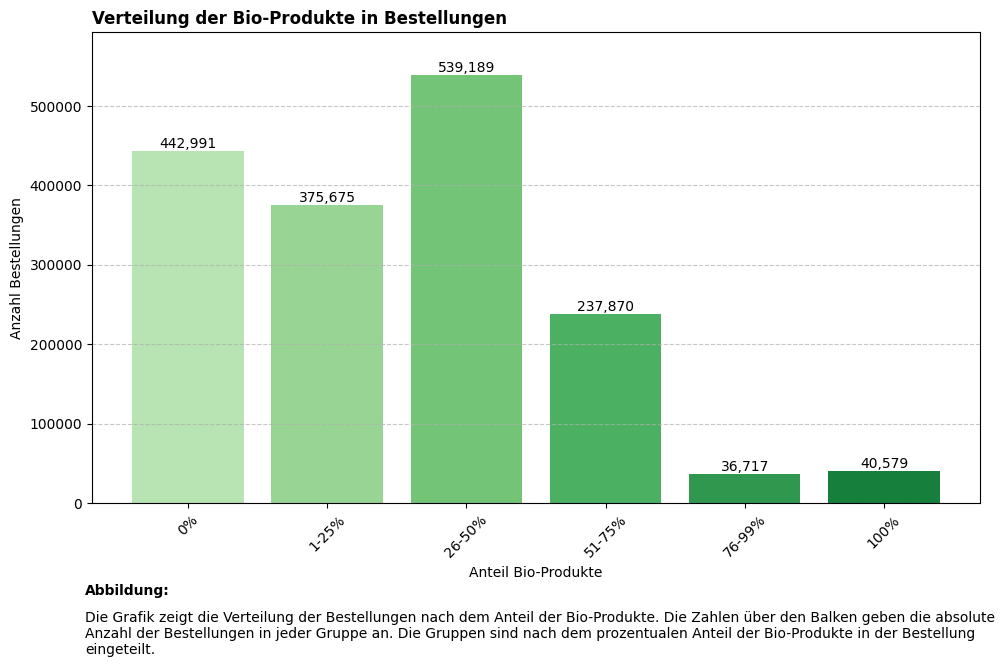

In [376]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.08)

# Daten vorbereiten
group_names = list(groups.keys())
group_values = list(groups.values())

# Farbpalette erstellen (Farbverlauf von hellgrün zu dunkelgrün)
colors = plt.cm.Greens(np.linspace(0.3, 0.8, len(group_names)))

# Balkendiagramm erstellen
bars = ax.bar(group_names, group_values, color=colors)

# Achsentitel und Formatierung
ax.set_ylabel('Anzahl Bestellungen')
ax.set_xlabel('Anteil Bio-Produkte')
ax.set_title('Verteilung der Bio-Produkte in Bestellungen', 
             loc='left', weight='bold')
ax.set_xticks(range(len(group_names)))
ax.set_xticklabels(group_names, rotation=45)

# Grid hinzufügen
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Y-Achse formatieren
max_value = max(group_values)
ax.set_ylim(0, max_value * 1.1)  # 10% Platz für Labels

# Werte über den Balken anzeigen
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height,
            f"{int(height):,}", ha='center', va='bottom', fontsize=10)

# Bildunterschrift
description = ('Die Grafik zeigt die Verteilung der Bestellungen nach dem Anteil der Bio-Produkte. '
              'Die Zahlen über den Balken geben die absolute Anzahl der Bestellungen in jeder Gruppe an. '
              'Die Gruppen sind nach dem prozentualen Anteil der Bio-Produkte in der Bestellung eingeteilt.')

fig.text(0.09, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.09, -0.095, description, wrap=True)

plt.tight_layout()
plt.show()


Trinkgeldwahrscheinlichkeit nach Bio-Anteil:
Gruppe 0%:
  Anzahl Bestellungen: 442991
  Bestellungen mit Trinkgeld: 171310
  Trinkgeldwahrscheinlichkeit: 38.67%

Gruppe 1-25%:
  Anzahl Bestellungen: 375675
  Bestellungen mit Trinkgeld: 160968
  Trinkgeldwahrscheinlichkeit: 42.85%

Gruppe 26-50%:
  Anzahl Bestellungen: 539189
  Bestellungen mit Trinkgeld: 244978
  Trinkgeldwahrscheinlichkeit: 45.43%

Gruppe 51-75%:
  Anzahl Bestellungen: 237870
  Bestellungen mit Trinkgeld: 115561
  Trinkgeldwahrscheinlichkeit: 48.58%

Gruppe 76-99%:
  Anzahl Bestellungen: 36717
  Bestellungen mit Trinkgeld: 19024
  Trinkgeldwahrscheinlichkeit: 51.81%

Gruppe 100%:
  Anzahl Bestellungen: 40579
  Bestellungen mit Trinkgeld: 18272
  Trinkgeldwahrscheinlichkeit: 45.03%



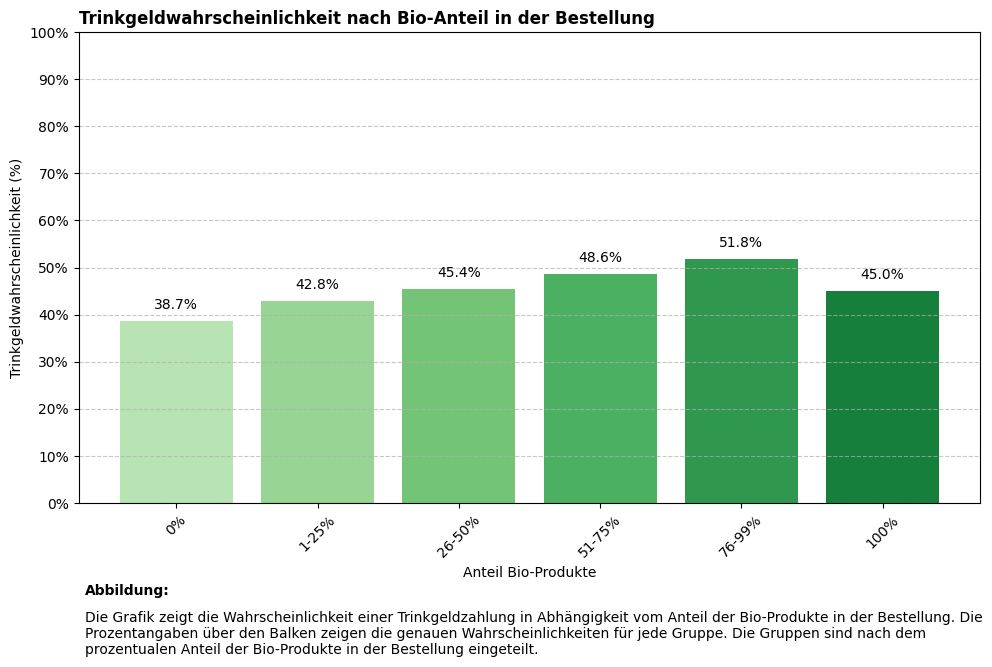

In [373]:
# Hauptanalyse
organic_percentage_subquery = (
    session.query(
        Order.order_id,
        (cast(func.count(case((Product.product_name.ilike('%organic%'), 1))), Float) * 100.0 / 
         cast(func.count(Product.product_id), Float)).label('organic_percentage'),
        Order.tips
    )
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .group_by(Order.order_id, Order.tips)
    .subquery()
)

# Berechne Trinkgeldwahrscheinlichkeit für jede Gruppe
tips_probability = session.query(
    case(
        
            (organic_percentage_subquery.c.organic_percentage == 0, '0%'),
            (and_(
                organic_percentage_subquery.c.organic_percentage > 0,
                organic_percentage_subquery.c.organic_percentage <= 25
            ), '1-25%'),
            (and_(
                organic_percentage_subquery.c.organic_percentage > 25,
                organic_percentage_subquery.c.organic_percentage <= 50
            ), '26-50%'),
            (and_(
                organic_percentage_subquery.c.organic_percentage > 50,
                organic_percentage_subquery.c.organic_percentage <= 75
            ), '51-75%'),
            (and_(
                organic_percentage_subquery.c.organic_percentage > 75,
                organic_percentage_subquery.c.organic_percentage < 100
            ), '76-99%'),
            (organic_percentage_subquery.c.organic_percentage >= 99.99, '100%')  # Angepasst für Rundungsfehler
        
    ).label('group'),
    func.count('*').label('total_orders'),
    func.sum(case((organic_percentage_subquery.c.tips == True, 1), else_=0)).label('orders_with_tips')
).group_by('group').all()

# Sortierung der Ergebnisse
order_dict = {'0%': 0, '1-25%': 1, '26-50%': 2, '51-75%': 3, '76-99%': 4, '100%': 5}
tips_probability = sorted(tips_probability, key=lambda x: order_dict[x[0]])

# Ausgabe der Ergebnisse
print("\nTrinkgeldwahrscheinlichkeit nach Bio-Anteil:")
for group, total, tips in tips_probability:
    probability = (tips / total) if total > 0 else 0
    print(f"Gruppe {group}:")
    print(f"  Anzahl Bestellungen: {total}")
    print(f"  Bestellungen mit Trinkgeld: {tips}")
    print(f"  Trinkgeldwahrscheinlichkeit: {probability:.2%}")
    print()


groups = [result[0] for result in tips_probability]
probabilities = [(result[2]/result[1]) if result[1] > 0 else 0 for result in tips_probability]

# Plot erstellen
fig, ax = plt.subplots(figsize=(10, 6))
plt.subplots_adjust(left=0.08)

# Farbpalette erstellen (Farbverlauf von hellgrün zu dunkelgrün)
colors = plt.cm.Greens(np.linspace(0.3, 0.8, len(groups)))

# Balkendiagramm erstellen
bars = ax.bar(groups, probabilities, color=colors)

# Achsentitel und Formatierung
ax.set_ylabel('Trinkgeldwahrscheinlichkeit (%)')
ax.set_xlabel('Anteil Bio-Produkte')
ax.set_title('Trinkgeldwahrscheinlichkeit nach Bio-Anteil in der Bestellung', 
             loc='left', weight='bold')
ax.set_ylim(0, 1)
ax.set_xticks(range(len(groups)))
ax.set_xticklabels(groups, rotation=45)
ax.set_yticks([i / 10 for i in range(0, 11)])
ax.set_yticklabels([f"{i * 10}%" for i in range(0, 11)])
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Werte über den Balken anzeigen
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
            f"{height:.1%}", ha='center', va='bottom', fontsize=10)

# Bildunterschrift
description = ('Die Grafik zeigt die Wahrscheinlichkeit einer Trinkgeldzahlung in Abhängigkeit vom Anteil der Bio-Produkte in der Bestellung. '
              'Die Prozentangaben über den Balken zeigen die genauen Wahrscheinlichkeiten für jede Gruppe. '
              'Die Gruppen sind nach dem prozentualen Anteil der Bio-Produkte in der Bestellung eingeteilt.')

fig.text(0.09, 0, 'Abbildung 48:', weight='bold', ha='left')
fig.text(0.09, -0.095, description, wrap=True)

plt.tight_layout()
plt.show()

In [284]:
# chi² test code
only_organic_no_tips = only_organic_orders - only_organic_tips_abs
no_organic_no_tips = no_organic_orders - no_organic_tips_abs

observed = np.array([
    [only_organic_tips_abs, only_organic_no_tips],  
    [no_organic_tips_abs, no_organic_no_tips]       
])

row_labels = ['Bio-Produkte', 'Nicht-Bio-Produkte']
col_labels = ['Mit_Trinkgeld', 'Ohne_Trinkgeld']

# DataFrame erstellen
residuals_df = pd.DataFrame(
    observed,
    index=row_labels,
    columns=col_labels
)

In [370]:
# chi² code
observed_data = []
for group, total, tips in tips_probability:
    observed_data.append([tips, total - tips])

observed = np.array(observed_data)

# Chi-Quadrat-Test durchführen
chi2, p_value, dof, expected = chi2_contingency(observed)

# Testergebnisse in Tabelle formatieren
test_results = [
    ["Chi-Quadrat Statistik", f"{chi2:.4f}"],
    ["p-Wert", f"{p_value:.4f}"],
    ["Freiheitsgrade", dof]
]

print("\nKontingenztabelle:")
contingency_table = []
for i, (group, total, tips) in enumerate(tips_probability):
    contingency_table.append([
        group,
        tips,
        total - tips,
        total
    ])

print(tabulate(contingency_table, 
              headers=["Gruppe", "Mit Trinkgeld", "Ohne Trinkgeld", "Gesamt"], 
              tablefmt="fancy_grid", numalign="right"))

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value:.4f}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Bio-Anteil und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value:.4f}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Bio-Anteil und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))



Kontingenztabelle:
╒══════════╤═════════════════╤══════════════════╤══════════╕
│ Gruppe   │   Mit Trinkgeld │   Ohne Trinkgeld │   Gesamt │
╞══════════╪═════════════════╪══════════════════╪══════════╡
│ 0%       │          171310 │           271681 │   442991 │
├──────────┼─────────────────┼──────────────────┼──────────┤
│ 1-25%    │          160968 │           214707 │   375675 │
├──────────┼─────────────────┼──────────────────┼──────────┤
│ 26-50%   │          244978 │           294211 │   539189 │
├──────────┼─────────────────┼──────────────────┼──────────┤
│ 51-75%   │          115561 │           122309 │   237870 │
├──────────┼─────────────────┼──────────────────┼──────────┤
│ 76-99%   │           19024 │            17693 │    36717 │
├──────────┼─────────────────┼──────────────────┼──────────┤
│ 100%     │           18272 │            22307 │    40579 │
╘══════════╧═════════════════╧══════════════════╧══════════╛

Chi-Quadrat Testergebnisse:
╒═══════════════════════╤═════════╕


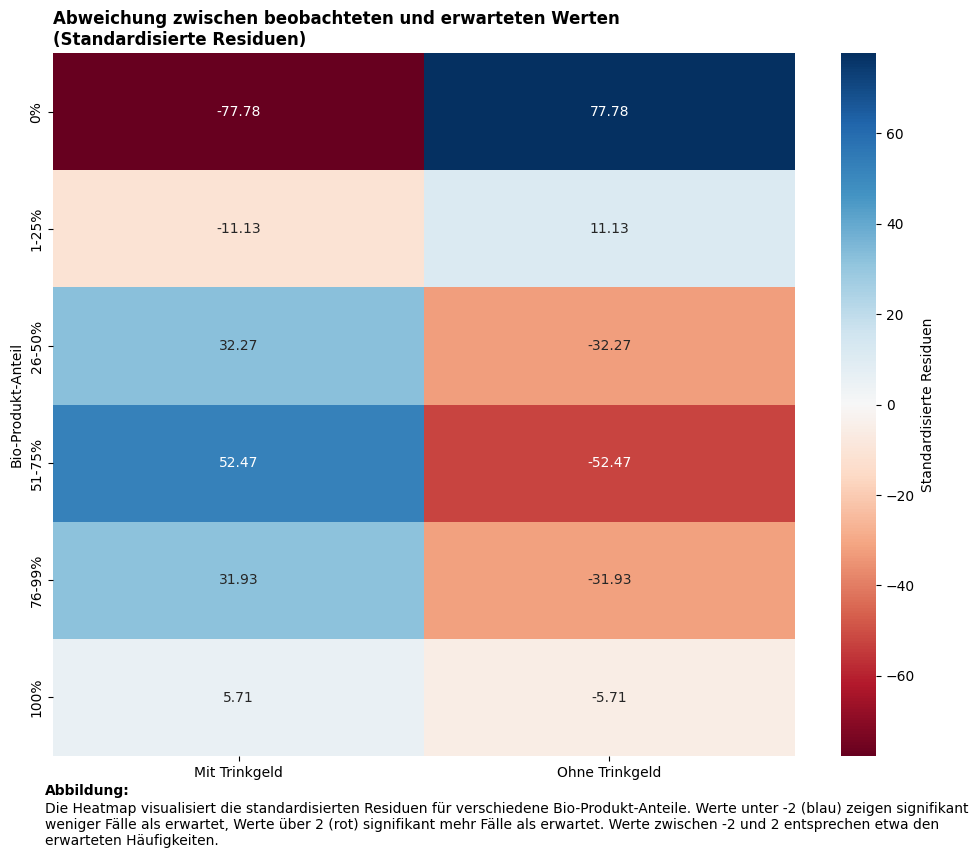

In [372]:
# plot code
observed_matrix = []
group_labels = []
for group, total, tips in tips_probability:
    observed_matrix.append([tips, total - tips])
    group_labels.append(group)

observed = np.array(observed_matrix)
col_labels = ['Mit Trinkgeld', 'Ohne Trinkgeld']

# Chi-Quadrat-Test und Residuen berechnen
chi2, p_value, dof, expected = chi2_contingency(observed)

# Korrigierte standardisierte Residuen berechnen
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.sum()

corrected_residuals = np.zeros_like(observed, dtype=float)
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        E = expected[i, j]
        O = observed[i, j]
        correction = np.sqrt((1 - row_totals[i]/grand_total) *
                           (1 - col_totals[j]/grand_total))
        corrected_residuals[i, j] = (O - E) / (np.sqrt(E) * correction)

# DataFrame für die Residuen erstellen
residuals_df = pd.DataFrame(
    corrected_residuals,
    index=group_labels,
    columns=col_labels
)

# Heatmap erstellen
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplots_adjust(left=0.08)

# Anpassung der Farbskala basierend auf den maximalen absoluten Werten
max_abs_value = np.max(np.abs(corrected_residuals))
vmin = -max_abs_value
vmax = max_abs_value

sns.heatmap(residuals_df,
            annot=True,
            cmap='RdBu',
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardisierte Residuen'},
            vmin=vmin,
            vmax=vmax,
            ax=ax)

ax.set_title('Abweichung zwischen beobachteten und erwarteten Werten\n(Standardisierte Residuen)',
             loc='left',
             weight='bold')

# Beschreibung anpassen
description = ('Die Heatmap visualisiert die standardisierten Residuen für verschiedene Bio-Produkt-Anteile. '
              'Werte unter -2 (blau) zeigen signifikant weniger Fälle als erwartet, '
              'Werte über 2 (rot) signifikant mehr Fälle als erwartet. '
              'Werte zwischen -2 und 2 entsprechen etwa den erwarteten Häufigkeiten.')

# Textposition und -formatierung
fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

# Y-Achsen-Label anpassen
ax.set_ylabel('Bio-Produkt-Anteil')

plt.tight_layout()
plt.show()

### 2) Analyse des Trinkgeldverhaltens des Kunden

In [ ]:
# Benutzerstatistiken: Gesamtbestellungen, Bestellungen mit Trinkgeld und durchschnittliche Bestellgröße pro Benutzer
user_stats = (
    session.query(
        Order.user_id,
        func.count(Order.order_id).label('total_orders'), 
        func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')  
    )
    .group_by(Order.user_id)
    .order_by(Order.user_id)
    .all()
)

avg_order_size_subquery = (
    session.query(
        Order.user_id,
        func.count(Einkaufskorb.product_id).label('order_size')
    )
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .group_by(Order.order_id)
).subquery()

avg_order_size = (
    session.query(
        avg_order_size_subquery.c.user_id,
        func.avg(avg_order_size_subquery.c.order_size).label('avg_order_size')
    )
    .group_by(avg_order_size_subquery.c.user_id)
    .order_by(avg_order_size_subquery.c.user_id)
    .all()
)

avg_order_size_df = pd.DataFrame(avg_order_size, columns=['user_id', 'avg_order_size'])

user_stats_df = pd.DataFrame(user_stats, columns=['user_id', 'total_orders', 'orders_with_tips'])

user_stats_df['orders_without_tips'] = user_stats_df['total_orders'] - user_stats_df['orders_with_tips']

user_stats_df = user_stats_df.merge(avg_order_size_df, on='user_id')

user_stats_df['order_group'] = pd.cut(user_stats_df['total_orders'], bins=range(1, 102, 10), right=False)
user_stats_df['item_count_group'] = pd.cut(user_stats_df['avg_order_size'], bins=range(1, 32, 3), right=False)

grouped_stats_df_item_count = user_stats_df.groupby('item_count_group', observed=True).agg(
    orders_with_tips=('orders_with_tips', 'sum'),
    orders_without_tips=('orders_without_tips', 'sum'),
    total_orders=('total_orders', 'sum')
).reset_index()

grouped_stats_df = user_stats_df.groupby('order_group', observed=True).agg(
    orders_with_tips=('orders_with_tips', 'sum'),
    orders_without_tips=('orders_without_tips', 'sum'),
    total_orders=('total_orders', 'sum')
).reset_index()

grouped_stats_df['tips_ratio'] = grouped_stats_df['orders_with_tips'] / grouped_stats_df['total_orders']
grouped_stats_df_item_count['tips_ratio'] = grouped_stats_df_item_count['orders_with_tips'] / grouped_stats_df_item_count['total_orders']
# 


In [299]:
grouped_stats_df

order_group  orders_with_tips  orders_without_tips  total_orders  tips_ratio
0     [1, 11)             89983               236698        326681    0.275446
1    [11, 21)            133246               226480        359726    0.370410
2    [21, 31)            122669               141444        264113    0.464457
3    [31, 41)            103809                88585        192394    0.539565
4    [41, 51)             91546                67904        159450    0.574136
5    [51, 61)             64700                49222        113922    0.567932
6    [61, 71)             39767                34737         74504    0.533757
7    [71, 81)             25089                25303         50392    0.497877
8    [81, 91)             19023                19412         38435    0.494940
9   [91, 101)             40281                53123         93404    0.431256

In [300]:
grouped_stats_df_item_count

item_count_group  orders_with_tips  orders_without_tips  total_orders  \
0           [1, 4)             65194               110654        175848   
1           [4, 7)            154210               199935        354145   
2          [7, 10)            185093               226977        412070   
3         [10, 13)            141483               170454        311937   
4         [13, 16)             84475               103825        188300   
5         [16, 19)             47323                59990        107313   
6         [19, 22)             26517                33158         59675   
7         [22, 25)             12662                18285         30947   
8         [25, 28)              6394                 9226         15620   
9         [28, 31)              3439                 5451          8890   

   tips_ratio  
0    0.370741  
1    0.435443  
2    0.449179  
3    0.453563  
4    0.448619  
5    0.440981  
6    0.444357  
7    0.409151  
8    0.409347  
9    0.386839

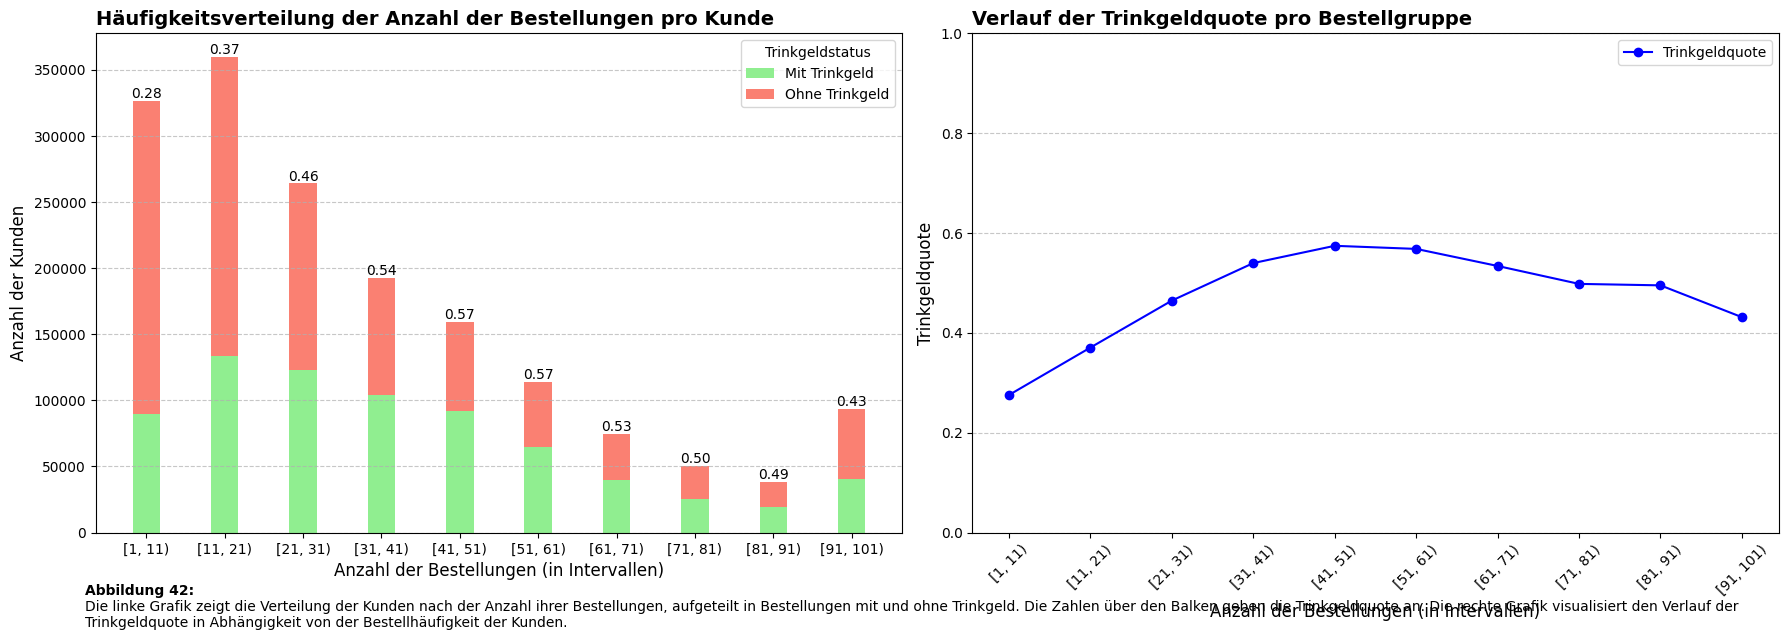

In [301]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Linker Plot: Gestapelte Balkendiagramme
bars_with_tips = ax1.bar(grouped_stats_df['order_group'].astype(str), grouped_stats_df['orders_with_tips'], 
                         width=0.35, color='lightgreen', label='Mit Trinkgeld')
bars_without_tips = ax1.bar(grouped_stats_df['order_group'].astype(str), grouped_stats_df['orders_without_tips'], 
                            width=0.35, bottom=grouped_stats_df['orders_with_tips'], 
                            color='salmon', label='Ohne Trinkgeld')

# Quotienten anzeigen
for i, rect in enumerate(bars_with_tips):
    total_height = rect.get_height() + bars_without_tips[i].get_height()
    ratio = grouped_stats_df['tips_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, total_height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom', fontsize=10)

# Formatierung linker Plot
ax1.set_title('Häufigkeitsverteilung der Anzahl der Bestellungen pro Kunde', 
              loc='left', weight='bold', fontsize=14)
ax1.set_xlabel('Anzahl der Bestellungen (in Intervallen)', fontsize=12)
ax1.set_ylabel('Anzahl der Kunden', fontsize=12)
ax1.legend(title='Trinkgeldstatus')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)


# Rechter Plot: Liniendiagramm
ax2.plot(grouped_stats_df['order_group'].astype(str), grouped_stats_df['tips_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote pro Bestellgruppe', 
              loc='left', weight='bold', fontsize=14)
ax2.set_xlabel('Anzahl der Bestellungen (in Intervallen)', fontsize=12)
ax2.set_ylabel('Trinkgeldquote', fontsize=12)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


# Bildunterschrift
description = 'Die linke Grafik zeigt die Verteilung der Kunden nach der Anzahl ihrer Bestellungen, aufgeteilt in Bestellungen mit und ohne Trinkgeld. Die Zahlen über den Balken geben die Trinkgeldquote an. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote in Abhängigkeit von der Bestellhäufigkeit der Kunden.'
fig.text(0.05, 0, 'Abbildung 42:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [302]:
# Stelle sicher, dass 'order_group' eine reguläre Spalte ist (nicht der Index)
grouped_stats_df.reset_index(inplace=True)

# Setze 'order_group' als Index
crosstab = grouped_stats_df.set_index('order_group')[['orders_with_tips', 'orders_without_tips']]


In [303]:
# chi² test code
chi2, p, dof, expected = chi2_contingency(crosstab)

test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p_value}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))



Chi-Quadrat Testergebnisse:
╒═══════════════════════╤═════════╕
│ Metrik                │    Wert │
╞═══════════════════════╪═════════╡
│ Chi-Quadrat Statistik │ 74451.7 │
├───────────────────────┼─────────┤
│ p-Wert                │       0 │
├───────────────────────┼─────────┤
│ Freiheitsgrade        │       9 │
╘═══════════════════════╧═════════╛

Interpretation:
╒══════════════════╤═══════════════════════════════════════════════╕
│                  │                                               │
╞══════════════════╪═══════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang        │
├──────────────────┼───────────────────────────────────────────────┤
│ Begründung       │ p-Wert (0.0) < Signifikanzniveau (0.05)       │
├──────────────────┼───────────────────────────────────────────────┤
│ Schlussfolgerung │ Department und Trinkgeldvergabe sind abhängig │
╘══════════════════╧═══════════════════════════════════════════════╛


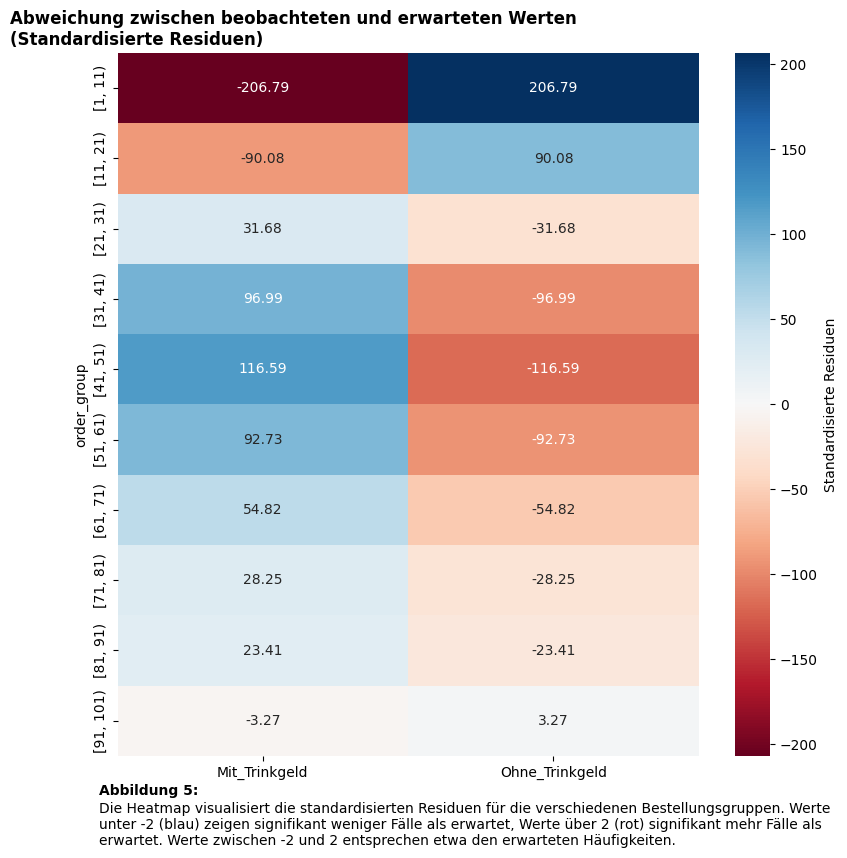

In [304]:
# plot code
observed = crosstab[['orders_with_tips', 'orders_without_tips']].values

chi2, p_value, dof, expected = chi2_contingency(observed)

row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.sum()

corrected_residuals = np.zeros_like(observed, dtype=float)
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        E = expected[i, j]
        O = observed[i, j]
        correction = np.sqrt((1 - row_totals[i]/grand_total) *
                           (1 - col_totals[j]/grand_total))
        corrected_residuals[i, j] = (O - E) / (np.sqrt(E) * correction)

residuals_df = pd.DataFrame(
    corrected_residuals,
    index=crosstab.index,  
    columns=['Mit_Trinkgeld', 'Ohne_Trinkgeld']
)

fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.08)

sns.heatmap(residuals_df,
            annot=True,
            cmap='RdBu',
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardisierte Residuen'},
            ax=ax)

ax.set_title('Abweichung zwischen beobachteten und erwarteten Werten\n(Standardisierte Residuen)',
             loc='left',
             weight='bold',
             x=-0.185)

description = 'Die Heatmap visualisiert die standardisierten Residuen für die verschiedenen Bestellungsgruppen. Werte unter -2 (blau) zeigen signifikant weniger Fälle als erwartet, Werte über 2 (rot) signifikant mehr Fälle als erwartet. Werte zwischen -2 und 2 entsprechen etwa den erwarteten Häufigkeiten.'
fig.text(0.05, 0, 'Abbildung 5:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

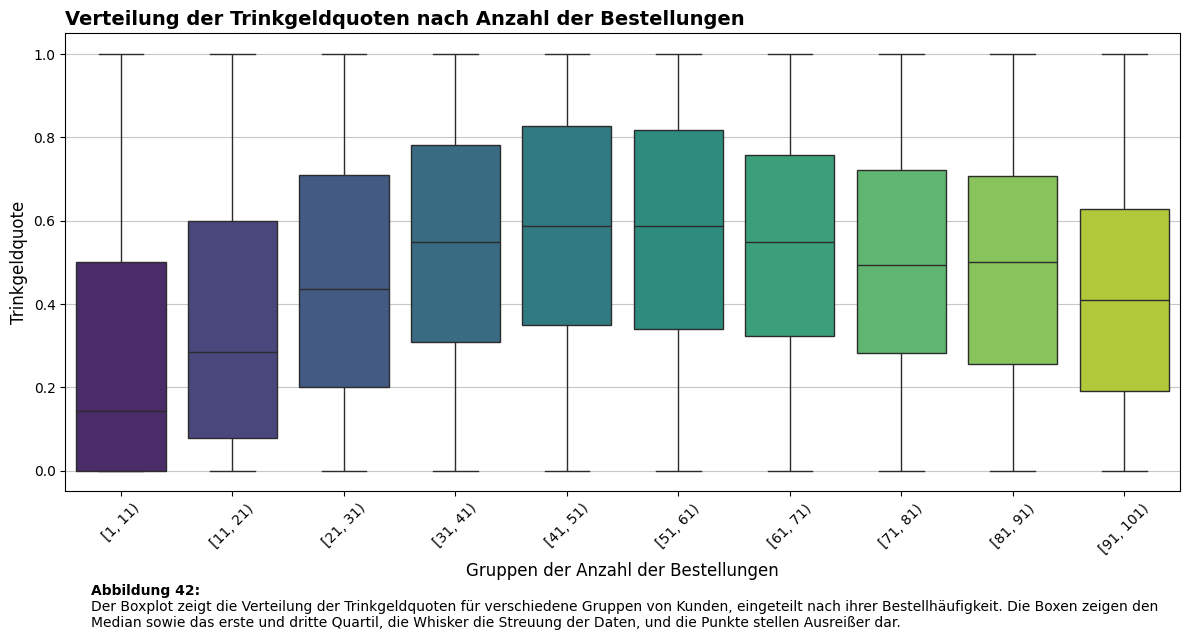

/tmp/ipykernel_12741/2661236874.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = user_stats_df.groupby('order_group')['tip_ratio'].describe().reset_index()


| order_group   |   count |     mean |      std |   min |       25% |      50% |      75% |   max |
|:--------------|--------:|---------:|---------:|------:|----------:|---------:|---------:|------:|
| [1, 11)       |   53685 | 0.268971 | 0.329745 |     0 | 0         | 0.142857 | 0.5      |     1 |
| [11, 21)      |   24482 | 0.364814 | 0.319921 |     0 | 0.0785256 | 0.285714 | 0.6      |     1 |
| [21, 31)      |   10618 | 0.461799 | 0.306749 |     0 | 0.2       | 0.434783 | 0.708333 |     1 |
| [31, 41)      |    5491 | 0.538614 | 0.297895 |     0 | 0.307692  | 0.548387 | 0.78125  |     1 |
| [41, 51)      |    3537 | 0.57336  | 0.295694 |     0 | 0.348837  | 0.586957 | 0.826087 |     1 |
| [51, 61)      |    2072 | 0.56848  | 0.294252 |     0 | 0.339286  | 0.586207 | 0.818182 |     1 |
| [61, 71)      |    1147 | 0.534291 | 0.285655 |     0 | 0.322581  | 0.548387 | 0.757576 |     1 |
| [71, 81)      |     669 | 0.497768 | 0.279148 |     0 | 0.28169   | 0.493506 | 0.722222 |     1 |
| [81, 91)      |     452 | 0.49548  | 0.288117 |     0 | 0.255962  | 0.5      | 0.708224 |     1 |
| [91, 101)     |     951 | 0.431953 | 0.280161 |     0 | 0.191919  | 0.41     | 0.628263 |     1 |

In [319]:
# plot code
user_stats_df['order_group'] = pd.cut(
    user_stats_df['total_orders'],
    bins=range(1, 102, 10),
    right=False  
)

user_stats_df['tip_ratio'] = user_stats_df['orders_with_tips'] / user_stats_df['total_orders']

fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='order_group', 
    y='tip_ratio', 
    palette='viridis',
    hue='order_group',
    legend=False,
    ax=ax
)

ax.set_title('Verteilung der Trinkgeldquoten nach Anzahl der Bestellungen', 
             loc='left', weight='bold', fontsize=14)
ax.set_xlabel('Gruppen der Anzahl der Bestellungen', fontsize=12)
ax.set_ylabel('Trinkgeldquote', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.7)

description = 'Der Boxplot zeigt die Verteilung der Trinkgeldquoten für verschiedene Gruppen von Kunden, eingeteilt nach ihrer Bestellhäufigkeit. Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.08, 0, 'Abbildung 42:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

summary_stats = user_stats_df.groupby('order_group')['tip_ratio'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)

display(Markdown(markdown_table))


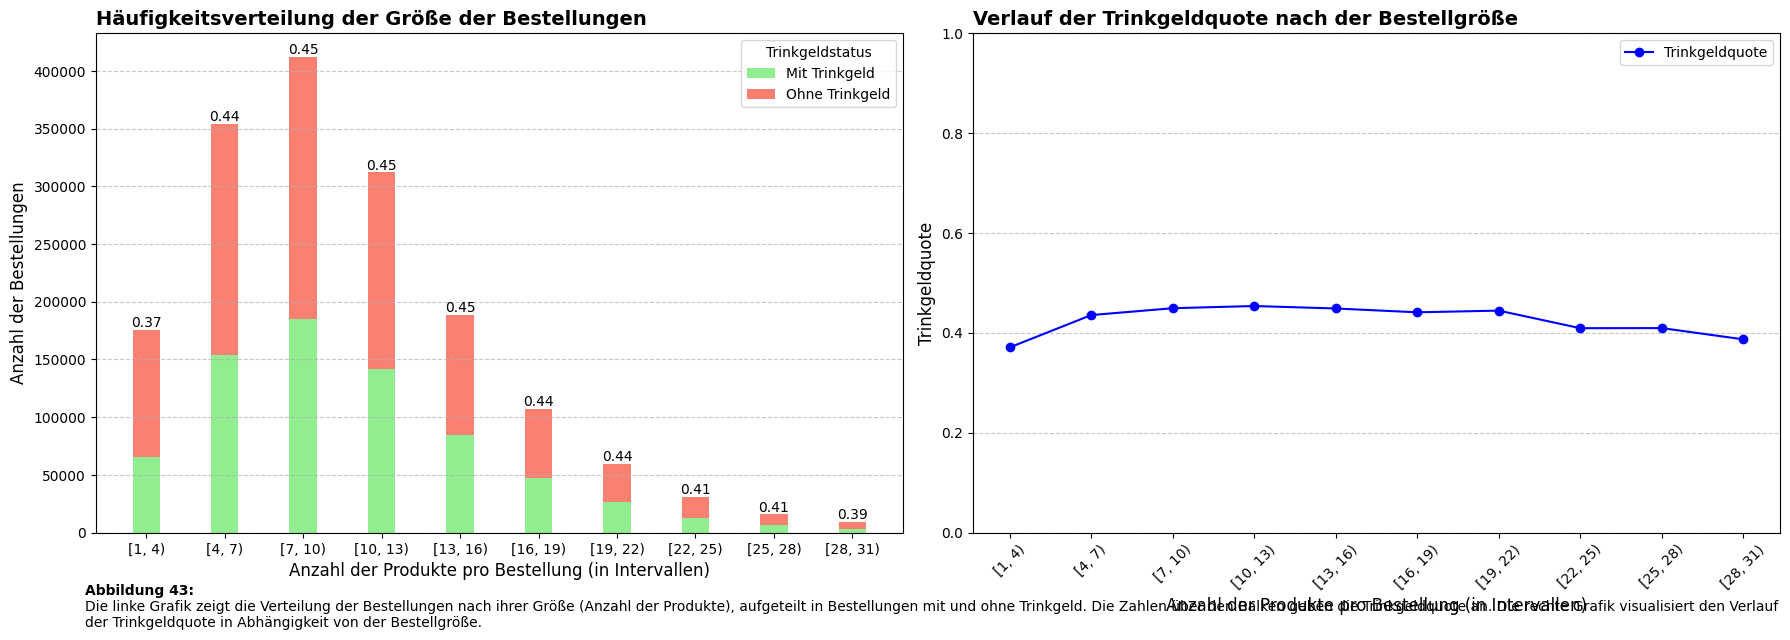

In [306]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

bars_with_tips = ax1.bar(grouped_stats_df_item_count['item_count_group'].astype(str), 
                        grouped_stats_df_item_count['orders_with_tips'], 
                        width=0.35, color='lightgreen', label='Mit Trinkgeld')
bars_without_tips = ax1.bar(grouped_stats_df_item_count['item_count_group'].astype(str), 
                           grouped_stats_df_item_count['orders_without_tips'], 
                           width=0.35, bottom=grouped_stats_df_item_count['orders_with_tips'], 
                           color='salmon', label='Ohne Trinkgeld')

for i, rect in enumerate(bars_with_tips):
    total_height = rect.get_height() + bars_without_tips[i].get_height()
    ratio = grouped_stats_df_item_count['tips_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, total_height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom', fontsize=10)

ax1.set_title('Häufigkeitsverteilung der Größe der Bestellungen', 
              loc='left', weight='bold', fontsize=14)
ax1.set_xlabel('Anzahl der Produkte pro Bestellung (in Intervallen)', fontsize=12)
ax1.set_ylabel('Anzahl der Bestellungen', fontsize=12)
ax1.legend(title='Trinkgeldstatus')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

ax2.plot(grouped_stats_df_item_count['item_count_group'].astype(str), 
         grouped_stats_df_item_count['tips_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote nach der Bestellgröße', 
              loc='left', weight='bold', fontsize=14)
ax2.set_xlabel('Anzahl der Produkte pro Bestellung (in Intervallen)', fontsize=12)
ax2.set_ylabel('Trinkgeldquote', fontsize=12)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


description = 'Die linke Grafik zeigt die Verteilung der Bestellungen nach ihrer Größe (Anzahl der Produkte), aufgeteilt in Bestellungen mit und ohne Trinkgeld. Die Zahlen über den Balken geben die Trinkgeldquote an. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote in Abhängigkeit von der Bestellgröße.'
fig.text(0.05, 0, 'Abbildung 43:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [307]:
# Stelle sicher, dass 'order_group' eine reguläre Spalte ist (nicht der Index)
grouped_stats_df_item_count.reset_index(inplace=True)

# Setze 'order_group' als Index
crosstab = grouped_stats_df_item_count.set_index('item_count_group')[['orders_with_tips', 'orders_without_tips']]

In [308]:
# chi² code
chi2, p_value, dof, expected = chi2_contingency(crosstab)

test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p_value}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Anzahl der Bestellungen und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Anzahl der Bestellungen und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))



Chi-Quadrat Testergebnisse:
╒═══════════════════════╤════════╕
│ Metrik                │   Wert │
╞═══════════════════════╪════════╡
│ Chi-Quadrat Statistik │ 4097.7 │
├───────────────────────┼────────┤
│ p-Wert                │      0 │
├───────────────────────┼────────┤
│ Freiheitsgrade        │      9 │
╘═══════════════════════╧════════╛

Interpretation:
╒══════════════════╤════════════════════════════════════════════════════════════╕
│                  │                                                            │
╞══════════════════╪════════════════════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang                     │
├──────────────────┼────────────────────────────────────────────────────────────┤
│ Begründung       │ p-Wert (0.0) < Signifikanzniveau (0.05)                    │
├──────────────────┼────────────────────────────────────────────────────────────┤
│ Schlussfolgerung │ Anzahl der Bestellungen und Trinkgeldvergabe

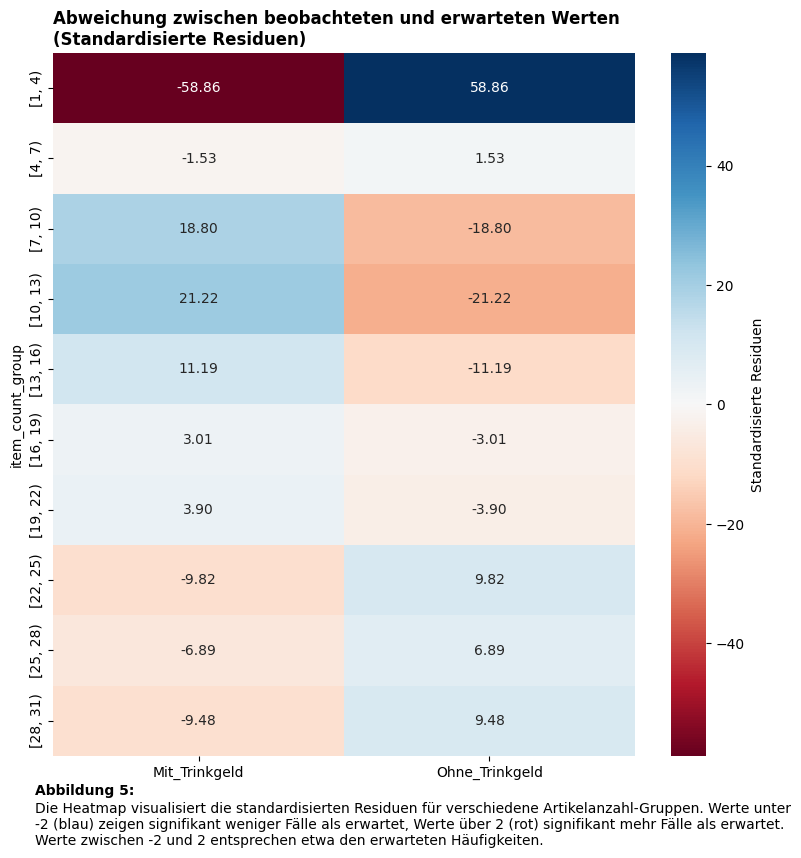

In [311]:
# plot code
observed = crosstab[['orders_with_tips', 'orders_without_tips']].values

# Chi-Quadrat-Test durchführen
chi2, p_value, dof, expected = chi2_contingency(observed)

# Korrigierte standardisierte Residuen berechnen
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.sum()

corrected_residuals = np.zeros_like(observed, dtype=float)
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        E = expected[i, j]
        O = observed[i, j]
        correction = np.sqrt((1 - row_totals[i]/grand_total) *
                           (1 - col_totals[j]/grand_total))
        corrected_residuals[i, j] = (O - E) / (np.sqrt(E) * correction)

# DataFrame für die Residuen erstellen
residuals_df = pd.DataFrame(
    corrected_residuals,
    index=crosstab.index,  # Verwendet die Artikelanzahl-Gruppen als Index
    columns=['Mit_Trinkgeld', 'Ohne_Trinkgeld']
)

# Heatmap erstellen
fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.08)

sns.heatmap(residuals_df,
            annot=True,
            cmap='RdBu',
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardisierte Residuen'},
            ax=ax)

ax.set_title('Abweichung zwischen beobachteten und erwarteten Werten\n(Standardisierte Residuen)',
             loc='left',
             weight='bold')

description = 'Die Heatmap visualisiert die standardisierten Residuen für verschiedene Artikelanzahl-Gruppen. Werte unter -2 (blau) zeigen signifikant weniger Fälle als erwartet, Werte über 2 (rot) signifikant mehr Fälle als erwartet. Werte zwischen -2 und 2 entsprechen etwa den erwarteten Häufigkeiten.'
fig.text(0.05, 0, 'Abbildung 5:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

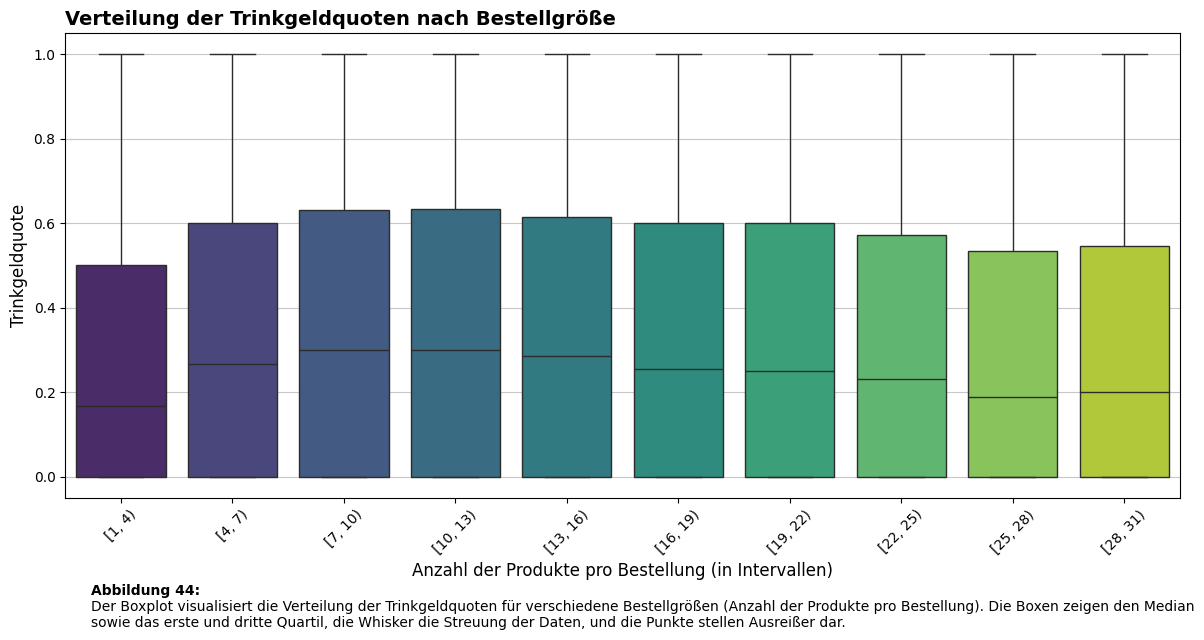

/tmp/ipykernel_12741/280523961.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = user_stats_df.groupby('item_count_group')['tip_ratio'].describe().reset_index()


| item_count_group   |   count |     mean |      std |   min |   25% |      50% |      75% |   max |
|:-------------------|--------:|---------:|---------:|------:|------:|---------:|---------:|------:|
| [1, 4)             |   13178 | 0.290442 | 0.331754 |     0 |     0 | 0.166667 | 0.5      |     1 |
| [4, 7)             |   21991 | 0.351854 | 0.336874 |     0 |     0 | 0.266667 | 0.6      |     1 |
| [7, 10)            |   23822 | 0.367149 | 0.334939 |     0 |     0 | 0.3      | 0.631579 |     1 |
| [10, 13)           |   18155 | 0.369306 | 0.334755 |     0 |     0 | 0.3      | 0.634146 |     1 |
| [13, 16)           |   11259 | 0.359589 | 0.333961 |     0 |     0 | 0.285714 | 0.615385 |     1 |
| [16, 19)           |    6649 | 0.349186 | 0.332531 |     0 |     0 | 0.255102 | 0.6      |     1 |
| [19, 22)           |    3759 | 0.345208 | 0.336782 |     0 |     0 | 0.25     | 0.6      |     1 |
| [22, 25)           |    2022 | 0.322679 | 0.329247 |     0 |     0 | 0.230769 | 0.571429 |     1 |
| [25, 28)           |    1077 | 0.302422 | 0.330092 |     0 |     0 | 0.1875   | 0.533333 |     1 |
| [28, 31)           |     607 | 0.307518 | 0.328821 |     0 |     0 | 0.2      | 0.545455 |     1 |

In [315]:
# plot code
user_stats_df['item_count_group'] = pd.cut(
    user_stats_df['avg_order_size'],
    bins=range(1, 32, 3),
    right=False  
)

user_stats_df['tip_ratio'] = user_stats_df['orders_with_tips'] / user_stats_df['total_orders']

fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='item_count_group', 
    y='tip_ratio', 
    palette='viridis',
    hue='item_count_group',
    legend=False,
    ax=ax
)

ax.set_title('Verteilung der Trinkgeldquoten nach Bestellgröße', 
             loc='left', weight='bold', fontsize=14)
ax.set_xlabel('Anzahl der Produkte pro Bestellung (in Intervallen)', fontsize=12)
ax.set_ylabel('Trinkgeldquote', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.7)

description = 'Der Boxplot visualisiert die Verteilung der Trinkgeldquoten für verschiedene Bestellgrößen (Anzahl der Produkte pro Bestellung). Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.08, 0, 'Abbildung 44:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

summary_stats = user_stats_df.groupby('item_count_group')['tip_ratio'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)

display(Markdown(markdown_table))


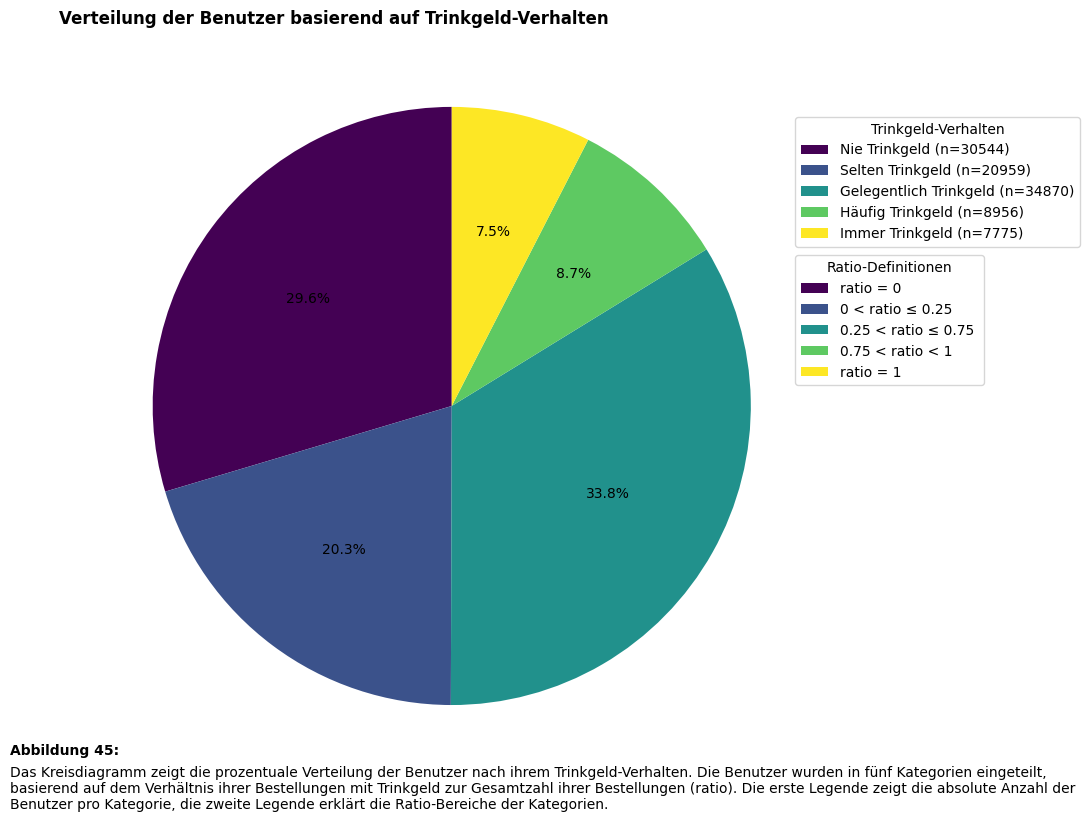

In [312]:
# plot code
def categorize_tip_ratio(ratio):
    if ratio == 0:
        return "Nie Trinkgeld"
    elif ratio == 1:
        return "Immer Trinkgeld"
    elif ratio <= 0.25:
        return "Selten Trinkgeld"
    elif ratio <= 0.75:
        return "Gelegentlich Trinkgeld"
    elif ratio < 1.0:
        return "Häufig Trinkgeld"
    else:
        return "immer Trinkgeld"

user_stats_df['tip_category'] = user_stats_df['tip_ratio'].apply(categorize_tip_ratio)

tip_category_counts = user_stats_df['tip_category'].value_counts()

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0.08)

category_order = ["Nie Trinkgeld", "Selten Trinkgeld", "Gelegentlich Trinkgeld", 
                 "Häufig Trinkgeld", "Immer Trinkgeld"]

tip_category_counts = tip_category_counts.reindex(category_order)

colors = plt.cm.viridis(np.linspace(0, 1, len(category_order)))

wedges, texts, autotexts = ax.pie(
    tip_category_counts.values,
    labels=None,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90)

ax.set_title('Verteilung der Benutzer basierend auf Trinkgeld-Verhalten', 
             loc='left', weight='bold', x=-0.025)

legend_elements_1 = [
    Patch(facecolor=colors[i], label=f"{cat} (n={tip_category_counts[cat]})")
    for i, cat in enumerate(category_order)
]

legend_1 = ax.legend(
    handles=legend_elements_1,
    title="Trinkgeld-Verhalten",
    loc="center left",
    bbox_to_anchor=(0.95, 0.8),
    frameon=True
)

ratio_explanations = [
    "ratio = 0".ljust(20),
    "0 < ratio ≤ 0.25".ljust(20),
    "0.25 < ratio ≤ 0.75".ljust(20),
    "0.75 < ratio < 1".ljust(20),
    "ratio = 1".ljust(20)
]

legend_elements_2 = [
    Patch(facecolor=colors[i], label=exp) 
    for i, exp in enumerate(ratio_explanations)
]

legend_2 = ax.legend(
    handles=legend_elements_2,
    title="Ratio-Definitionen",
    loc='center left',
    bbox_to_anchor=(0.95, 0.615),
    frameon=True
)

ax.add_artist(legend_1)

description = 'Das Kreisdiagramm zeigt die prozentuale Verteilung der Benutzer nach ihrem Trinkgeld-Verhalten. Die Benutzer wurden in fünf Kategorien eingeteilt, basierend auf dem Verhältnis ihrer Bestellungen mit Trinkgeld zur Gesamtzahl ihrer Bestellungen (ratio). Die erste Legende zeigt die absolute Anzahl der Benutzer pro Kategorie, die zweite Legende erklärt die Ratio-Bereiche der Kategorien.'
fig.text(0.1, 0.05, 'Abbildung 45:', weight='bold', ha='left')
fig.text(0.1, -0.015, description, wrap=True)

plt.tight_layout()
plt.show()

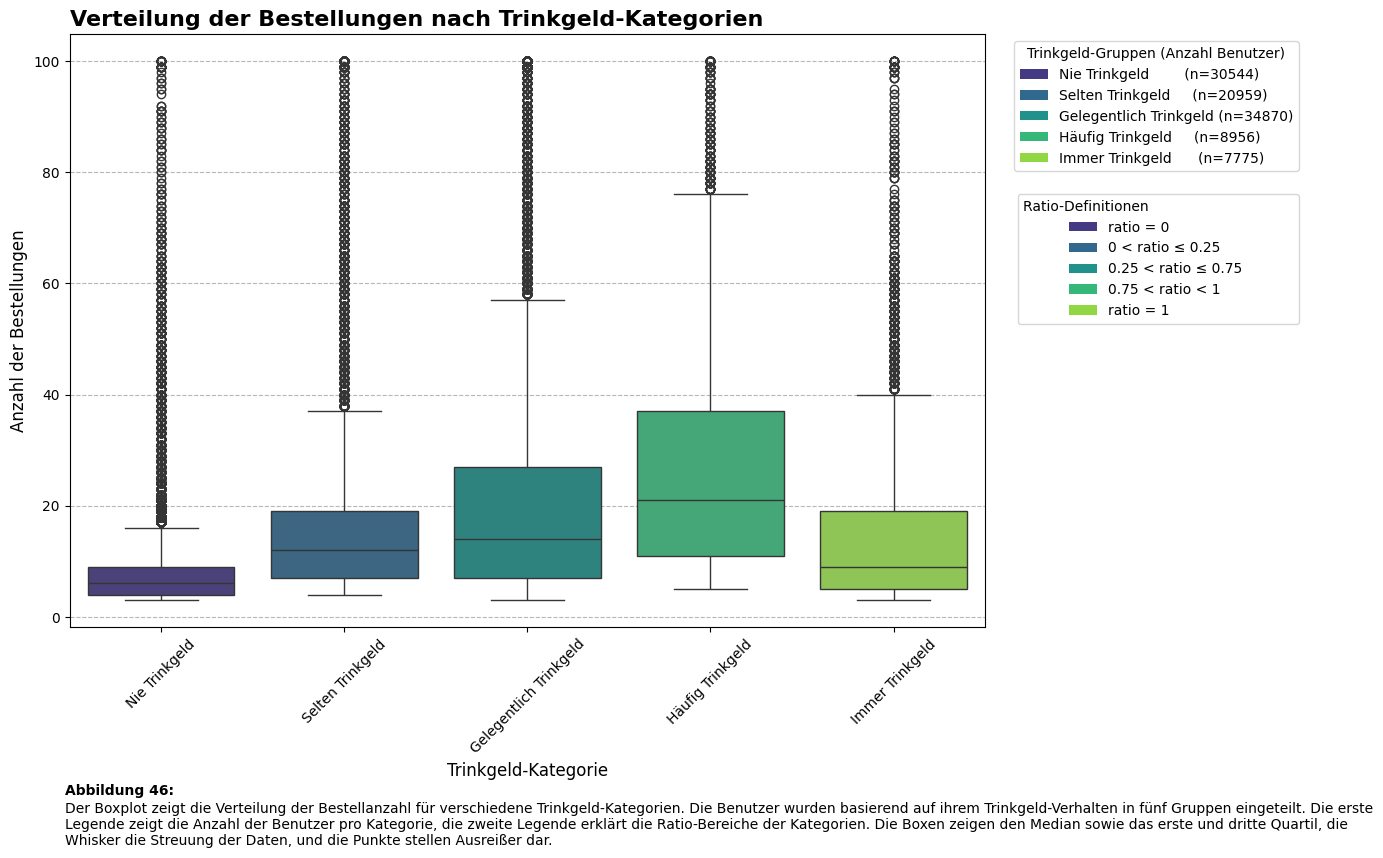

/tmp/ipykernel_12741/127993441.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = user_stats_df.groupby('tip_category')['total_orders'].describe().reset_index()


| tip_category           |   count |     mean |      std |   min |   25% |   50% |   75% |   max |
|:-----------------------|--------:|---------:|---------:|------:|------:|------:|------:|------:|
| Nie Trinkgeld          |   30544 |  8.42267 |  8.31828 |     3 |     4 |     6 |     9 |   100 |
| Selten Trinkgeld       |   20959 | 16.1157  | 15.583   |     4 |     7 |    12 |    19 |   100 |
| Gelegentlich Trinkgeld |   34870 | 20.8696  | 19.0922  |     3 |     7 |    14 |    27 |   100 |
| Häufig Trinkgeld       |    8956 | 25.9238  | 19.3059  |     5 |    11 |    21 |    37 |   100 |
| Immer Trinkgeld        |    7775 | 15.1888  | 15.5573  |     3 |     5 |     9 |    19 |   100 |

In [314]:
# plot code
category_order = ["Nie Trinkgeld", "Selten Trinkgeld", "Gelegentlich Trinkgeld", 
                  "Häufig Trinkgeld", "Immer Trinkgeld"]

group_counts = user_stats_df['tip_category'].value_counts()

user_stats_df['tip_category'] = pd.Categorical(user_stats_df['tip_category'], categories=category_order, ordered=True)
user_stats_df = user_stats_df.sort_values(by='tip_category')

fig, ax = plt.subplots(figsize=(14, 8))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='tip_category',
    y='total_orders',
    order=category_order,
    palette='viridis',
    ax=ax,
    hue='tip_category'
)

ax.set_title('Verteilung der Bestellungen nach Trinkgeld-Kategorien', 
             loc='left', weight='bold', fontsize=16)
ax.set_xlabel('Trinkgeld-Kategorie', fontsize=12)
ax.set_ylabel('Anzahl der Bestellungen', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

legend_elements_1 = [
    Patch(facecolor=sns.color_palette('viridis', len(category_order))[i], 
          label=f"{cat.ljust(20)} (n={group_counts[cat]:<3})")
    for i, cat in enumerate(category_order)
]

legend_1 = ax.legend(
    handles=legend_elements_1,
    title="Trinkgeld-Gruppen (Anzahl Benutzer)".ljust(20),
    loc='upper right',
    bbox_to_anchor=(1.35, 1),
    frameon=True
)

ratio_explanations = [
    "ratio = 0".ljust(20),
    "0 < ratio ≤ 0.25".ljust(20),
    "0.25 < ratio ≤ 0.75".ljust(20),
    "0.75 < ratio < 1".ljust(20),
    "ratio = 1".ljust(20)
]

legend_elements_2 = [
    Patch(facecolor=sns.color_palette('viridis', len(ratio_explanations))[i], label=exp) 
    for i, exp in enumerate(ratio_explanations)
]

legend_2 = ax.legend(
    handles=legend_elements_2,
    title="Ratio-Definitionen".ljust(51),
    loc='lower right',
    bbox_to_anchor=(1.35, 0.5),
    frameon=True
)

ax.add_artist(legend_1)
ax.grid(axis='y', linestyle='--', alpha=0.9)

description = 'Der Boxplot zeigt die Verteilung der Bestellanzahl für verschiedene Trinkgeld-Kategorien. Die Benutzer wurden basierend auf ihrem Trinkgeld-Verhalten in fünf Gruppen eingeteilt. Die erste Legende zeigt die Anzahl der Benutzer pro Kategorie, die zweite Legende erklärt die Ratio-Bereiche der Kategorien. Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.05, 0, 'Abbildung 46:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

summary_stats = user_stats_df.groupby('tip_category')['total_orders'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)

display(Markdown(markdown_table))


In [9]:
# show df
category_order = ["Nie Trinkgeld", "Selten Trinkgeld", "Gelegentlich Trinkgeld", 
                  "Häufig Trinkgeld", "Immer Trinkgeld"]

group_counts = user_stats_df['tip_category'].value_counts()

user_stats_df['tip_category'] = pd.Categorical(user_stats_df['tip_category'], categories=category_order, ordered=True)
user_stats_df = user_stats_df.sort_values(by='tip_category')
user_stats_df

user_id  total_orders  orders_with_tips  orders_without_tips  \
0            1            11                 0                   11   
12309    24308            18                 0                   18   
99315   198758             5                 0                    5   
85833   171397            10                 0                   10   
85832   171396             4                 0                    4   
...        ...           ...               ...                  ...   
43099    85859            26                26                    0   
81396   162495            17                17                    0   
15395    30554            64                64                    0   
35446    70553             5                 5                    0   
86135   172000             6                 6                    0   

       avg_order_size order_group  tip_ratio     tip_category  
0            6.363636    [11, 21)        0.0    Nie Trinkgeld  
12309        7.055556    [11, 21)        0.0    Nie Trinkgeld  
99315        3.800000     [1, 11)        0.0    Nie Trinkgeld  
85833        8.300000     [1, 11)        0.0    Nie Trinkgeld  
85832        3.250000     [1, 11)        0.0    Nie Trinkgeld  
...               ...         ...        ...              ...  
43099        3.769231    [21, 31)        1.0  Immer Trinkgeld  
81396       13.058824    [11, 21)        1.0  Immer Trinkgeld  
15395       13.296875    [61, 71)        1.0  Immer Trinkgeld  
35446       11.400000     [1, 11)        1.0  Immer Trinkgeld  
86135       14.000000     [1, 11)        1.0  Immer Trinkgeld  

[103104 rows x 8 columns]

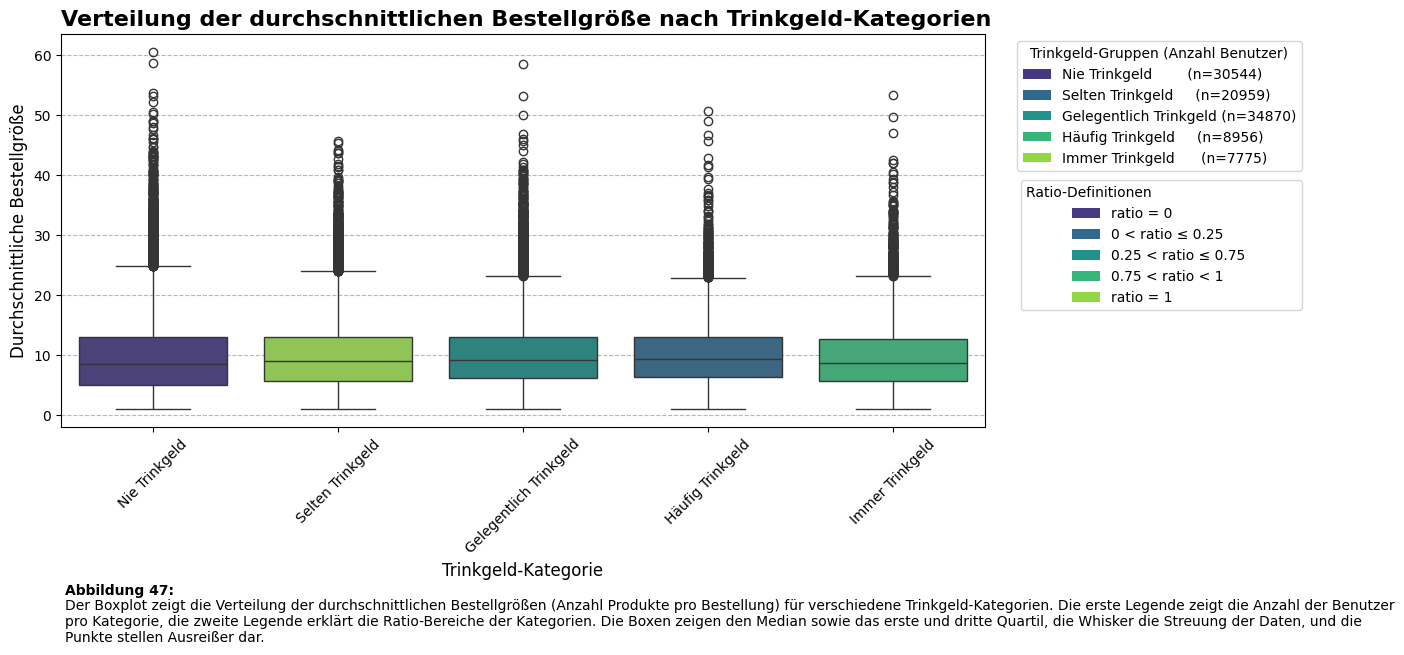

| tip_category           |   count |     mean |     std |   min |     25% |     50% |     75% |     max |
|:-----------------------|--------:|---------:|--------:|------:|--------:|--------:|--------:|--------:|
| Gelegentlich Trinkgeld |   34870 | 10.1248  | 5.57082 |     1 | 6.16667 | 9.16667 | 13      | 58.5    |
| Häufig Trinkgeld       |    8956 | 10.2351  | 5.4301  |     1 | 6.3837  | 9.31401 | 13      | 50.7083 |
| Immer Trinkgeld        |    7775 |  9.81899 | 5.73614 |     1 | 5.71429 | 8.76471 | 12.7071 | 53.2759 |
| Nie Trinkgeld          |   30544 |  9.77409 | 6.30377 |     1 | 5.11111 | 8.6     | 13      | 60.5    |
| Selten Trinkgeld       |   20959 | 10.0188  | 5.85337 |     1 | 5.75894 | 9       | 13.0625 | 45.75   |

In [313]:
# plot code
summary_stats = user_stats_df.groupby('tip_category')['avg_order_size'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)


fig, ax = plt.subplots(figsize=(14, 6))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='tip_category',
    y='avg_order_size',
    order=category_order,
    palette='viridis',
    ax=ax,
    hue='tip_category'
)

ax.set_title('Verteilung der durchschnittlichen Bestellgröße nach Trinkgeld-Kategorien', 
             loc='left', weight='bold', fontsize=16)
ax.set_xlabel('Trinkgeld-Kategorie', fontsize=12)
ax.set_ylabel('Durchschnittliche Bestellgröße', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

legend_elements_1 = [
    Patch(facecolor=sns.color_palette('viridis', len(category_order))[i], 
          label=f"{cat.ljust(20)} (n={group_counts[cat]:<3})")
    for i, cat in enumerate(category_order)
]

legend_1 = ax.legend(
    handles=legend_elements_1,
    title="Trinkgeld-Gruppen (Anzahl Benutzer)".ljust(20),
    loc='upper right',
    bbox_to_anchor=(1.35, 1),
    frameon=True
)

ratio_explanations = [
    "ratio = 0".ljust(20),
    "0 < ratio ≤ 0.25".ljust(20),
    "0.25 < ratio ≤ 0.75".ljust(20),
    "0.75 < ratio < 1".ljust(20),
    "ratio = 1".ljust(20)
]

legend_elements_2 = [
    Patch(facecolor=sns.color_palette('viridis', len(ratio_explanations))[i], label=exp) 
    for i, exp in enumerate(ratio_explanations)
]

legend_2 = ax.legend(
    handles=legend_elements_2,
    title="Ratio-Definitionen".ljust(51),
    loc='lower right',
    bbox_to_anchor=(1.35, 0.28),
    frameon=True
)

ax.add_artist(legend_1)
ax.grid(axis='y', linestyle='--', alpha=0.9)

description = 'Der Boxplot zeigt die Verteilung der durchschnittlichen Bestellgrößen (Anzahl Produkte pro Bestellung) für verschiedene Trinkgeld-Kategorien. Die erste Legende zeigt die Anzahl der Benutzer pro Kategorie, die zweite Legende erklärt die Ratio-Bereiche der Kategorien. Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.05, 0, 'Abbildung 47:', weight='bold', ha='left')
fig.text(0.05, -0.075, description, wrap=True)

plt.tight_layout()
plt.show()

display(Markdown(markdown_table))


In [30]:
# Liste aller Benutzer die nur eine einzige Bestellung getätigt haben
users_with_one_order = session.query(Order.user_id)\
    .group_by(Order.user_id)\
    .having(func.count(Order.order_id) == 1)\
    .all()

print(f"Anzahl der Benutzer mit nur einer Bestellung: {len(users_with_one_order)}")

Anzahl der Benutzer mit nur einer Bestellung: 0


---
## <h2 id="fragen">Konkrete Fragen</h2> 



### Frage 1:
Hängt die Wahrscheinlichkeit, dass bei einer Bestellung Trinkgeld gegeben wird, vom 
Trinkgeldverhalten bei früheren Bestellungen desselben Bestellers ab? 



> a) Gibt es einen Zusammenhang bezüglich der vorhergehenden Bestellung?  

In [461]:
aisles = pd.read_csv('../../Daten/aisles.csv')
departments = pd.read_csv('../../Daten/departments.csv')
order_products = pd.read_csv('../../Daten/oder_products_s.csv')
orders = pd.read_csv('../../Daten/oders_s.csv')
products = pd.read_csv('../../Daten/products.csv')
tips = pd.read_csv('../../Daten/tips.csv')

tips.drop(columns="Unnamed: 0",inplace=True)

In [462]:
orders

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0         2539329        1             1          2                  8   
1         2398795        1             2          3                  7   
2          473747        1             3          3                 12   
3         2254736        1             4          4                  7   
4          431534        1             5          4                 15   
...           ...      ...           ...        ...                ...   
1673016   2266710   206209            10          5                 18   
1673017   1854736   206209            11          4                 10   
1673018    626363   206209            12          1                 12   
1673019   2977660   206209            13          1                 12   
1673020    272231   206209            14          6                 14   

         days_since_prior_order  
0                           NaN  
1                          15.0  
2                          21.0  
3                          29.0  
4                          28.0  
...                         ...  
1673016                    29.0  
1673017                    30.0  
1673018                    18.0  
1673019                     7.0  
1673020                    30.0  

[1673021 rows x 6 columns]

In [463]:
# Verknüpfe Tipps mit Bestellungen
orders = orders.merge(tips, on='order_id', how='left')
orders

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0         2539329        1             1          2                  8   
1         2398795        1             2          3                  7   
2          473747        1             3          3                 12   
3         2254736        1             4          4                  7   
4          431534        1             5          4                 15   
...           ...      ...           ...        ...                ...   
1673016   2266710   206209            10          5                 18   
1673017   1854736   206209            11          4                 10   
1673018    626363   206209            12          1                 12   
1673019   2977660   206209            13          1                 12   
1673020    272231   206209            14          6                 14   

         days_since_prior_order    tip  
0                           NaN  False  
1                          15.0  False  
2                          21.0  False  
3                          29.0  False  
4                          28.0  False  
...                         ...    ...  
1673016                    29.0  False  
1673017                    30.0  False  
1673018                    18.0  False  
1673019                     7.0  False  
1673020                    30.0  False  

[1673021 rows x 7 columns]

In [465]:
orders= orders.sort_values(by=["user_id","order_number"])

# Spalte für vorherige und vor-vorherige Trinkgeldangaben
orders['tip_prev'] = orders.groupby('user_id')['tip'].shift(1)
orders['tip_prev2'] = orders.groupby('user_id')['tip'].shift(2)

orders[orders["user_id"] == 67]

order_id  user_id  order_number  order_dow  order_hour_of_day  \
550   3205960       67             1          3                 11   
551    970922       67             2          1                 15   
552    596585       67             3          1                 13   
553   2037087       67             4          2                  9   
554   2474111       67             5          3                 14   
555   1568481       67             6          3                 12   
556   1723781       67             7          2                 13   
557   2048527       67             8          2                 11   
558   2389031       67             9          2                 14   
559   2378562       67            10          1                 10   
560   1515698       67            11          1                 11   
561   1928050       67            12          2                 12   
562   1949274       67            13          1                 10   
563    551869       67            14          1                  9   
564   2233579       67            15          2                 15   
565    768572       67            16          4                 10   
566     46584       67            17          1                 19   
567    150528       67            18          5                 16   
568     29758       67            19          0                 14   
569   2812906       67            20          3                 13   
570   1558976       67            21          1                  9   
571    863974       67            22          1                 11   
572   2308399       67            23          1                 14   
573   1931044       67            24          2                 12   
574   2757217       67            25          0                 11   

     days_since_prior_order    tip tip_prev tip_prev2  
550                     NaN   True      NaN       NaN  
551                     5.0   True     True       NaN  
552                     7.0  False     True      True  
553                     8.0   True    False      True  
554                     8.0   True     True     False  
555                     7.0  False     True      True  
556                     6.0   True    False      True  
557                     7.0  False     True     False  
558                     7.0  False    False      True  
559                     6.0   True    False     False  
560                     7.0   True     True     False  
561                     8.0  False     True      True  
562                     6.0  False    False      True  
563                     7.0  False    False     False  
564                    15.0  False    False     False  
565                     9.0  False    False     False  
566                    11.0   True    False     False  
567                     4.0   True     True     False  
568                     9.0  False     True      True  
569                     3.0  False    False      True  
570                     5.0   True    False     False  
571                    14.0   True     True     False  
572                    14.0   True     True      True  
573                     1.0  False     True      True  
574                     5.0   True    False      True

In [466]:
pd.crosstab(orders['tip_prev'], orders['tip'], margins=True,normalize='all')

tip          False      True       All
tip_prev                              
False     0.432685  0.124802  0.557487
True      0.126103  0.316409  0.442513
All       0.558789  0.441211  1.000000

Ca. 44% aller Bestellungen erhalten Trinkgeld

In [467]:
pd.crosstab(orders['tip'], orders['tip_prev'], margins=True,normalize='index')

tip_prev     False      True
tip                         
False     0.774327  0.225673
True      0.282863  0.717137
All       0.557487  0.442513

Wenn ein Kunde bei der vorhergenden Bestellung Trinkgeld gibt, ist die Wahrscheinlichkeit bei der aktuellen Bestellung 71%, d.h. ein Zusammenhang besteht.

In [468]:
pd.crosstab(orders['tip'], orders['tip_prev2'], margins=True,normalize='index')

tip_prev2     False      True
tip                          
False      0.739978  0.260022
True       0.316907  0.683093
All        0.550662  0.449338

In [469]:
pd.crosstab([orders['tip_prev2'], orders['tip_prev']],orders["tip"] ,margins=True,normalize='index')

tip                    False      True
tip_prev2 tip_prev                    
False     False     0.825825  0.174175
          True      0.461901  0.538099
True      False     0.594185  0.405815
          True      0.211156  0.788844
All                 0.552520  0.447480

In [470]:
orders.pivot_table('tip', 'tip_prev', 'tip_prev2', aggfunc=np.mean)

/tmp/ipykernel_12741/485001432.py:1: FutureWarning: The provided callable <function mean at 0x72ce44f6feb0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  orders.pivot_table('tip', 'tip_prev', 'tip_prev2', aggfunc=np.mean)


tip_prev2     False     True 
tip_prev                     
False      0.174175  0.405815
True       0.538099  0.788844

Die Höchste Trinkgeldwahrscheinlichkeit für den Fall tip_prev=True und tip_prev2, D.h. tip_prev2 bietet uns unabhängig von trip_prev informationen über das Trinkgeldverhalten.

/tmp/ipykernel_12741/1021396795.py:1: FutureWarning: The provided callable <function mean at 0x72ce44f6feb0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = orders.pivot_table('tip', 'tip_prev', 'tip_prev2', aggfunc=np.mean)


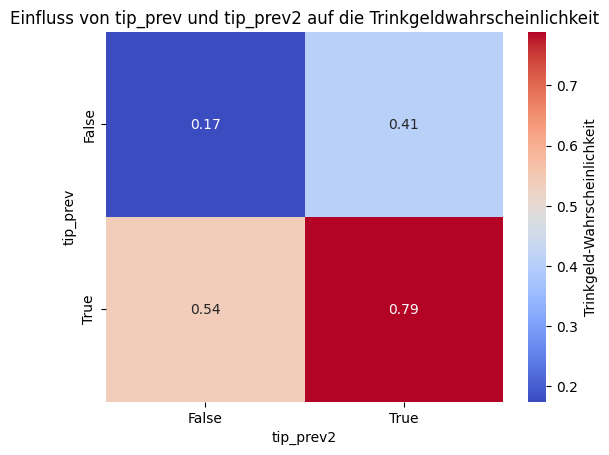

In [472]:
pivot = orders.pivot_table('tip', 'tip_prev', 'tip_prev2', aggfunc=np.mean)
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Trinkgeld-Wahrscheinlichkeit'})
plt.title('Einfluss von tip_prev und tip_prev2 auf die Trinkgeldwahrscheinlichkeit')
plt.xlabel('tip_prev2')
plt.ylabel('tip_prev')
plt.show()

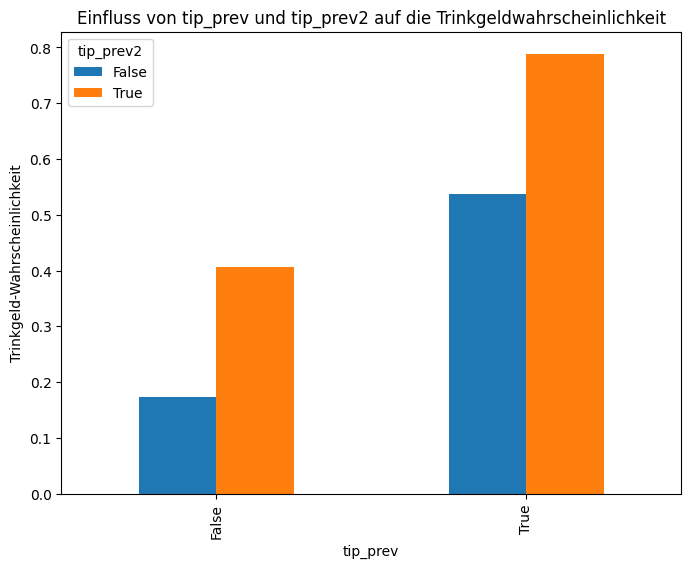

In [473]:
grouped = orders.groupby(['tip_prev', 'tip_prev2'])['tip'].mean().unstack()
grouped.plot(kind='bar', stacked=False, figsize=(8, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Einfluss von tip_prev und tip_prev2 auf die Trinkgeldwahrscheinlichkeit')
plt.ylabel('Trinkgeld-Wahrscheinlichkeit')
plt.xlabel('tip_prev')
plt.legend(title='tip_prev2')
plt.show()

In [474]:
pd.crosstab([orders['tip_prev2'], orders['tip_prev']],columns=orders["tip"], margins=True,normalize='index')

tip                    False      True
tip_prev2 tip_prev                    
False     False     0.825825  0.174175
          True      0.461901  0.538099
True      False     0.594185  0.405815
          True      0.211156  0.788844
All                 0.552520  0.447480

In [475]:
order_t = orders[orders["tip_prev"]== False] # nur die Frauen
table_w = pd.crosstab(order_t['tip_prev2'],columns=order_t['tip'])
table_w

tip         False   True 
tip_prev2                
False      514261  108463
True       111011   75818

In [476]:
ch2_w, p_w, dof_w, expected_w = chi2_contingency(table_w)
print(expected_w)
print('Chi2-Wert=%.6f' % (ch2_w))
print('dof=%.6f' % (dof_w))
print('p-value=%.6f' % (p_w))

[[480971.45082286 141752.54917714]
 [144300.54917714  42528.45082286]]
Chi2-Wert=43858.038694
dof=1.000000
p-value=0.000000


In [477]:
order_t = orders[orders["tip_prev"]== True] # nur die Frauen
table_m = pd.crosstab(order_t['tip_prev2'],columns=order_t['tip'])
table_m

tip        False   True 
tip_prev2               
False      85449   99545
True       99722  372544

In [478]:
ch2_m, p_m, dof_m, expected_m = chi2_contingency(table_m)
print(expected_m)
print('Chi2-Wert=%.6f' % (ch2_m))
print('dof=%.6f' % (dof_m))
print('p-value=%.6f' % (p_m))

[[ 52118.68054347 132875.31945653]
 [133052.31945653 339213.68054347]]
Chi2-Wert=41298.697347
dof=1.000000
p-value=0.000000


In [480]:
from scipy.stats import chi2

ch2_gesamt = ch2_m+ch2_w
dof_gesamt = dof_w+dof_m
p_gesamt = 1-chi2.cdf(ch2_gesamt,dof_gesamt)
print('Chi2-Wert=%.6f' % (ch2_gesamt))
print('dof=%.6f' % (dof_gesamt))
print('p-value=%.6f' % (p_gesamt))

Chi2-Wert=85156.736041
dof=2.000000
p-value=0.000000


> b) Gibt es einen Zusammenhang bezüglich der vor-vorhergehenden Bestellung? 

> c) Liefert das Trinkgeldverhalten der vor-vorhergehende Bestellung Informationen auch über das 
hinaus, was bereits aus der vorhergehenden Bestellung abgelesen werden kann?


### Frage 2:

> a) Gibt es einen Zusammenhang zwischen dem Trinkgeldverhalten und den Departments, aus denen bestellt wird? 


In [483]:
aisles = pd.read_csv('../../Daten/aisles.csv')
departments = pd.read_csv('../../Daten/departments.csv')
order_products = pd.read_csv('../../Daten/oder_products_s.csv')
orders = pd.read_csv('../../Daten/oders_s.csv')
products = pd.read_csv('../../Daten/products.csv')
tips = pd.read_csv('../../Daten/tips.csv')

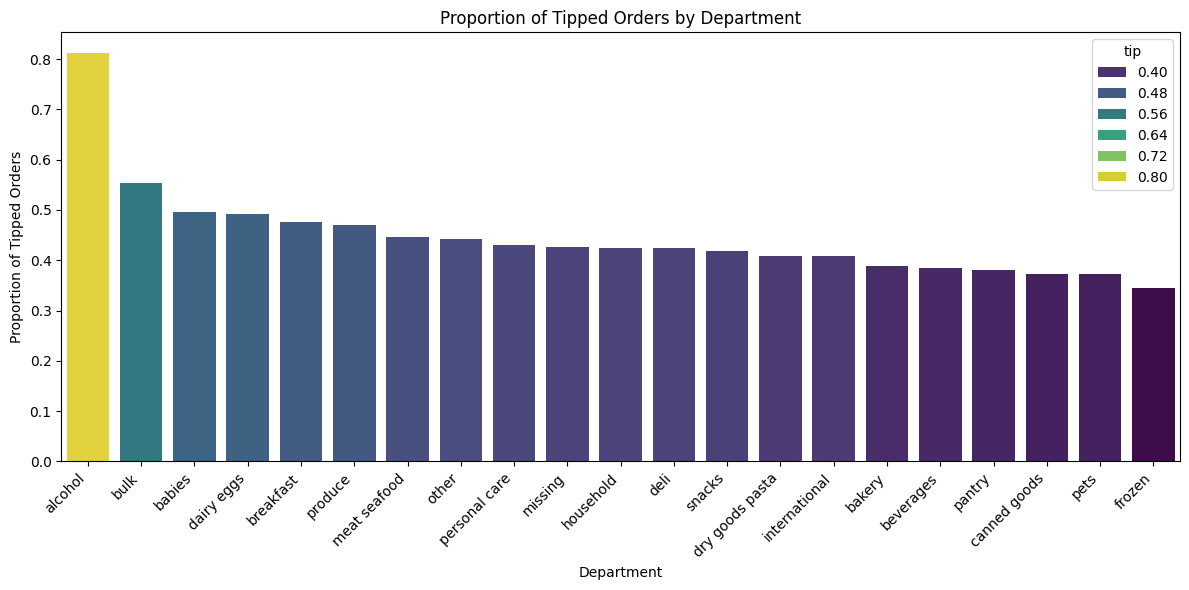

Chi-square Test Results
Chi2 statistic: 199364.85
P-value: 0.0000e+00
Degrees of Freedom: 20
Conclusion: There is a significant association between tipping behavior and the department.


In [485]:
merged_data = (order_products
               .merge(products, on='product_id')
               .merge(departments, on='department_id')
               .merge(orders, on='order_id')
               .merge(tips, on='order_id'))

# Aggregate data: Percentage of orders with tips by department
department_tip_rate = (merged_data.groupby('department')['tip']
                       .mean()  # Calculate the proportion of True (tipped orders)
                       .reset_index()
                       .sort_values(by='tip', ascending=False))

# Visualize the percentage of tipped orders by department
plt.figure(figsize=(12, 6))
sns.barplot(data=department_tip_rate, x='department', y='tip', palette='viridis', hue='tip')
plt.xticks(rotation=45, ha='right')
plt.title('Proportion of Tipped Orders by Department')
plt.ylabel('Proportion of Tipped Orders')
plt.xlabel('Department')
plt.tight_layout()
plt.show()

# Statistical analysis: Chi-square test to check association
# Create a contingency table: Count of tipped vs. non-tipped orders by department
contingency_table = pd.crosstab(merged_data['tip'], merged_data['department'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output results
print("Chi-square Test Results")
print(f"Chi2 statistic: {chi2:.2f}")
print(f"P-value: {p:.4e}")
print(f"Degrees of Freedom: {dof}")
if p < 0.05:
    print("Conclusion: There is a significant association between tipping behavior and the department.")
else:
    print("Conclusion: There is no significant association between tipping behavior and the department.")

/tmp/ipykernel_12741/651146884.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=department_percentage, x='department', y='percentage', palette='viridis')


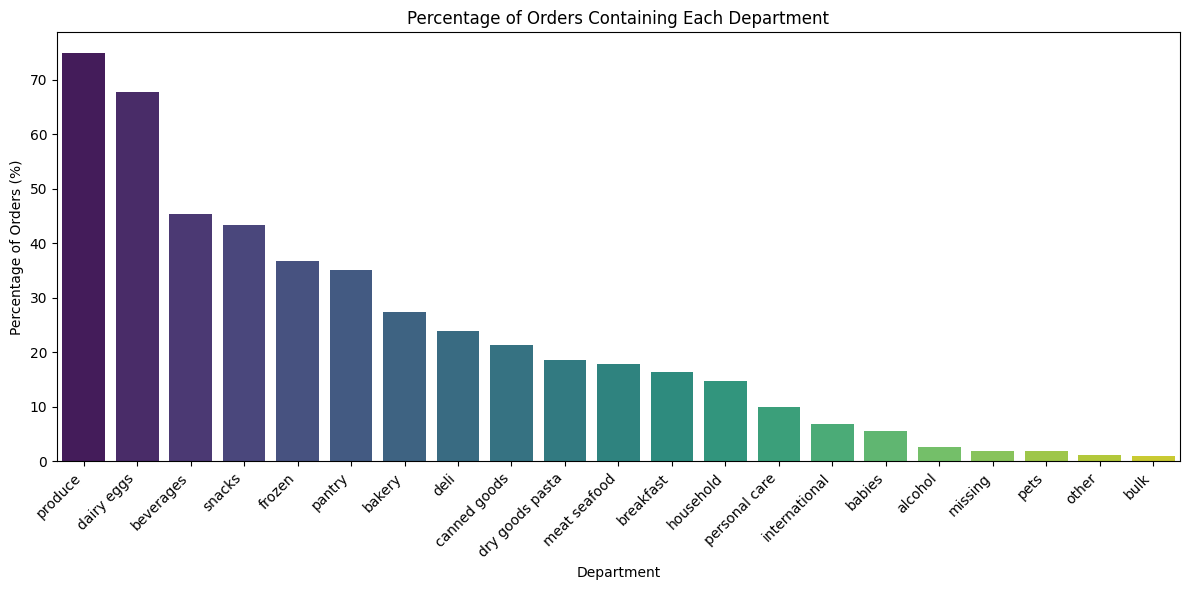

In [486]:
department_order_count = merged_data.groupby('department')['order_id'].nunique()

# Prozentuale Verteilung berechnen
total_orders = merged_data['order_id'].nunique()  # Gesamtzahl der Bestellungen
department_percentage = (department_order_count / total_orders) * 100

# Sortierung nach Prozentwerten
department_percentage = department_percentage.sort_values(ascending=False).reset_index()
department_percentage.columns = ['department', 'percentage']

# Visualisierung der prozentualen Verteilung
plt.figure(figsize=(12, 6))
sns.barplot(data=department_percentage, x='department', y='percentage', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Orders Containing Each Department')
plt.ylabel('Percentage of Orders (%)')
plt.xlabel('Department')
plt.tight_layout()
plt.show()

/tmp/ipykernel_12741/970685070.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_products, x='tip_probability', y='product_name', palette='Greens')


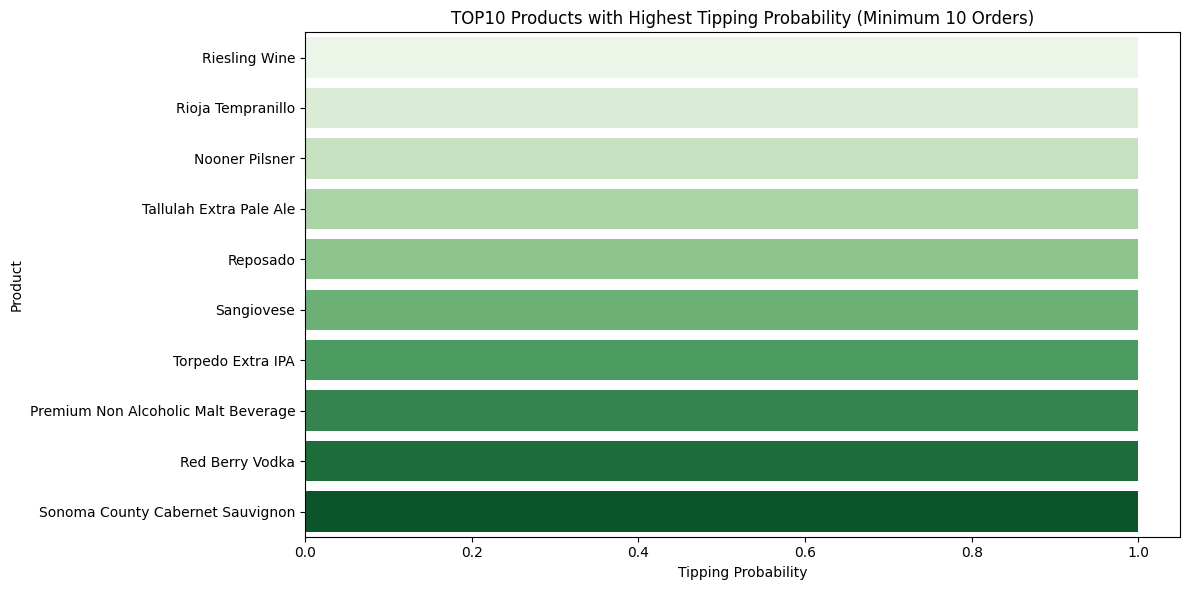

/tmp/ipykernel_12741/970685070.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=flop10_products, x='tip_probability', y='product_name', palette='Reds')


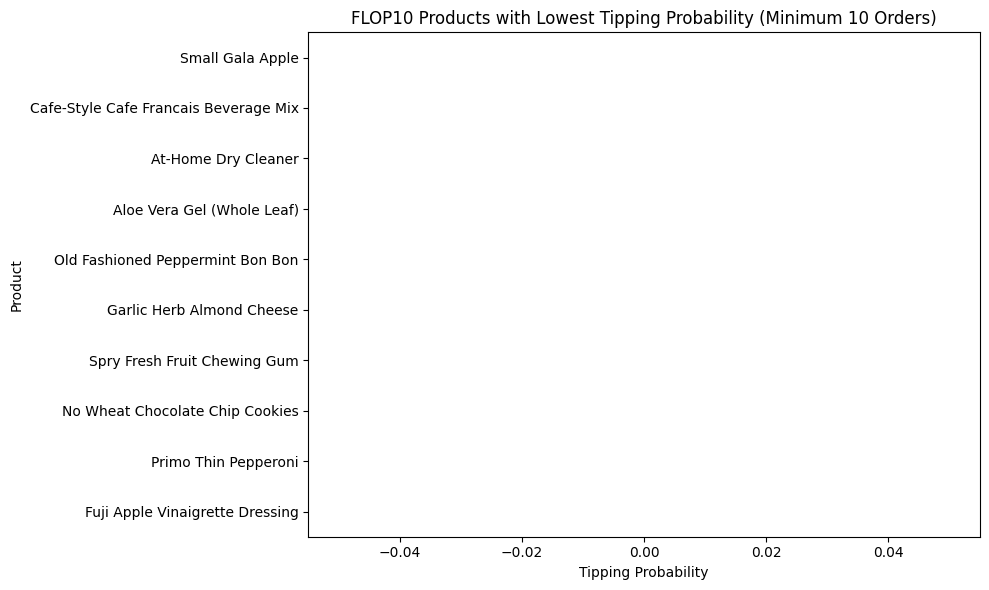

TOP10 Products with Highest Tipping Probability (Minimum 10 Orders):
                              product_name  total_tips  total_orders  \
37952                        Riesling Wine          12            12   
37971                    Rioja Tempranillo          11            11   
27388                       Nooner Pilsner          21            21   
43893              Tallulah Extra Pale Ale          17            17   
37691                             Reposado          11            11   
38823                           Sangiovese          11            11   
44942                    Torpedo Extra IPA          22            22   
35622  Premium Non Alcoholic Malt Beverage          20            20   
37231                      Red Berry Vodka          20            20   
41135     Sonoma County Cabernet Sauvignon          10            10   

       tip_probability  
37952              1.0  
37971              1.0  
27388              1.0  
43893              1.0  
37691        

In [487]:
product_tips_orders = merged_data.groupby('product_name').agg(
    total_tips=('tip', 'sum'),
    total_orders=('order_id', 'count')
).reset_index()

# Filter products with at least 10 orders
product_tips_orders = product_tips_orders[product_tips_orders['total_orders'] >= 10]

# Calculate tip probability as tips/orders
product_tips_orders['tip_probability'] = product_tips_orders['total_tips'] / product_tips_orders['total_orders']

# Sort by tip probability
product_tips_orders = product_tips_orders.sort_values(by='tip_probability', ascending=False)

# Get TOP10 and FLOP10 products
top10_products = product_tips_orders.head(10)
flop10_products = product_tips_orders.tail(10)

# Visualize TOP10 products
plt.figure(figsize=(12, 6))
sns.barplot(data=top10_products, x='tip_probability', y='product_name', palette='Greens')
plt.title('TOP10 Products with Highest Tipping Probability (Minimum 10 Orders)')
plt.xlabel('Tipping Probability')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Visualize FLOP10 products
plt.figure(figsize=(10, 6))
sns.barplot(data=flop10_products, x='tip_probability', y='product_name', palette='Reds')
plt.title('FLOP10 Products with Lowest Tipping Probability (Minimum 10 Orders)')
plt.xlabel('Tipping Probability')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Display the results
print("TOP10 Products with Highest Tipping Probability (Minimum 10 Orders):")
print(top10_products)

print("\nFLOP10 Products with Lowest Tipping Probability (Minimum 10 Orders):")
print(flop10_products)

print(product_tips_orders)

In [488]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report
import numpy as np

# Prepare data
# One-hot encode departments and top/bottom products
merged_data['is_top_product'] = merged_data['product_name'].isin(top10_products['product_name'])
merged_data['is_flop_product'] = merged_data['product_name'].isin(flop10_products['product_name'])

# One-hot encode department
encoder = OneHotEncoder(drop='first', sparse_output=False)
departments_encoded = encoder.fit_transform(merged_data[['department']])
department_columns = encoder.get_feature_names_out(['department'])

# Create feature set
X = pd.DataFrame(departments_encoded, columns=department_columns)
X['is_top_product'] = merged_data['is_top_product']
X['is_flop_product'] = merged_data['is_flop_product']

# Target variable
y = merged_data['tip']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model 1: Using department only
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(X_train[department_columns], y_train)

# Model 2: Adding specific products
model_2 = LogisticRegression(max_iter=1000)
model_2.fit(X_train, y_train)

# Evaluate models
log_loss_1 = log_loss(y_test, model_1.predict_proba(X_test[department_columns]))
log_loss_2 = log_loss(y_test, model_2.predict_proba(X_test))

print(f"Log Loss (Model 1 - Department Only): {log_loss_1:.7f}")
print(f"Log Loss (Model 2 - Department + Products): {log_loss_2:.7f}")

# Compare models
if log_loss_2 < log_loss_1:
    print("Adding specific products improves the model, indicating they have an additional effect on tipping probability.")
elif log_loss_1 == log_loss_1:
    print("Same result")
else:
    print("Spezi")

# Optional: Examine coefficients for interpretation
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_2.coef_[0]
}).sort_values(by='Coefficient', ascending=False)


print(coefficients)

Log Loss (Model 1 - Department Only): 0.6795520
Log Loss (Model 2 - Department + Products): 0.6795491
Adding specific products improves the model, indicating they have an additional effect on tipping probability.
                       Feature  Coefficient
20              is_top_product     0.115806
21             is_flop_product    -0.101749
4              department_bulk    -1.203203
0            department_babies    -1.453476
6        department_dairy eggs    -1.469592
3         department_breakfast    -1.530803
18          department_produce    -1.554058
12     department_meat seafood    -1.646649
16    department_personal care    -1.714347
13          department_missing    -1.727707
10        department_household    -1.737209
7              department_deli    -1.740000
19           department_snacks    -1.763601
14            department_other    -1.766401
11    department_international    -1.801565
8   department_dry goods pasta    -1.804130
1            department_bakery    -1.88


### Frage 3:
Gibt es einen Zusammenhang zwischen dem Trinkgeldverhalten und der Tageszeit, dem 
Wochentag, oder dem Zeitabstand zur vorhergehenden Bestellung?


#### Tageszeit & Trinkgeldverhalten

In [377]:
# Query: Anzahl der Bestellungen pro Wochentag
result_dow = session.query(
    Order.day_of_the_week,
    func.count().label('total_orders'),  # Gesamtzahl der Bestellungen
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  # Anzahl der Bestellungen mit Trinkgeld (True = 1, False = 0)
).group_by(Order.day_of_the_week).all()

result_dow_tips = session.query(
    Order.day_of_the_week,
    func.sum(case((Order.tips == True, 1), else_=0)).label('tips_given'),  # Anzahl Bestellungen mit Trinkgeld
    func.sum(case((Order.tips == False, 1), else_=0)).label('no_tips')    # Anzahl Bestellungen ohne Trinkgeld
).group_by(Order.day_of_the_week).all()

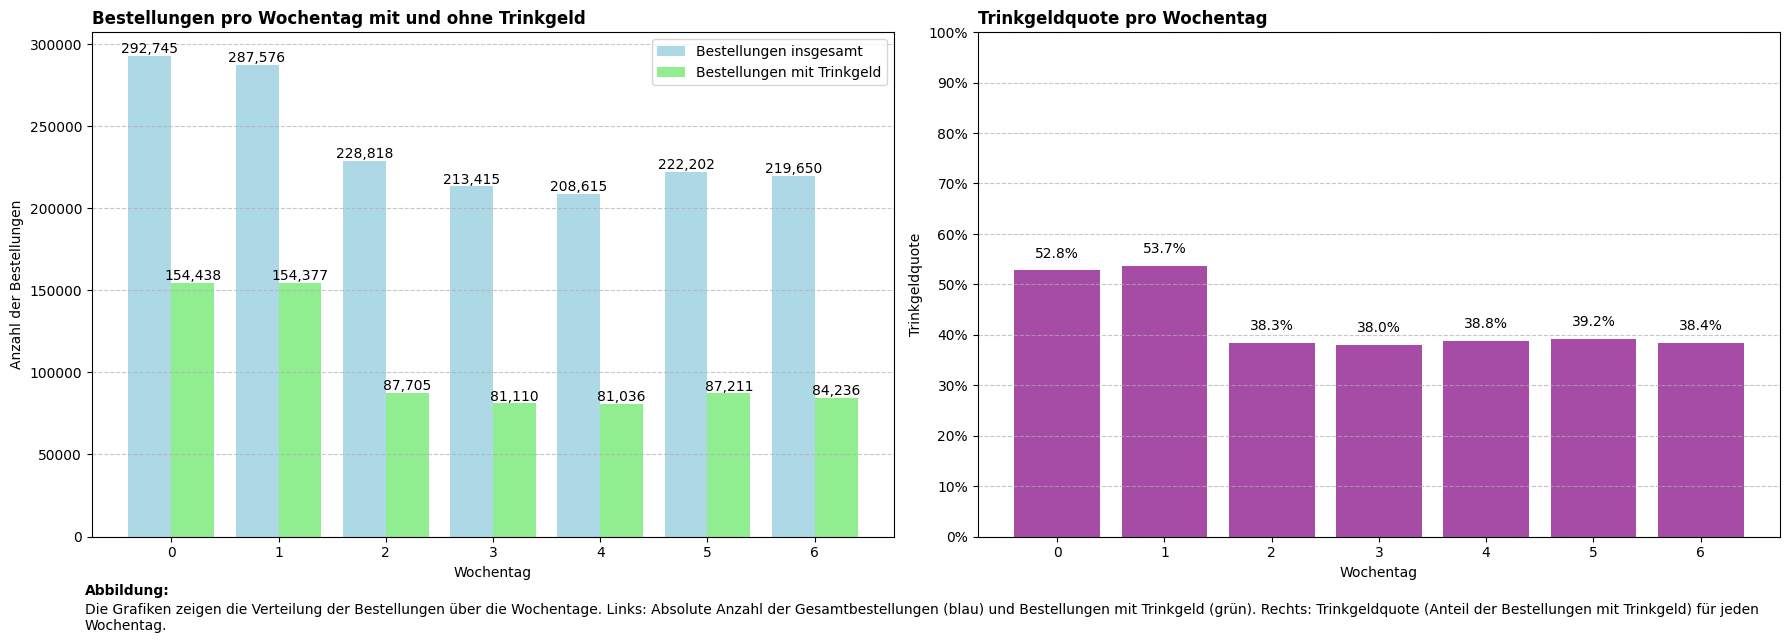

In [384]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Daten vorbereiten
width = 0.4
x = range(len(days))

# Diagramm 1: Gesamtbestellungen und Bestellungen mit Trinkgeld
bars1 = ax1.bar(x, total_orders, width, label='Bestellungen insgesamt', color='lightblue')
bars2 = ax1.bar([i + width for i in x], total_tips, width, label='Bestellungen mit Trinkgeld', 
                color='lightgreen')

# Formatierung Diagramm 1
ax1.set_xlabel('Wochentag')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen pro Wochentag mit und ohne Trinkgeld', 
              loc='left', weight='bold')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels(days, rotation=0)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# Werte über den Balken für Diagramm 1
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Diagramm 2: Tip-Quote
bars3 = ax2.bar(days, tip_ratios, color='purple', alpha=0.7)

# Formatierung Diagramm 2
ax2.set_xlabel('Wochentag')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_title('Trinkgeldquote pro Wochentag', 
              loc='left', weight='bold')
ax2.set_ylim(0, 1)
ax2.set_yticks([i / 10 for i in range(0, 11)])
ax2.set_yticklabels([f"{i * 10}%" for i in range(0, 11)])
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Werte über den Balken für Diagramm 2
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.02,
            f'{height:.1%}', ha='center', va='bottom', fontsize=10)

# Bildunterschrift
description = ('Die Grafiken zeigen die Verteilung der Bestellungen über die Wochentage. '
              'Links: Absolute Anzahl der Gesamtbestellungen (blau) und Bestellungen mit Trinkgeld (grün). '
              'Rechts: Trinkgeldquote (Anteil der Bestellungen mit Trinkgeld) für jeden Wochentag.')

fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.055, description, wrap=True)

plt.tight_layout()
plt.show()

In [380]:
data = [
    {'day_of_the_week': row[0], 'tips_given': row[1], 'no_tips': row[2]}
    for row in result_dow_tips
]
df = pd.DataFrame(data)

# Kontingenztabelle erstellen
contingency_table = df.set_index('day_of_the_week')[['tips_given', 'no_tips']]

In [381]:
# Chi-Quadrat-Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Tabellenausgabe: Vergleich von beobachteten und erwarteten Werten
observed = contingency_table.values  # Beobachtete Werte
expected = expected  # Erwartete Werte

# Vergleichstabelle erstellen
comparison_data = []
for i, day in enumerate(contingency_table.index):
    comparison_data.append([
        day,  # Wochentag
        observed[i][0],  # Beobachtet: Trinkgeld gegeben
        expected[i][0],  # Erwartet: Trinkgeld gegeben
        observed[i][1],  # Beobachtet: Kein Trinkgeld
        expected[i][1],  # Erwartet: Kein Trinkgeld
    ])

# Tabellenkopf
headers = ["Wochentag", "Beobachtet (Tip gegeben)", "Erwartet (Tip gegeben)",
           "Beobachtet (kein Tip)", "Erwartet (kein Tip)"]

# Tabelle formatieren
print("\nVergleich der beobachteten und erwarteten Werte:")
table_markdown = tabulate(comparison_data, headers=headers, tablefmt="pipe")
display(Markdown(table_markdown))

# Ergebnisse des Chi²-Tests visualisieren
print("\nErgebnisse des Chi²-Tests:")
test_results = [
    ["Chi-Quadrat-Statistik", f"{chi2:.3f}"],
    ["p-Wert", f"{p}"],
    ["Freiheitsgrade", dof],
    ["Signifikanz", "Ja" if p < 0.05 else "Nein"]
]

# Tabellarische Ausgabe der Testergebnisse
table_results = tabulate(test_results, headers=["Metrik", "Wert"], tablefmt="pipe")
display(Markdown(table_results))



Vergleich der beobachteten und erwarteten Werte:


|   Wochentag |   Beobachtet (Tip gegeben) |   Erwartet (Tip gegeben) |   Beobachtet (kein Tip) |   Erwartet (kein Tip) |
|------------:|---------------------------:|-------------------------:|------------------------:|----------------------:|
|           0 |                     154438 |                 127755   |                  138307 |                164990 |
|           1 |                     154377 |                 125499   |                  133199 |                162077 |
|           2 |                      87705 |                  99857.1 |                  141113 |                128961 |
|           3 |                      81110 |                  93135.2 |                  132305 |                120280 |
|           4 |                      81036 |                  91040.4 |                  127579 |                117575 |
|           5 |                      87211 |                  96969.8 |                  134991 |                125232 |
|           6 |                      84236 |                  95856.1 |                  135414 |                123794 |


Ergebnisse des Chi²-Tests:


| Metrik                | Wert      |
|:----------------------|:----------|
| Chi-Quadrat-Statistik | 33249.758 |
| p-Wert                | 0.0       |
| Freiheitsgrade        | 6         |
| Signifikanz           | Ja        |

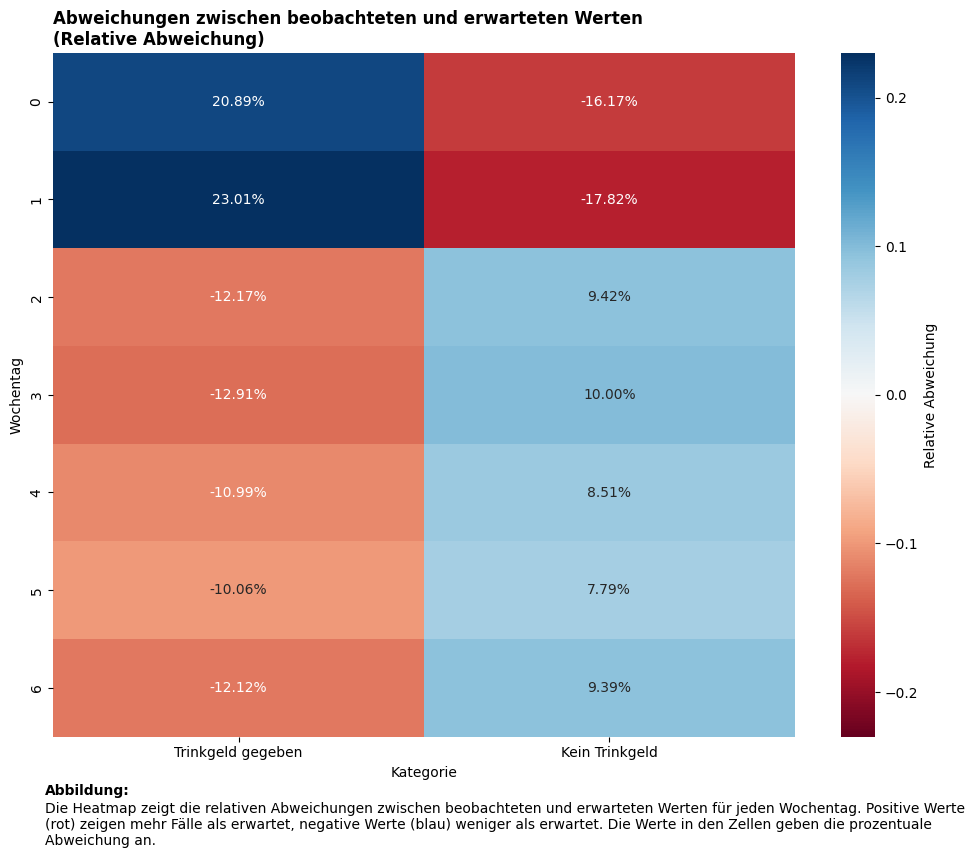

In [385]:
# Daten vorbereiten
observed = contingency_table.values  # Beobachtete Werte
expected = expected                  # Erwartete Werte
days = contingency_table.index       # Wochentage

# Abweichungen berechnen (relativ oder absolut)
deviation = (observed - expected) / expected  # Relative Abweichung (Prozentsatz)
# deviation = observed - expected  # Absolute Abweichung

# DataFrame für Heatmap erstellen
heatmap_data = pd.DataFrame(deviation, columns=["Trinkgeld gegeben", "Kein Trinkgeld"], index=days)

# Heatmap zeichnen
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplots_adjust(left=0.08)

# Abweichungen berechnen
deviation = (observed - expected) / expected

# DataFrame für Heatmap erstellen
heatmap_data = pd.DataFrame(
    deviation, 
    columns=["Trinkgeld gegeben", "Kein Trinkgeld"], 
    index=days
)

# Maximalen absoluten Wert finden für symmetrische Farbskala
max_abs_value = np.max(np.abs(deviation))
vmin = -max_abs_value
vmax = max_abs_value

# Heatmap erstellen
sns.heatmap(heatmap_data, 
            annot=True, 
            cmap="RdBu",
            center=0,
            fmt=".2%",  # Prozentformat
            cbar_kws={'label': 'Relative Abweichung'},
            vmin=vmin,
            vmax=vmax,
            ax=ax)

# Titel und Achsenbeschriftungen
ax.set_title('Abweichungen zwischen beobachteten und erwarteten Werten\n(Relative Abweichung)', 
             loc='left', 
             weight='bold')
ax.set_xlabel('Kategorie')
ax.set_ylabel('Wochentag')

# Bildunterschrift
description = ('Die Heatmap zeigt die relativen Abweichungen zwischen beobachteten und erwarteten Werten für jeden Wochentag. '
              'Positive Werte (rot) zeigen mehr Fälle als erwartet, negative Werte (blau) weniger als erwartet. '
              'Die Werte in den Zellen geben die prozentuale Abweichung an.')

fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

In [386]:
result = session.query(
    Order.day_of_the_week,
    func.cast(Order.tips, Integer).label('tips_given')  # Boolean auf Integer casten (1 für True, 0 für False)
).all()

df = pd.DataFrame(result, columns=['day_of_week', 'tips_given'])

In [388]:
# logistische Regression
# One-Hot-Encoding für 'day_of_week' (von numerischen Werten zu binären Spalten)
df_encoded = pd.get_dummies(df, columns=['day_of_week'], prefix='day')

# Feature und Zielvariable
X = df_encoded.drop('tips_given', axis=1)  
y = df_encoded['tips_given']               

X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model_day = LogisticRegression(max_iter=1000)  # max_iter erhöhen, wenn Konvergenzprobleme auftreten

model_day.fit(X_train_day, y_train_day)

y_pred = model_day.predict(X_test_day)

accuracy = accuracy_score(y_test_day, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

coefficients = model_day.coef_.flatten()
intercept = model_day.intercept_[0]

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
coeff_df = pd.DataFrame({
    'Day of Week': days_of_week,
    'Coefficient': coefficients
})

print("Intercept:", intercept)
display(coeff_df)

Accuracy: 58.62%
Intercept: -0.2588961467056162


Day of Week  Coefficient
0      Monday     0.366213
1     Tuesday     0.408174
2   Wednesday    -0.217128
3    Thursday    -0.232649
4      Friday    -0.194186
5    Saturday    -0.176958
6      Sunday    -0.212348

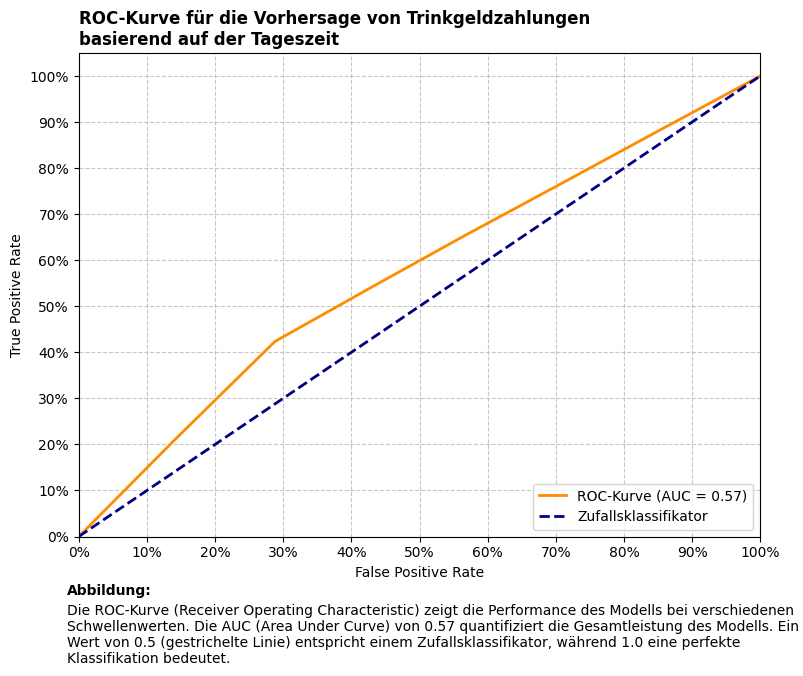

In [395]:

y_prob_day = model_day.predict_proba(X_test_day)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve
fpr, tpr, thresholds = roc_curve(y_test_day, y_prob_day)

# Berechnung der AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot der ROC-Kurve
fig, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(left=0.08)

# ROC-Kurve zeichnen
ax.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC-Kurve (AUC = {roc_auc:.2f})')

# Diagonale Linie (Zufallsklassifikator)
ax.plot([0, 1], [0, 1], color='navy', lw=2, 
        linestyle='--', label='Zufallsklassifikator')

# Achsen formatieren
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC-Kurve für die Vorhersage von Trinkgeldzahlungen\nbasierend auf der Tageszeit', 
             loc='left', weight='bold')

# Grid hinzufügen
ax.grid(True, linestyle='--', alpha=0.7)

# Legende
ax.legend(loc='lower right')

# Achsenbeschriftungen in Prozent
ax.set_xticks([i/10 for i in range(0, 11)])
ax.set_yticks([i/10 for i in range(0, 11)])
ax.set_xticklabels([f"{i*10}%" for i in range(0, 11)])
ax.set_yticklabels([f"{i*10}%" for i in range(0, 11)])

# Bildunterschrift
description = ('Die ROC-Kurve (Receiver Operating Characteristic) zeigt die Performance des Modells bei verschiedenen '
               'Schwellenwerten. Die AUC (Area Under Curve) von {:.2f} quantifiziert die Gesamtleistung des Modells. '
               'Ein Wert von 0.5 (gestrichelte Linie) entspricht einem Zufallsklassifikator, '
               'während 1.0 eine perfekte Klassifikation bedeutet.'.format(roc_auc))

fig.text(0.09, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.09, -0.11, description, wrap=True)

plt.tight_layout()
plt.show()

### Tageszeit & Trinkgeldverhalten

In [396]:
result_hours = session.query(
    Order.hour_of_day,
    func.count().label('total_orders'),  # Gesamtzahl der Bestellungen
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  # Anzahl der Bestellungen mit Trinkgeld (True = 1, False = 0)
).group_by(Order.hour_of_day).all()

result_hours_tips = session.query(
    Order.hour_of_day,
    func.sum(case((Order.tips == True, 1), else_=0)).label('tips_given'),  # Anzahl Bestellungen mit Trinkgeld
    func.sum(case((Order.tips == False, 1), else_=0)).label('no_tips')    # Anzahl Bestellungen ohne Trinkgeld
).group_by(Order.hour_of_day).all()

In [397]:
result_hours_data = [
    [row.hour_of_day, row.total_orders, row.total_tips, f"{row.total_tips / row.total_orders:.2%}"]
    for row in result_hours
]
headers_hours = ["Stunde", "Bestellungen gesamt", "Mit Trinkgeld", "Trinkgeldquote (%)"]

print("\nBestellungen pro Stunde:")
result_hours_markdown = tabulate(result_hours_data, headers=headers_hours, tablefmt="pipe")
display(Markdown(result_hours_markdown))


Bestellungen pro Stunde:


|   Stunde |   Bestellungen gesamt |   Mit Trinkgeld | Trinkgeldquote (%)   |
|---------:|----------------------:|----------------:|:---------------------|
|        0 |                 11224 |            6003 | 53.48%               |
|        1 |                  6211 |            3244 | 52.23%               |
|        2 |                  3773 |            1931 | 51.18%               |
|        3 |                  2762 |            1397 | 50.58%               |
|        4 |                  2748 |            1406 | 51.16%               |
|        5 |                  4764 |            2005 | 42.09%               |
|        6 |                 15004 |            6462 | 43.07%               |
|        7 |                 45141 |           19897 | 44.08%               |
|        8 |                 87513 |           39013 | 44.58%               |
|        9 |                125904 |           56300 | 44.72%               |
|       10 |                141401 |           61461 | 43.47%               |
|       11 |                139520 |           58575 | 41.98%               |
|       12 |                133612 |           55220 | 41.33%               |
|       13 |                136575 |           56133 | 41.10%               |
|       14 |                138816 |           57426 | 41.37%               |
|       15 |                138279 |           56499 | 40.86%               |
|       16 |                133434 |           54224 | 40.64%               |
|       17 |                110832 |           44257 | 39.93%               |
|       18 |                 88464 |           35118 | 39.70%               |
|       19 |                 67899 |           36331 | 53.51%               |
|       20 |                 50955 |           27821 | 54.60%               |
|       21 |                 38382 |           21782 | 56.75%               |
|       22 |                 30195 |           16934 | 56.08%               |
|       23 |                 19613 |           10674 | 54.42%               |

In [398]:
# SQL Query mit der Kategorisierung der Stunden
result_hours_grouped = session.query(
    case(
        (Order.hour_of_day.between(6, 11), 'Morgens'),
        (Order.hour_of_day.between(12, 17), 'Mittags'),
        (Order.hour_of_day.between(18, 23), 'Abends'),
        else_='Nachts'
    ).label('time_of_day'),
    func.count(Order.order_id).label('total_orders'),
    func.sum(func.cast(Order.tips, Integer)).label('orders_with_tips'),
    func.count(Order.order_id) - func.sum(func.cast(Order.tips, Integer)).label('orders_without_tips'),
    (func.sum(func.cast(Order.tips, Integer)) / func.count(Order.order_id)).label('tip_percentage'),
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')
).group_by('time_of_day').all()

# Ergebnisse von result_hours_grouped formatieren
result_hours_grouped_data = [
    [
        row.time_of_day,
        row.total_orders,
        row.orders_with_tips,
        row.total_orders - row.orders_with_tips,
        f"{row.tip_percentage:.2%}",
        row.total_tips
    ]
    for row in result_hours_grouped
]
headers_hours_grouped = [
    "Tageszeit", 
    "Bestellungen gesamt", 
    "Mit Trinkgeld", 
    "Ohne Trinkgeld", 
    "Trinkgeldquote (%)", 
    "Gesamtes Trinkgeld"
]

print("\nBestellungen pro Tageszeit:")
result_hours_grouped_markdown = tabulate(result_hours_grouped_data, headers=headers_hours_grouped, tablefmt="pipe")
display(Markdown(result_hours_grouped_markdown))


Bestellungen pro Tageszeit:


| Tageszeit   |   Bestellungen gesamt |   Mit Trinkgeld |   Ohne Trinkgeld | Trinkgeldquote (%)   |   Gesamtes Trinkgeld |
|:------------|----------------------:|----------------:|-----------------:|:---------------------|---------------------:|
| Abends      |                295508 |          148660 |           146848 | 50.31%               |               148660 |
| Mittags     |                791548 |          323759 |           467789 | 40.90%               |               323759 |
| Morgens     |                554483 |          241708 |           312775 | 43.59%               |               241708 |
| Nachts      |                 31482 |           15986 |            15496 | 50.78%               |                15986 |

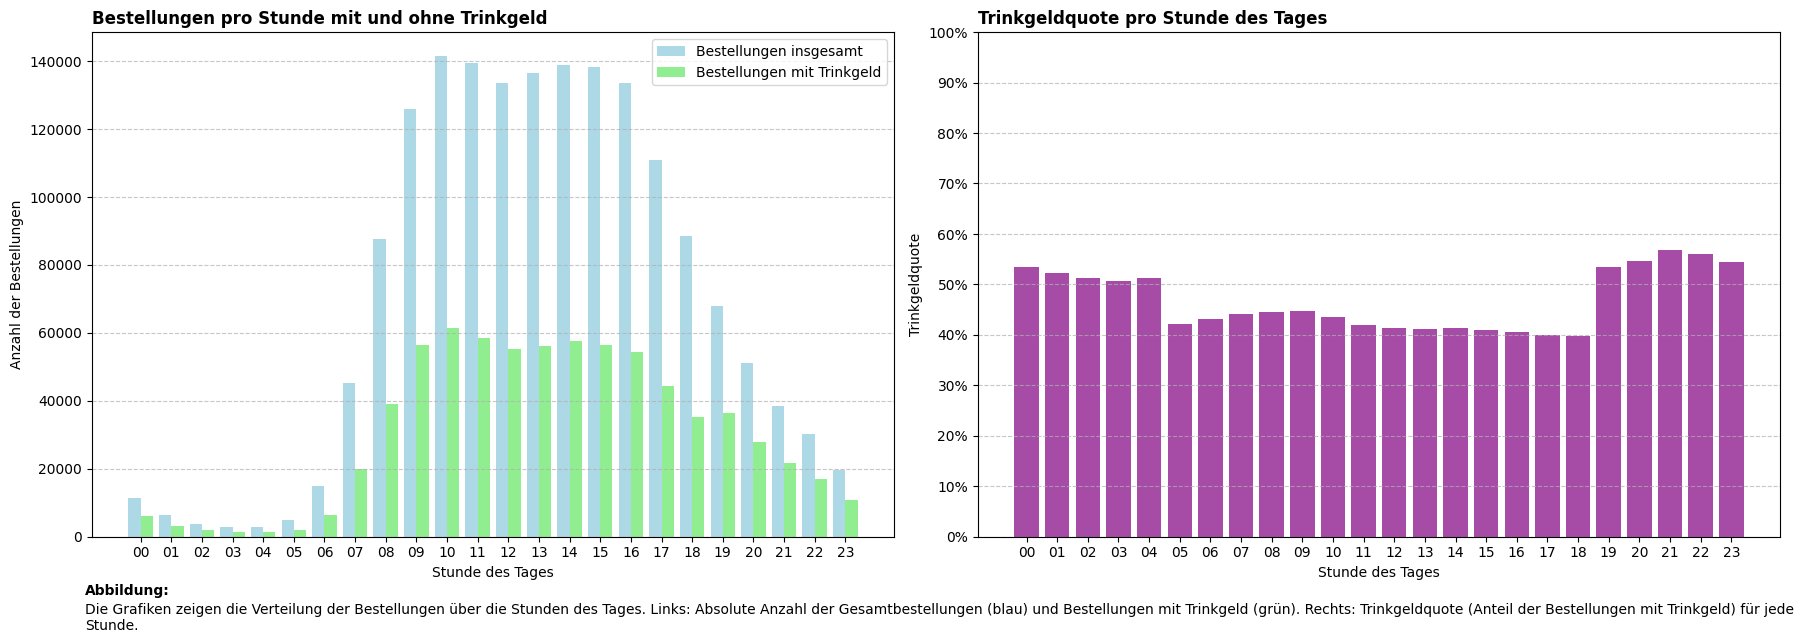

In [404]:
# Daten für das erste Diagramm
hours = [row.hour_of_day for row in result_hours]
total_orders = [row.total_orders for row in result_hours]
total_tips = [row.total_tips if row.total_tips else 0 for row in result_hours]

# Berechnung der Tip-Quote für das zweite Diagramm
tip_ratios = [row.total_tips / row.total_orders if row.total_orders > 0 else 0 for row in result_hours]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Daten vorbereiten
width = 0.4
x = range(len(hours))

# Diagramm 1: Gesamtbestellungen und Bestellungen mit Trinkgeld
bars1 = ax1.bar(x, total_orders, width, label='Bestellungen insgesamt', color='lightblue')
bars2 = ax1.bar([i + width for i in x], total_tips, width, label='Bestellungen mit Trinkgeld', 
                color='lightgreen')

# Formatierung Diagramm 1
ax1.set_xlabel('Stunde des Tages')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen pro Stunde mit und ohne Trinkgeld', 
              loc='left', weight='bold')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels([f"{h:02d}" for h in hours])
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# Diagramm 2: Trinkgeldquote
bars3 = ax2.bar(hours, tip_ratios, color='purple', alpha=0.7)

# Formatierung Diagramm 2
ax2.set_xlabel('Stunde des Tages')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_title('Trinkgeldquote pro Stunde des Tages', 
              loc='left', weight='bold')
ax2.set_ylim(0, 1)
ax2.set_yticks([i / 10 for i in range(0, 11)])
ax2.set_yticklabels([f"{i * 10}%" for i in range(0, 11)])
ax2.set_xticks(hours)
ax2.set_xticklabels([f"{h:02d}" for h in hours])
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Bildunterschrift
description = ('Die Grafiken zeigen die Verteilung der Bestellungen über die Stunden des Tages. '
              'Links: Absolute Anzahl der Gesamtbestellungen (blau) und Bestellungen mit Trinkgeld (grün). '
              'Rechts: Trinkgeldquote (Anteil der Bestellungen mit Trinkgeld) für jede Stunde.')

fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.055, description, wrap=True)

plt.tight_layout()
plt.show()

In [405]:
# Query:
result = session.query(
    Order.hour_of_day,
    func.cast(Order.tips, Integer).label('tips_given')  # Boolean auf Integer casten (1 für True, 0 für False)
).all()

In [407]:
# Erstelle DataFrame
df = pd.DataFrame(result, columns=['hour_of_day', 'tips_given'])

# Umwandlung in kategoriale Variablen
df['hour_of_day'] = df['hour_of_day'].astype('category')

X = df[['hour_of_day']]  
y = df['tips_given']  

# Preprocessing mit OneHotEncoder für day_of_week und hour_of_day
preprocessor = ColumnTransformer(
    transformers=[
        ('hour_of_day', OneHotEncoder(), ['hour_of_day'])
    ]
)

# Aufteilen der Daten in Trainings- und Testdatensatz
X_train_hour, X_test_hour, y_train_hour, y_test_hour = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pipeline erstellen
model_hour = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Vorverarbeitung
    ('classifier', LogisticRegression())  # Klassifikator
])

# Modell trainieren
model_hour.fit(X_train_hour, y_train_hour)

# Vorhersagen auf den Testdaten
y_pred_hour = model_hour.predict(X_test_hour)

# Genauigkeit des Modells
accuracy = accuracy_score(y_test_hour, y_pred_hour)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Zugriff auf Intercept und Koeffizienten
intercept = model_hour.named_steps['classifier'].intercept_[0]  # Der Intercept
coefficients = model_hour.named_steps['classifier'].coef_.flatten()  # Die Koeffizienten

# Wenn OneHotEncoder verwendet wird, benötigen wir die Feature-Namen, um sie den Koeffizienten zuzuordnen
# Dies ist besonders wichtig, da OneHotEncoding für die "day_of_week" und "hour_of_day"-Spalten zusätzliche Spalten erzeugt
# Holen der Spaltennamen des OneHotEncoders
ohe_feature_names = (
    model_hour.named_steps['preprocessor'].get_feature_names_out(input_features=['hour_of_day']).tolist()
)

# Erstelle DataFrame mit den Koeffizienten und den entsprechenden Feature-Namen
coeff_df = pd.DataFrame({
    'Feature': ohe_feature_names,
    'Coefficient': coefficients
})

# Ausgabe des Intercepts und der Koeffizienten
print("Intercept:", intercept)
display(coeff_df)


Accuracy: 57.65%
Intercept: -0.12848531701986954


Feature  Coefficient
0    hour_of_day__hour_of_day_0     0.319291
1    hour_of_day__hour_of_day_1     0.221361
2    hour_of_day__hour_of_day_2     0.148062
3    hour_of_day__hour_of_day_3     0.103731
4    hour_of_day__hour_of_day_4     0.098312
5    hour_of_day__hour_of_day_5    -0.166472
6    hour_of_day__hour_of_day_6    -0.150764
7    hour_of_day__hour_of_day_7    -0.117070
8    hour_of_day__hour_of_day_8    -0.081748
9    hour_of_day__hour_of_day_9    -0.079419
10  hour_of_day__hour_of_day_10    -0.133450
11  hour_of_day__hour_of_day_11    -0.192345
12  hour_of_day__hour_of_day_12    -0.228078
13  hour_of_day__hour_of_day_13    -0.239968
14  hour_of_day__hour_of_day_14    -0.219001
15  hour_of_day__hour_of_day_15    -0.238373
16  hour_of_day__hour_of_day_16    -0.256063
17  hour_of_day__hour_of_day_17    -0.274945
18  hour_of_day__hour_of_day_18    -0.285019
19  hour_of_day__hour_of_day_19     0.264714
20  hour_of_day__hour_of_day_20     0.316966
21  hour_of_day__hour_of_day_21     0.390402
22  hour_of_day__hour_of_day_22     0.357896
23  hour_of_day__hour_of_day_23     0.313719

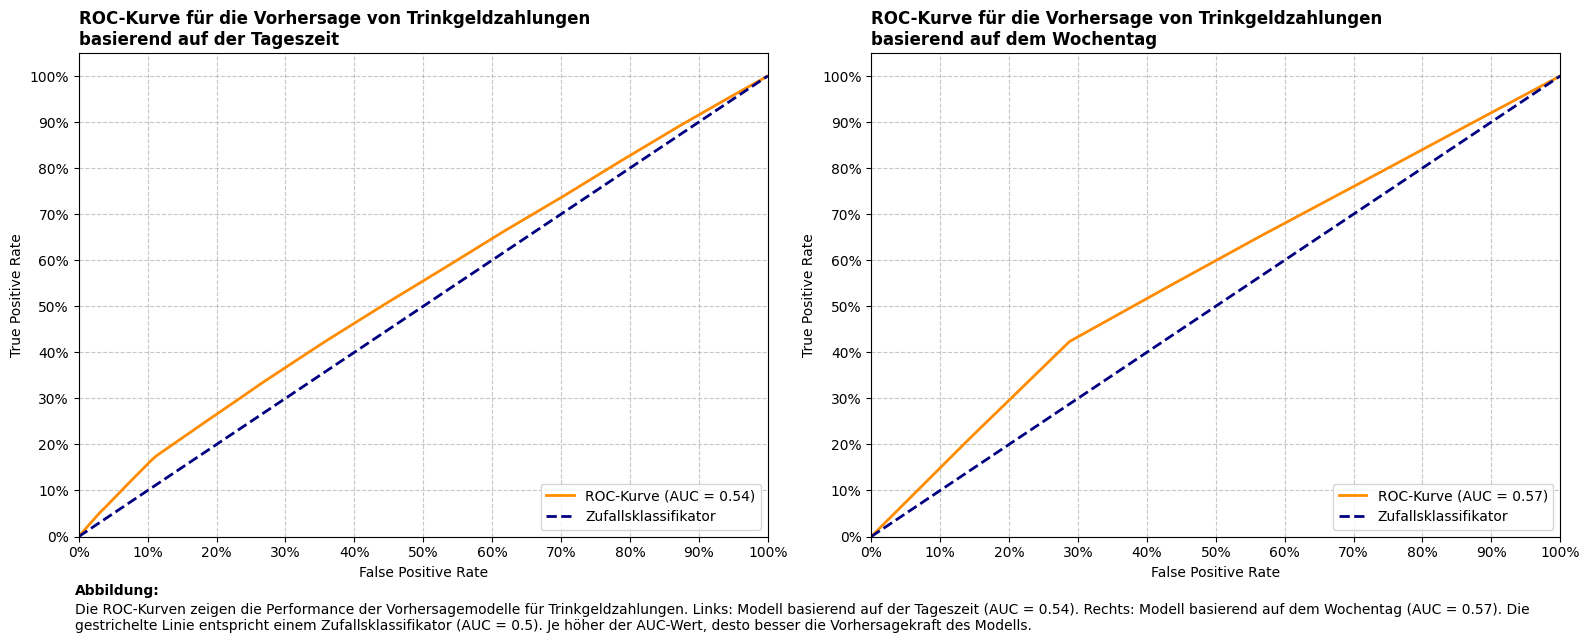

In [410]:

y_prob_hour = model_hour.predict_proba(X_test_hour)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Stunde des Tages
fpr_hour, tpr_hour, _ = roc_curve(y_test_hour, y_prob_hour)
roc_auc_hour = auc(fpr_hour, tpr_hour)

# Berechnung der Vorhersagewahrscheinlichkeiten für Wochentag
y_prob_day = model_day.predict_proba(X_test_day)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Wochentag
fpr_day, tpr_day, _ = roc_curve(y_test_day, y_prob_day)
roc_auc_day = auc(fpr_day, tpr_day)

# Erstelle Subplots für die beiden ROC-Kurven
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(left=0.08)

# Plot 1: ROC-Kurve für Stunde des Tages
ax1.plot(fpr_hour, tpr_hour, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_hour:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Formatierung Plot 1
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-Kurve für die Vorhersage von Trinkgeldzahlungen\nbasierend auf der Tageszeit', 
              loc='left', weight='bold')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='lower right')

# Achsenbeschriftungen in Prozent für Plot 1
ax1.set_xticks([i/10 for i in range(0, 11)])
ax1.set_yticks([i/10 for i in range(0, 11)])
ax1.set_xticklabels([f"{i*10}%" for i in range(0, 11)])
ax1.set_yticklabels([f"{i*10}%" for i in range(0, 11)])

# Plot 2: ROC-Kurve für Wochentag
ax2.plot(fpr_day, tpr_day, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_day:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Formatierung Plot 2
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-Kurve für die Vorhersage von Trinkgeldzahlungen\nbasierend auf dem Wochentag', 
              loc='left', weight='bold')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='lower right')

# Achsenbeschriftungen in Prozent für Plot 2
ax2.set_xticks([i/10 for i in range(0, 11)])
ax2.set_yticks([i/10 for i in range(0, 11)])
ax2.set_xticklabels([f"{i*10}%" for i in range(0, 11)])
ax2.set_yticklabels([f"{i*10}%" for i in range(0, 11)])

# Bildunterschrift
description = ('Die ROC-Kurven zeigen die Performance der Vorhersagemodelle für Trinkgeldzahlungen. '
               'Links: Modell basierend auf der Tageszeit (AUC = {:.2f}). '
               'Rechts: Modell basierend auf dem Wochentag (AUC = {:.2f}). '
               'Die gestrichelte Linie entspricht einem Zufallsklassifikator (AUC = 0.5). '
               'Je höher der AUC-Wert, desto besser die Vorhersagekraft des Modells.'.format(
                   roc_auc_hour, roc_auc_day))

fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.055, description, wrap=True)

plt.tight_layout()
plt.show()

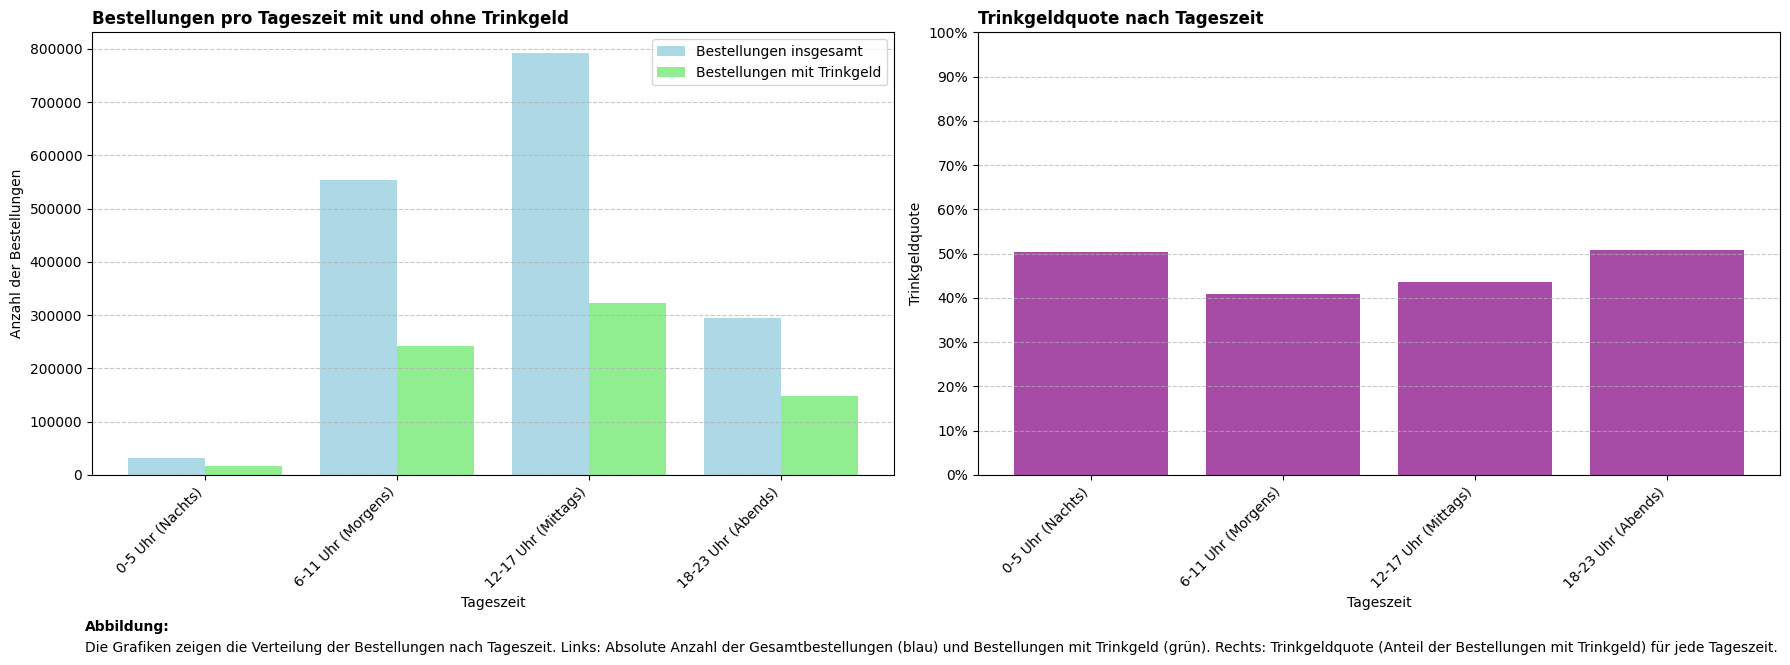

In [414]:
hours = [row.time_of_day for row in result_hours_grouped]
total_orders = [row.total_orders for row in result_hours_grouped]
total_tips = [row.total_tips if row.total_tips else 0 for row in result_hours_grouped]

time_mapping = {
    "Nachts": "0-5 Uhr",
    "Morgens": "6-11 Uhr",
    "Mittags": "12-17 Uhr",
    "Abends": "18-23 Uhr"
}

desired_order = ["Nachts", "Morgens", "Mittags", "Abends"]
sorted_data = sorted(
    zip(hours, total_orders, total_tips),
    key=lambda x: desired_order.index(x[0])  
)

sorted_hours = [row[0] for row in sorted_data]
sorted_total_orders = [row[1] for row in sorted_data]
sorted_total_tips = [row[2] for row in sorted_data]

sorted_hours_with_time = [f"{time_mapping[hour]} ({hour})" for hour in sorted_hours]

tip_percentage = [row.tip_percentage for row in result_hours_grouped]
df = pd.DataFrame({
    'time_of_day': sorted_hours,
    'tip_percentage': tip_percentage
})

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Daten vorbereiten
width = 0.4
x = range(len(sorted_hours))

# Diagramm 1: Gesamtbestellungen und Bestellungen mit Trinkgeld
bars1 = ax1.bar(x, sorted_total_orders, width, label='Bestellungen insgesamt', 
                color='lightblue')
bars2 = ax1.bar([i + width for i in x], sorted_total_tips, width, 
                label='Bestellungen mit Trinkgeld', color='lightgreen')

# Formatierung Diagramm 1
ax1.set_xlabel('Tageszeit')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen pro Tageszeit mit und ohne Trinkgeld', 
              loc='left', weight='bold')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels(sorted_hours_with_time, rotation=45, ha='right')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# Diagramm 2: Trinkgeldquote
bars3 = ax2.bar(sorted_hours_with_time, df['tip_percentage'], 
                color='purple', alpha=0.7)

# Formatierung Diagramm 2
ax2.set_xlabel('Tageszeit')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_title('Trinkgeldquote nach Tageszeit', 
              loc='left', weight='bold')
ax2.set_ylim(0, 1)
ax2.set_yticks([i / 10 for i in range(0, 11)])
ax2.set_yticklabels([f"{i * 10}%" for i in range(0, 11)])
ax2.set_xticks(range(len(sorted_hours_with_time)))
ax2.set_xticklabels(sorted_hours_with_time, rotation=45, ha='right')
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Bildunterschrift
description = ('Die Grafiken zeigen die Verteilung der Bestellungen nach Tageszeit. '
              'Links: Absolute Anzahl der Gesamtbestellungen (blau) und Bestellungen mit Trinkgeld (grün). '
              'Rechts: Trinkgeldquote (Anteil der Bestellungen mit Trinkgeld) für jede Tageszeit.')

fig.text(0.05, -0.06, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.095, description, wrap=True)

# Abstände optimieren
plt.tight_layout()

# Optional: Zusätzlicher Platz unten für die Beschreibung
plt.subplots_adjust(bottom=0.2)

plt.show()

In [415]:
data = [
    {'hour_of_day': row[0], 'tips_given': row[1], 'no_tips': row[2]}
    for row in result_hours_tips
]
df = pd.DataFrame(data)

# Kontingenztabelle erstellen
contingency_table = df.set_index('hour_of_day')[['tips_given', 'no_tips']]

In [416]:
# Chi-Quadrat-Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Tabellenausgabe: Vergleich von beobachteten und erwarteten Werten
observed = contingency_table.values  # Beobachtete Werte
expected = expected  # Erwartete Werte

# Vergleichstabelle erstellen
comparison_data = []
for i, day in enumerate(contingency_table.index):
    comparison_data.append([
        day,  # Wochentag
        observed[i][0],  # Beobachtet: Trinkgeld gegeben
        expected[i][0],  # Erwartet: Trinkgeld gegeben
        observed[i][1],  # Beobachtet: Kein Trinkgeld
        expected[i][1],  # Erwartet: Kein Trinkgeld
    ])

# Tabellenkopf
headers = ["Wochentag", "Beobachtet (Tip gegeben)", "Erwartet (Tip gegeben)",
           "Beobachtet (kein Tip)", "Erwartet (kein Tip)"]

# Tabelle formatieren
print("\nVergleich der beobachteten und erwarteten Werte:")
comparison_data_markdown = tabulate(comparison_data, headers=headers, tablefmt="pipe")
display(Markdown(comparison_data_markdown))

# Ergebnisse des Chi²-Tests visualisieren
print("\nErgebnisse des Chi²-Tests:")
test_results = [
    ["Chi-Quadrat-Statistik", f"{chi2:.3f}"],
    ["p-Wert", f"{p}"],
    ["Freiheitsgrade", dof],
    ["Signifikanz", "Ja" if p < 0.05 else "Nein"]
]

# Tabellarische Ausgabe der Testergebnisse
test_results_markdown = tabulate(test_results, headers=["Metrik", "Wert"], tablefmt="pipe")
display(Markdown(test_results_markdown))


Vergleich der beobachteten und erwarteten Werte:


|   Wochentag |   Beobachtet (Tip gegeben) |   Erwartet (Tip gegeben) |   Beobachtet (kein Tip) |   Erwartet (kein Tip) |
|------------:|---------------------------:|-------------------------:|------------------------:|----------------------:|
|           0 |                       6003 |                  4898.2  |                    5221 |               6325.8  |
|           1 |                       3244 |                  2710.51 |                    2967 |               3500.49 |
|           2 |                       1931 |                  1646.55 |                    1842 |               2126.45 |
|           3 |                       1397 |                  1205.35 |                    1365 |               1556.65 |
|           4 |                       1406 |                  1199.24 |                    1342 |               1548.76 |
|           5 |                       2005 |                  2079.03 |                    2759 |               2684.97 |
|           6 |                       6462 |                  6547.81 |                    8542 |               8456.19 |
|           7 |                      19897 |                 19699.7  |                   25244 |              25441.3  |
|           8 |                      39013 |                 38191    |                   48500 |              49322    |
|           9 |                      56300 |                 54945    |                   69604 |              70959    |
|          10 |                      61461 |                 61708    |                   79940 |              79693    |
|          11 |                      58575 |                 60887.1  |                   80945 |              78632.9  |
|          12 |                      55220 |                 58308.8  |                   78392 |              75303.2  |
|          13 |                      56133 |                 59601.9  |                   80442 |              76973.1  |
|          14 |                      57426 |                 60579.9  |                   81390 |              78236.1  |
|          15 |                      56499 |                 60345.5  |                   81780 |              77933.5  |
|          16 |                      54224 |                 58231.1  |                   79210 |              75202.9  |
|          17 |                      44257 |                 48367.5  |                   66575 |              62464.5  |
|          18 |                      35118 |                 38606    |                   53346 |              49858    |
|          19 |                      36331 |                 29631.4  |                   31568 |              38267.6  |
|          20 |                      27821 |                 22237    |                   23134 |              28718    |
|          21 |                      21782 |                 16750.1  |                   16600 |              21631.9  |
|          22 |                      16934 |                 13177.2  |                   13261 |              17017.8  |
|          23 |                      10674 |                  8559.19 |                    8939 |              11053.8  |


Ergebnisse des Chi²-Tests:


| Metrik                | Wert      |
|:----------------------|:----------|
| Chi-Quadrat-Statistik | 14819.908 |
| p-Wert                | 0.0       |
| Freiheitsgrade        | 23        |
| Signifikanz           | Ja        |

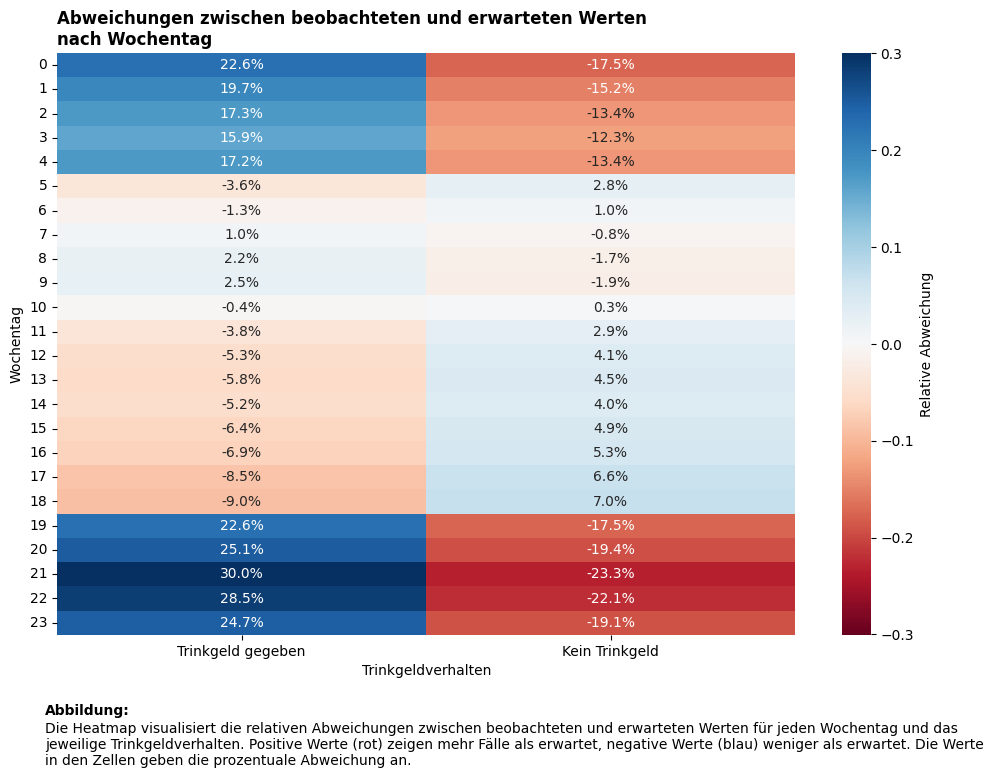

In [424]:
# Daten vorbereiten
observed = contingency_table.values  # Beobachtete Werte
expected = expected                  # Erwartete Werte
days = contingency_table.index       # Wochentage

# Abweichungen berechnen (relativ oder absolut)
deviation = (observed - expected) / expected  # Relative Abweichung (Prozentsatz)
# deviation = observed - expected  # Absolute Abweichung

# DataFrame für Heatmap erstellen
heatmap_data = pd.DataFrame(deviation, columns=["Trinkgeld gegeben", "Kein Trinkgeld"], index=days)

# Heatmap zeichnen
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplots_adjust(left=0.08)

# Maximalen absoluten Wert finden für symmetrische Farbskala
max_abs_value = np.max(np.abs(heatmap_data.values))
vmin = -max_abs_value
vmax = max_abs_value

# Heatmap erstellen
sns.heatmap(heatmap_data, 
            annot=True, 
            cmap="RdBu",
            center=0,
            fmt=".1%",  # Prozentformat
            cbar_kws={'label': 'Relative Abweichung'},
            vmin=vmin,
            vmax=vmax,
            ax=ax)

# Titel und Achsenbeschriftungen
ax.set_title('Abweichungen zwischen beobachteten und erwarteten Werten\nnach Wochentag', 
             loc='left', 
             weight='bold')
ax.set_xlabel('Trinkgeldverhalten')
ax.set_ylabel('Wochentag')

# Y-Achsen-Labels ausrichten
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Bildunterschrift
description = ('Die Heatmap visualisiert die relativen Abweichungen zwischen beobachteten und erwarteten Werten '
              'für jeden Wochentag und das jeweilige Trinkgeldverhalten. '
              'Positive Werte (rot) zeigen mehr Fälle als erwartet, negative Werte (blau) weniger als erwartet. '
              'Die Werte in den Zellen geben die prozentuale Abweichung an.')

fig.text(0.05, 0.1, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, 0.04, description, wrap=True)

# Layout anpassen
plt.tight_layout()

# Zusätzlicher Platz für die Beschreibung
plt.subplots_adjust(bottom=0.2)

plt.show()

In [427]:
result_hours_days = session.query(
    Order.hour_of_day,
    Order.day_of_the_week,
    func.count(Order.order_id).label('total_orders'),
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  
).group_by(Order.hour_of_day, Order.day_of_the_week).all()

# Daten sammeln
data = []
for row in result_hours_days:
    tip_quote = row.total_tips / row.total_orders if row.total_orders else 0
    data.append([
        row.hour_of_day,
        row.total_orders,
        row.total_tips,
        f"{tip_quote:.2f}"  # Formatierte Trinkgeldquote
    ])


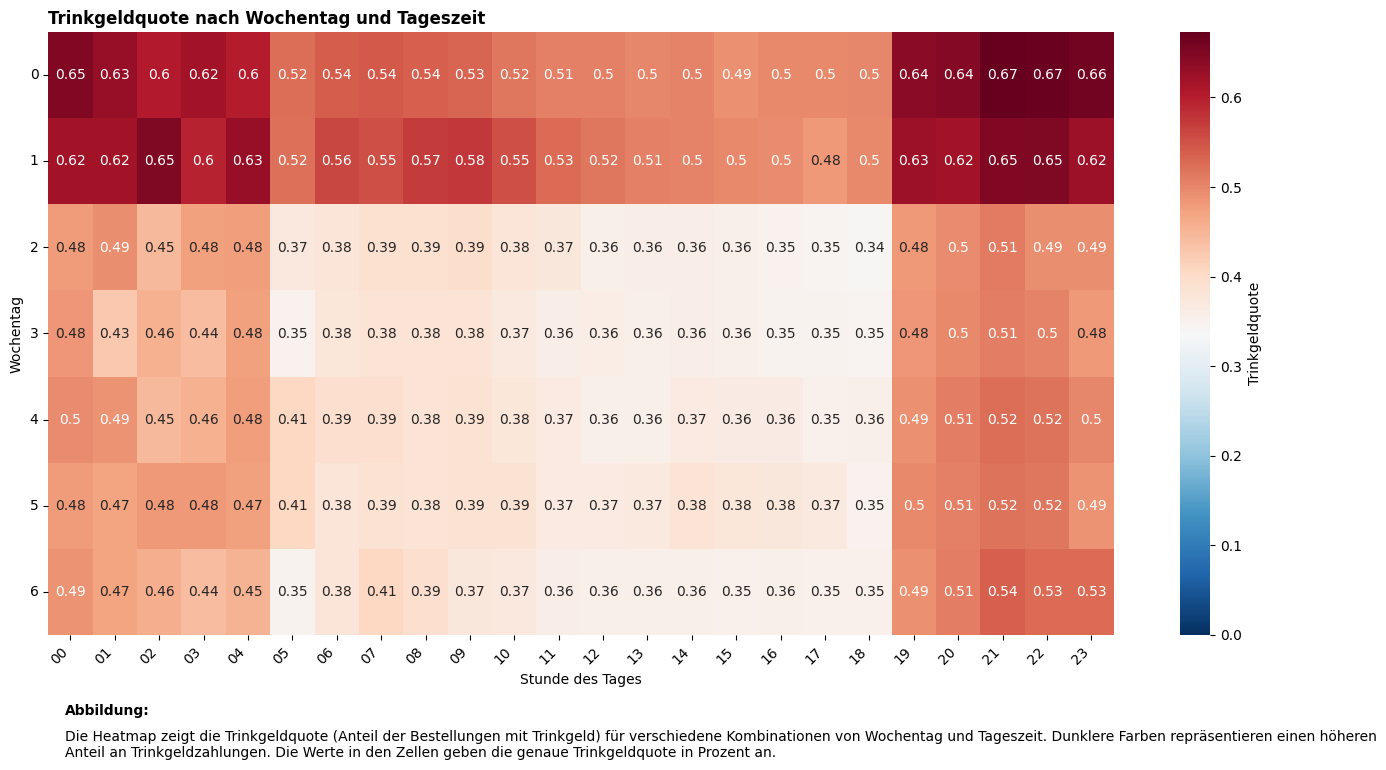

In [431]:

data = {
    'hour_of_day': [row.hour_of_day for row in result_hours_days],
    'day_of_the_week': [row.day_of_the_week for row in result_hours_days],  # Originale numerische Werte beibehalten
    'total_orders': [row.total_orders for row in result_hours_days],
    'total_tips': [row.total_tips if row.total_tips else 0 for row in result_hours_days],
}
df = pd.DataFrame(data)

# Zusätzliche Spalte für Tip-Quote berechnen
df['tip_ratio'] = df['total_tips'] / df['total_orders']

# Pivot-Tabelle erstellen (Stunden als Spalten, Wochentage als Zeilen)
heatmap_data = df.pivot(index='day_of_the_week', columns='hour_of_day', values='tip_ratio')

# Heatmap erstellen
fig, ax = plt.subplots(figsize=(14, 8))
plt.subplots_adjust(left=0.08)

# Pivot-Tabelle erstellen
heatmap_data = df.pivot(index='day_of_the_week', 
                       columns='hour_of_day', 
                       values='tip_ratio')

# Maximalen Wert finden für Farbskala
vmax = np.nanmax(heatmap_data.values)

# Heatmap erstellen
sns.heatmap(heatmap_data,
            annot=True,
            cmap='RdBu_r',  # Konsistente Farbpalette
            cbar_kws={'label': 'Trinkgeldquote'},
            xticklabels=[f"{int(h):02d}" for h in heatmap_data.columns],  # Führende Null für Stunden
            vmin=0,
            vmax=vmax,
            ax=ax)

# Titel und Achsenbeschriftungen
ax.set_title('Trinkgeldquote nach Wochentag und Tageszeit', 
             loc='left', 
             weight='bold')
ax.set_xlabel('Stunde des Tages')
ax.set_ylabel('Wochentag')

# Achsenbeschriftungen formatieren
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Bildunterschrift
description = ('Die Heatmap zeigt die Trinkgeldquote (Anteil der Bestellungen mit Trinkgeld) '
              'für verschiedene Kombinationen von Wochentag und Tageszeit. '
              'Dunklere Farben repräsentieren einen höheren Anteil an Trinkgeldzahlungen. '
              'Die Werte in den Zellen geben die genaue Trinkgeldquote in Prozent an.')

fig.text(0.05, 0.1, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, 0.05, description, wrap=True)

# Layout anpassen
plt.tight_layout()

# Zusätzlicher Platz für die Beschreibung
plt.subplots_adjust(bottom=0.2)

plt.show()

### Abstand vorheriger Bestellung & Trinkgeldverhalten

In [432]:
# Query: Zähle die Anzahl der Bestellungen mit und ohne Trinkgeld basierend auf den Tagen seit der vorherigen Bestellung
result = session.query(
    Order.days_since_prior_order,
    func.count(Order.order_id).label('total_orders'),
    func.sum(func.cast(Order.tips, Integer)).label('total_tips')  
).group_by(Order.days_since_prior_order).all()

result_test = session.query(
    Order.days_since_prior_order,
    Order.tips  # Hole die Trinkgelder direkt, ohne Aggregation
).all()

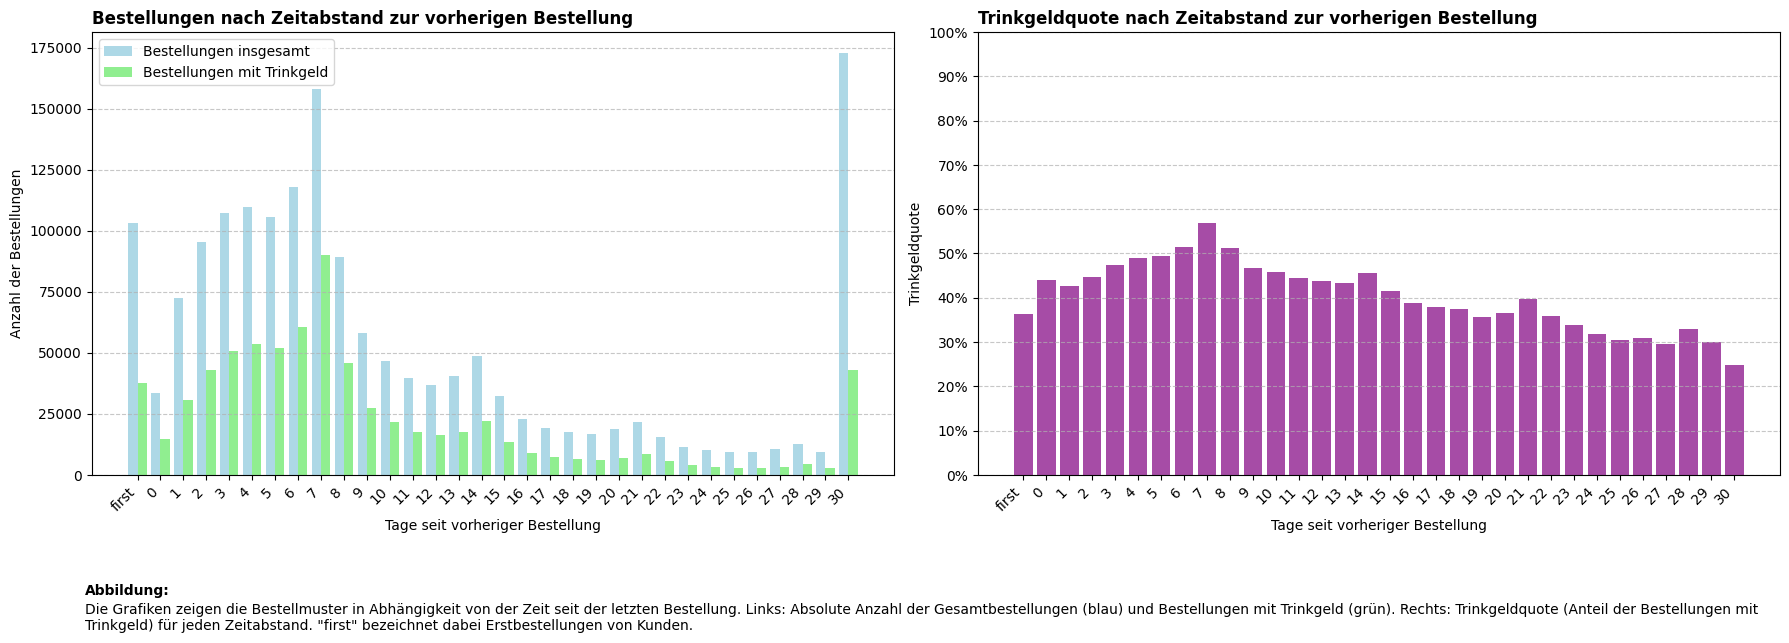

In [436]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Daten vorbereiten
width = 0.4
x = range(len(days_since_prior))

# Diagramm 1: Gesamtbestellungen und Bestellungen mit Trinkgeld
bars1 = ax1.bar(x, total_orders, width, label='Bestellungen insgesamt', 
                color='lightblue')
bars2 = ax1.bar([i + width for i in x], total_tips, width, 
                label='Bestellungen mit Trinkgeld', color='lightgreen')

# Formatierung Diagramm 1
ax1.set_xlabel('Tage seit vorheriger Bestellung')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen nach Zeitabstand zur vorherigen Bestellung', 
              loc='left', weight='bold')
ax1.set_xticks([i + width / 2 for i in x])
ax1.set_xticklabels(days_since_prior, rotation=45, ha='right')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# Diagramm 2: Trinkgeldquote
bars3 = ax2.bar(range(len(days_since_prior)), tip_ratios, 
                color='purple', alpha=0.7)

# Formatierung Diagramm 2
ax2.set_xlabel('Tage seit vorheriger Bestellung')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_title('Trinkgeldquote nach Zeitabstand zur vorherigen Bestellung', 
              loc='left', weight='bold')
ax2.set_ylim(0, 1)
ax2.set_yticks([i / 10 for i in range(0, 11)])
ax2.set_yticklabels([f"{i * 10}%" for i in range(0, 11)])
ax2.set_xticks(range(len(days_since_prior)))
ax2.set_xticklabels(days_since_prior, rotation=45, ha='right')
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Bildunterschrift
description = ('Die Grafiken zeigen die Bestellmuster in Abhängigkeit von der Zeit seit der letzten Bestellung. '
              'Links: Absolute Anzahl der Gesamtbestellungen (blau) und Bestellungen mit Trinkgeld (grün). '
              'Rechts: Trinkgeldquote (Anteil der Bestellungen mit Trinkgeld) für jeden Zeitabstand. '
              '"first" bezeichnet dabei Erstbestellungen von Kunden.')

fig.text(0.05, 0, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.055, description, wrap=True)

# Layout anpassen
plt.tight_layout()

# Zusätzlicher Platz für die Beschreibung
plt.subplots_adjust(bottom=0.2)

plt.show()

In [437]:
data = {
    "days_since_prior_order": [
        "first" if row.days_since_prior_order is None else int(row.days_since_prior_order)
        for row in result_test
    ],
    "tip_status": [
        "with_tip" if row.tips else "without_tip" for row in result_test
    ],
}

df = pd.DataFrame(data)

# Kreuztabelle erstellen
crosstab = pd.crosstab(
    index=df["days_since_prior_order"],  # Zeilen: Tage seit vorheriger Bestellung
    columns=df["tip_status"],            # Spalten: Mit oder ohne Trinkgeld
).fillna(0)

In [438]:
chi2, p, dof, expected = chi2_contingency(crosstab)

# Tabellenausgabe: Vergleich von beobachteten und erwarteten Werten
observed = crosstab.values  # Beobachtete Werte
expected = expected  # Erwartete Werte

# Vergleichstabelle erstellen
comparison_data = []
for i, day in enumerate(contingency_table.index):
    comparison_data.append([
        day,  # Wochentag
        observed[i][0],  # Beobachtet: Trinkgeld gegeben
        expected[i][0],  # Erwartet: Trinkgeld gegeben
        observed[i][1],  # Beobachtet: Kein Trinkgeld
        expected[i][1],  # Erwartet: Kein Trinkgeld
    ])

# Tabellenkopf
headers = ["Wochentag", "Beobachtet (Tip gegeben)", "Erwartet (Tip gegeben)",
           "Beobachtet (kein Tip)", "Erwartet (kein Tip)"]

# Tabelle formatieren
print("\nVergleich der beobachteten und erwarteten Werte:")
camparsion_data_markdown = tabulate(comparison_data, headers=headers, tablefmt="pipe")
display(Markdown(comparison_data_markdown))

# Ergebnisse des Chi²-Tests visualisieren
print("\nErgebnisse des Chi²-Tests:")
test_results = [
    ["Chi-Quadrat-Statistik", f"{chi2:.3f}"],
    ["p-Wert", f"{p}"],
    ["Freiheitsgrade", dof],
    ["Signifikanz", "Ja" if p < 0.05 else "Nein"]
]

# Tabellarische Ausgabe der Testergebnisse
test_results_markdown = tabulate(test_results, headers=["Metrik", "Wert"], tablefmt="pipe")
display(Markdown(test_results_markdown))


Vergleich der beobachteten und erwarteten Werte:


|   Wochentag |   Beobachtet (Tip gegeben) |   Erwartet (Tip gegeben) |   Beobachtet (kein Tip) |   Erwartet (kein Tip) |
|------------:|---------------------------:|-------------------------:|------------------------:|----------------------:|
|           0 |                       6003 |                  4898.2  |                    5221 |               6325.8  |
|           1 |                       3244 |                  2710.51 |                    2967 |               3500.49 |
|           2 |                       1931 |                  1646.55 |                    1842 |               2126.45 |
|           3 |                       1397 |                  1205.35 |                    1365 |               1556.65 |
|           4 |                       1406 |                  1199.24 |                    1342 |               1548.76 |
|           5 |                       2005 |                  2079.03 |                    2759 |               2684.97 |
|           6 |                       6462 |                  6547.81 |                    8542 |               8456.19 |
|           7 |                      19897 |                 19699.7  |                   25244 |              25441.3  |
|           8 |                      39013 |                 38191    |                   48500 |              49322    |
|           9 |                      56300 |                 54945    |                   69604 |              70959    |
|          10 |                      61461 |                 61708    |                   79940 |              79693    |
|          11 |                      58575 |                 60887.1  |                   80945 |              78632.9  |
|          12 |                      55220 |                 58308.8  |                   78392 |              75303.2  |
|          13 |                      56133 |                 59601.9  |                   80442 |              76973.1  |
|          14 |                      57426 |                 60579.9  |                   81390 |              78236.1  |
|          15 |                      56499 |                 60345.5  |                   81780 |              77933.5  |
|          16 |                      54224 |                 58231.1  |                   79210 |              75202.9  |
|          17 |                      44257 |                 48367.5  |                   66575 |              62464.5  |
|          18 |                      35118 |                 38606    |                   53346 |              49858    |
|          19 |                      36331 |                 29631.4  |                   31568 |              38267.6  |
|          20 |                      27821 |                 22237    |                   23134 |              28718    |
|          21 |                      21782 |                 16750.1  |                   16600 |              21631.9  |
|          22 |                      16934 |                 13177.2  |                   13261 |              17017.8  |
|          23 |                      10674 |                  8559.19 |                    8939 |              11053.8  |


Ergebnisse des Chi²-Tests:


| Metrik                | Wert      |
|:----------------------|:----------|
| Chi-Quadrat-Statistik | 53883.206 |
| p-Wert                | 0.0       |
| Freiheitsgrade        | 31        |
| Signifikanz           | Ja        |

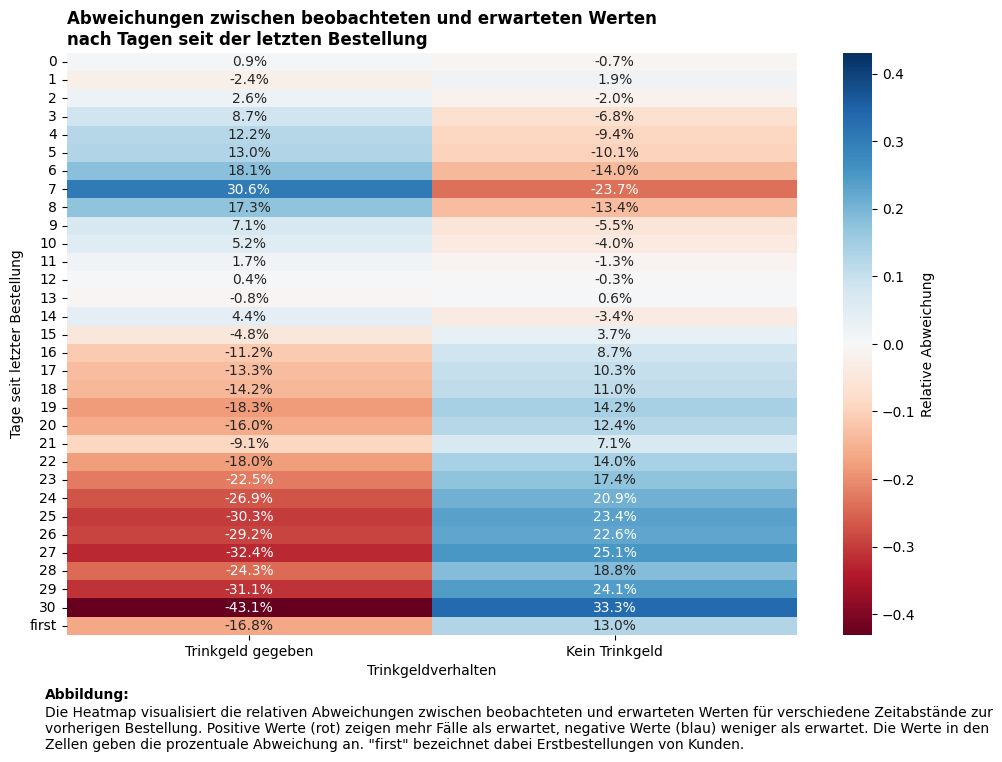

In [444]:
# Daten vorbereiten
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplots_adjust(left=0.08)

# Abweichungen berechnen
deviation = (observed - expected) / expected

# DataFrame für Heatmap erstellen
# Hier verwenden wir die original days als Index
heatmap_data = pd.DataFrame(
    deviation, 
    columns=["Trinkgeld gegeben", "Kein Trinkgeld"], 
    index=days  # days enthält die Werte für days_since_prior_order
)

# Maximalen absoluten Wert finden für symmetrische Farbskala
max_abs_value = np.max(np.abs(deviation))
vmin = -max_abs_value
vmax = max_abs_value

# Heatmap erstellen
sns.heatmap(heatmap_data, 
            annot=True, 
            cmap="RdBu",
            center=0,
            fmt=".1%",  # Prozentformat
            cbar_kws={'label': 'Relative Abweichung'},
            vmin=vmin,
            vmax=vmax,
            ax=ax)

# Titel und Achsenbeschriftungen
ax.set_title('Abweichungen zwischen beobachteten und erwarteten Werten\n'
             'nach Tagen seit der letzten Bestellung', 
             loc='left', 
             weight='bold')
ax.set_xlabel('Trinkgeldverhalten')
ax.set_ylabel('Tage seit letzter Bestellung')

# Y-Achsen-Labels ausrichten
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Bildunterschrift
description = ('Die Heatmap visualisiert die relativen Abweichungen zwischen beobachteten und erwarteten Werten '
              'für verschiedene Zeitabstände zur vorherigen Bestellung. '
              'Positive Werte (rot) zeigen mehr Fälle als erwartet, negative Werte (blau) weniger als erwartet. '
              'Die Werte in den Zellen geben die prozentuale Abweichung an. '
              '"first" bezeichnet dabei Erstbestellungen von Kunden.')

fig.text(0.05, 0.12, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, 0.06, description, wrap=True)

# Layout anpassen
plt.tight_layout()

# Zusätzlicher Platz für die Beschreibung
plt.subplots_adjust(bottom=0.2)

plt.show()

In [445]:
# Daten aus der Order-Tabelle extrahieren (inkl. Stunde des Tages)
result = session.query(
    Order.hour_of_day,
    Order.day_of_the_week,
    Order.days_since_prior_order,
    func.cast(Order.tips, Integer).label('tips_given')  # Boolean auf Integer casten (1 für True, 0 für False)
).all()

In [446]:
# Erstelle DataFrame
df = pd.DataFrame(result, columns=['hour_of_day', 'day_of_the_week', 'days_since_prior_order', 'tips_given'])

# Umwandlung in kategoriale Variablen
df['hour_of_day'] = df['hour_of_day'].astype('category')
df['day_of_the_week'] = df['day_of_the_week'].astype('category')
df['days_since_prior_order'] = df['days_since_prior_order'].astype('category')

X = df[['hour_of_day', 'day_of_the_week', 'days_since_prior_order']]  
y = df['tips_given']  

# Preprocessing mit OneHotEncoder für day_of_week und hour_of_day
preprocessor = ColumnTransformer(
    transformers=[
        ('hour_of_day', OneHotEncoder(), ['hour_of_day', 'day_of_the_week', 'days_since_prior_order'])
    ]
)

# Aufteilen der Daten in Trainings- und Testdatensatz
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Pipeline erstellen
model_all = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Vorverarbeitung
    ('classifier', LogisticRegression())  # Klassifikator
])

# Modell trainieren
model_all.fit(X_train_all, y_train_all)

# Vorhersagen auf den Testdaten
y_pred_all = model_all.predict(X_test_all)

# Genauigkeit des Modells
accuracy = accuracy_score(y_test_all, y_pred_all)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Zugriff auf Intercept und Koeffizienten
intercept = model_all.named_steps['classifier'].intercept_[0]  # Der Intercept
coefficients = model_all.named_steps['classifier'].coef_.flatten()  # Die Koeffizienten

# Wenn OneHotEncoder verwendet wird, benötigen wir die Feature-Namen, um sie den Koeffizienten zuzuordnen
# Dies ist besonders wichtig, da OneHotEncoding für die "day_of_week" und "hour_of_day"-Spalten zusätzliche Spalten erzeugt
# Holen der Spaltennamen des OneHotEncoders
ohe_feature_names = (
    model_all.named_steps['preprocessor'].get_feature_names_out(input_features=['hour_of_day', 'day_of_the_week', 'days_since_prior_order']).tolist()
)

# Erstelle DataFrame mit den Koeffizienten und den entsprechenden Feature-Namen
coeff_df = pd.DataFrame({
    'Feature': ohe_feature_names,
    'Coefficient': coefficients
})

# Ausgabe des Intercepts und der Koeffizienten
print("Intercept:", intercept)
display(coeff_df)

Accuracy: 61.46%
Intercept: -0.2577138480810668


Feature  Coefficient
0                 hour_of_day__hour_of_day_0     0.328639
1                 hour_of_day__hour_of_day_1     0.231733
2                 hour_of_day__hour_of_day_2     0.151920
3                 hour_of_day__hour_of_day_3     0.107983
4                 hour_of_day__hour_of_day_4     0.114304
..                                       ...          ...
58  hour_of_day__days_since_prior_order_27.0    -0.479697
59  hour_of_day__days_since_prior_order_28.0    -0.369656
60  hour_of_day__days_since_prior_order_29.0    -0.486733
61  hour_of_day__days_since_prior_order_30.0    -0.726265
62   hour_of_day__days_since_prior_order_nan    -0.172012

[63 rows x 2 columns]

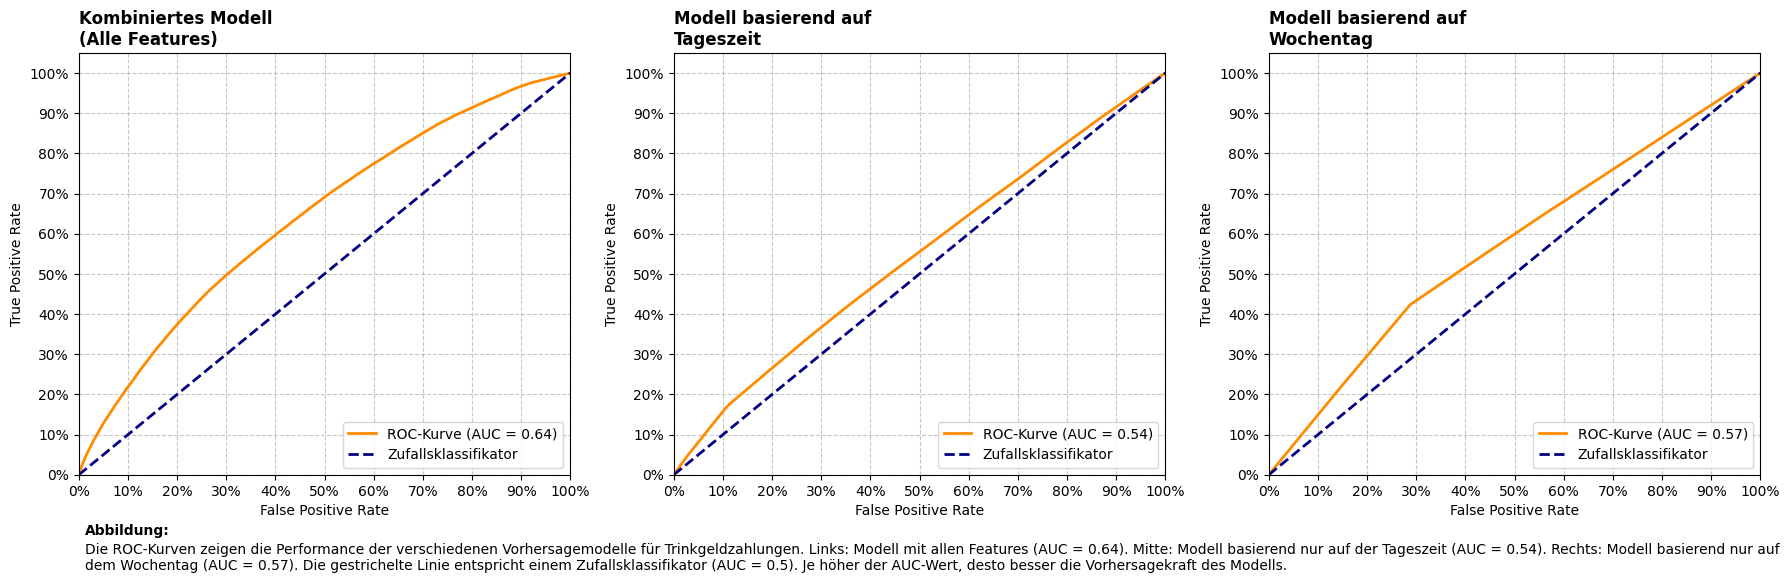

In [455]:

y_prob_hour = model_hour.predict_proba(X_test_hour)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Stunde des Tages
fpr_hour, tpr_hour, _ = roc_curve(y_test_hour, y_prob_hour)
roc_auc_hour = auc(fpr_hour, tpr_hour)

# Berechnung der Vorhersagewahrscheinlichkeiten für Wochentag
y_prob_day = model_day.predict_proba(X_test_day)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Wochentag
fpr_day, tpr_day, _ = roc_curve(y_test_day, y_prob_day)
roc_auc_day = auc(fpr_day, tpr_day)

# Berechnung der Vorhersagewahrscheinlichkeiten für Wochentag
y_prob_all = model_all.predict_proba(X_test_all)[:, 1]  # Nur die Wahrscheinlichkeit für die positive Klasse (1)

# Berechnung der ROC-Kurve für Wochentag
fpr_all, tpr_all, _ = roc_curve(y_test_all, y_prob_all)
roc_auc_all = auc(fpr_all, tpr_all)
# Erstelle Subplots für die beiden ROC-Kurven
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Plot 1: ROC-Kurve für alle Features
ax1.plot(fpr_all, tpr_all, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_all:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Plot 2: ROC-Kurve für Stunde des Tages
ax2.plot(fpr_hour, tpr_hour, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_hour:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Plot 3: ROC-Kurve für Wochentag
ax3.plot(fpr_day, tpr_day, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_day:.2f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Formatierung für alle Subplots
for ax, title in zip([ax1, ax2, ax3], 
                    ['Kombiniertes Modell\n(Alle Features aus Frage 3)',
                     'Modell basierend auf\nTageszeit',
                     'Modell basierend auf\nWochentag']):
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title, loc='left', weight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='lower right')
    
    # Prozentuale Achsenbeschriftungen
    ax.set_xticks([i/10 for i in range(0, 11)])
    ax.set_yticks([i/10 for i in range(0, 11)])
    ax.set_xticklabels([f"{i*10}%" for i in range(0, 11)])
    ax.set_yticklabels([f"{i*10}%" for i in range(0, 11)])

# Bildunterschrift
description = ('Die ROC-Kurven zeigen die Performance der verschiedenen Vorhersagemodelle für Trinkgeldzahlungen. '
               'Links: Modell mit allen Features (AUC = {:.2f}). '
               'Mitte: Modell basierend nur auf der Tageszeit (AUC = {:.2f}). '
               'Rechts: Modell basierend nur auf dem Wochentag (AUC = {:.2f}). '
               'Die gestrichelte Linie entspricht einem Zufallsklassifikator (AUC = 0.5). '
               'Je höher der AUC-Wert, desto besser die Vorhersagekraft des Modells.'.format(
                   roc_auc_all, roc_auc_hour, roc_auc_day))

fig.text(0.05, 0.1, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, 0.045, description, wrap=True)

# Layout anpassen
plt.tight_layout()

# Zusätzlicher Platz für die Beschreibung
plt.subplots_adjust(bottom=0.2)

plt.show()

---
## <h2 id="handlungsempfehlungen">Handlungsempfehlungen</h2>

In [457]:
# Generelle Handlungsempfehlungen ein Teil Marketing und ein Teil Disposition

# ToDos:

x alle tabellen als markdown tabellen ausgeben
x Alle Plots durchgucken ob Beschriftungen korrekt sind
x Konkrete Fragen hinzufügen
x überall wo chi² test gemacht wird korrigierte standardisierte residuen anzeigen in heatmap
- Kurze Interpretationen schreiben für die Auswertungen
x ERM Diagramm neu machen
- Power BI machen heute Abend
x Wochentage aus Tabellen entfernen
x plots mit raster austatten
x organic zu produkt analyse
x Kommentare die AI artig sind herausnehmen
x bei query in den comment schreib was gequeried wird
x heausfinden onb man diese FutureWarnings unterdrücken kann oder fixen kann
x log regressions model mit allen coolen features aus diesem notebook ausprobieren

morgen:
- EDA MArketing hinzufügen
- fix: Frage 1 -> kp welche Zellen zu welcher Teilaufgabe gehörten
- chi² test heatmaps: ändern zu prozentrualer abweichung anstatt korrikierte standardisierte pearson-Residuen (ist einfacher zu verstehen und anzuwenden)
- durchnummerierung Diagramme checken
- am Ende gucken ob alles nach reset korrekt durchläuft



In [513]:
def get_enhanced_features(session):  
    query = session.query(
        Order.order_id,
        Order.hour_of_day,
        Order.day_of_the_week,
        Order.days_since_prior_order,
        Order.tips.label('tips_given'),
        Order.user_id,
        # Alkohol-Produkte in Bestellung
        func.max(case((Department.department_name == 'alcohol', 1), else_=0)).label('has_alcohol'),
        # Tiefkühl-Produkte in Bestellung
        func.max(case((Department.department_name == 'frozen', 1), else_=0)).label('has_frozen'),
        # Organische Produkte
        func.sum(case((Product.product_name.like('%organic%'), 1), else_=0)).label('organic_count'),
        func.count(Product.product_id).label('total_products')
    ).select_from(Order).join(Einkaufskorb).join(Product).join(Department).group_by(
        Order.order_id,
        Order.hour_of_day,
        Order.day_of_the_week,
        Order.days_since_prior_order,
        Order.tips,
        Order.user_id
    )

    # Daten in DataFrame laden
    df = pd.read_sql(query.statement, session.bind)
    
    # Berechne organic_ratio
    df['organic_ratio'] = df['organic_count'] / df['total_products']
    
    # Berechne user_tip_ratio
    user_tips = df.groupby('user_id')['tips_given'].mean().reset_index()
    user_tips.columns = ['user_id', 'user_tip_ratio']
    
    # Merge mit Hauptdaten
    df = df.merge(user_tips, on='user_id', how='left')
    
    # Berechne user_order_count
    user_orders = df.groupby('user_id').size().reset_index()
    user_orders.columns = ['user_id', 'user_order_count']
    df = df.merge(user_orders, on='user_id', how='left')
    
    # Überprüfe die verfügbaren Spalten
    # print("Available columns:", df.columns.tolist())
    
    return df

def train_enhanced_model(df):
    # Umwandlung in kategoriale Variablen
    df['hour_of_day'] = df['hour_of_day'].astype('category')
    df['day_of_the_week'] = df['day_of_the_week'].astype('category')
    df['days_since_prior_order'] = df['days_since_prior_order'].astype('category')
    
    # Definiere Features
    categorical_features = ['hour_of_day', 'day_of_the_week', 'days_since_prior_order']
    numerical_features = ['has_alcohol', 'has_frozen', 'organic_ratio', 
                         'user_order_count', 'user_tip_ratio']
    
    X = df[categorical_features + numerical_features]
    y = df['tips_given']
    
    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_features),
            ('num', 'passthrough', numerical_features)
        ]
    )
    
    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Pipeline erstellen
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    
    # Modell trainieren
    model.fit(X_train, y_train)
    
    # Vorhersagen auf den Testdaten
    y_pred = model.predict(X_test)
    
    # Genauigkeit des Modells
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Zugriff auf Intercept und Koeffizienten
    intercept = model.named_steps['classifier'].intercept_[0]
    coefficients = model.named_steps['classifier'].coef_.flatten()
    
    # Feature-Namen generieren
    cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([cat_feature_names, numerical_features])
    
    # Erstelle DataFrame mit den Koeffizienten
    coeff_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Coefficient': coefficients
    })
    
    # Ausgabe des Intercepts und der Koeffizienten
    print("\nIntercept:", intercept)
    display(coeff_df)
    
    return model, accuracy, X_train, X_test, y_train, y_test

# Hauptausführung
try:
    # Daten holen
    enhanced_data = get_enhanced_features(session)
    print("\nShape of data:", enhanced_data.shape)
    
    # Model trainieren
    model, accuracy, X_train, X_test, y_train, y_test = train_enhanced_model(enhanced_data)
    
except Exception as e:
    print(f"Error occurred: {str(e)}")


Shape of data: (1673021, 13)
Accuracy: 80.16%

Intercept: -2.2693009832227595


Feature  Coefficient
0      hour_of_day_0     0.426254
1      hour_of_day_1     0.431302
2      hour_of_day_2     0.299711
3      hour_of_day_3     0.293028
4      hour_of_day_4     0.307641
..               ...          ...
63       has_alcohol     1.194336
64        has_frozen    -0.467190
65     organic_ratio     0.107948
66  user_order_count     0.001284
67    user_tip_ratio     5.922430

[68 rows x 2 columns]

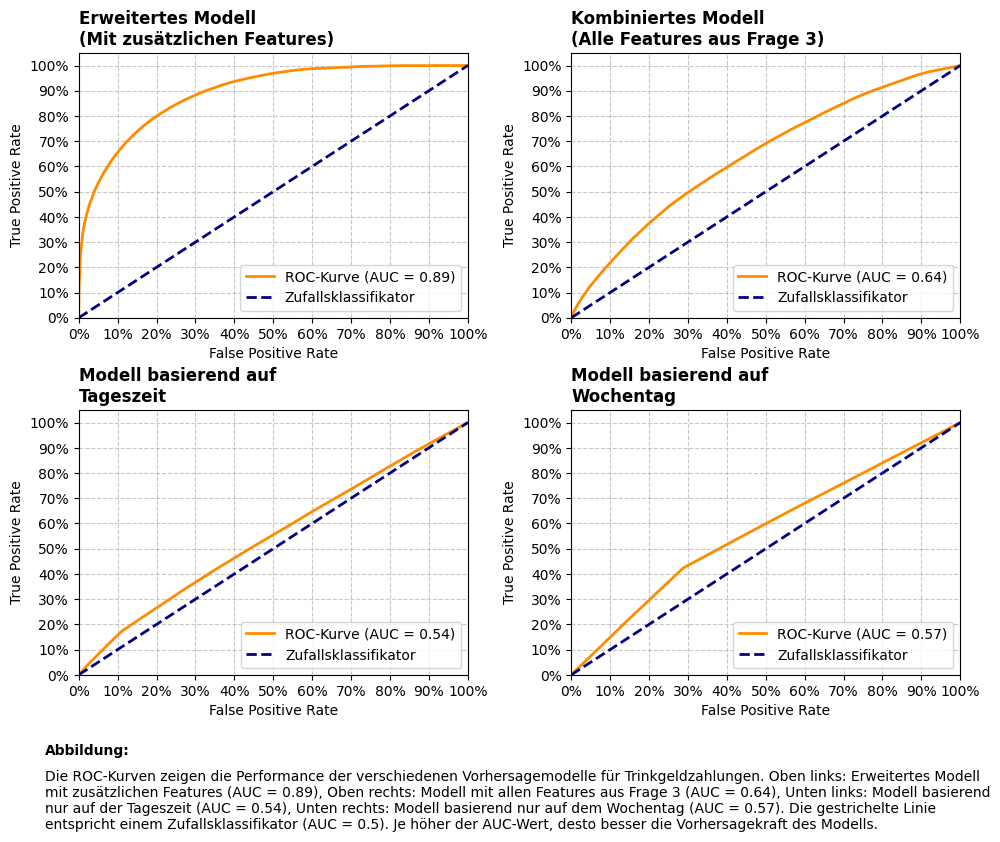

In [512]:
y_prob_enhanced = model.predict_proba(X_test)[:, 1]

# Berechnung der ROC-Kurve für das erweiterte Modell
fpr_enhanced, tpr_enhanced, _ = roc_curve(y_test, y_prob_enhanced)
roc_auc_enhanced = auc(fpr_enhanced, tpr_enhanced)

# Erstelle 2x2 Subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.subplots_adjust(left=0.08)

# Plot 1 (oben links): ROC-Kurve für erweitertes Modell
ax1.plot(fpr_enhanced, tpr_enhanced, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_enhanced:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Plot 2 (oben rechts): ROC-Kurve für alle bisherigen Features
ax2.plot(fpr_all, tpr_all, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_all:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Plot 3 (unten links): ROC-Kurve für Stunde des Tages
ax3.plot(fpr_hour, tpr_hour, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_hour:.2f})')
ax3.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Plot 4 (unten rechts): ROC-Kurve für Wochentag
ax4.plot(fpr_day, tpr_day, color='darkorange', lw=2, 
         label=f'ROC-Kurve (AUC = {roc_auc_day:.2f})')
ax4.plot([0, 1], [0, 1], color='navy', lw=2, 
         linestyle='--', label='Zufallsklassifikator')

# Formatierung für alle Subplots
for ax, title in zip([ax1, ax2, ax3, ax4], 
                    ['Erweitertes Modell\n(Mit zusätzlichen Features)',
                     'Kombiniertes Modell\n(Alle Features aus Frage 3)',
                     'Modell basierend auf\nTageszeit',
                     'Modell basierend auf\nWochentag']):
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title, loc='left', weight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='lower right')
    
    # Prozentuale Achsenbeschriftungen
    ax.set_xticks([i/10 for i in range(0, 11)])
    ax.set_yticks([i/10 for i in range(0, 11)])
    ax.set_xticklabels([f"{i*10}%" for i in range(0, 11)])
    ax.set_yticklabels([f"{i*10}%" for i in range(0, 11)])

# Bildunterschrift
description = ('Die ROC-Kurven zeigen die Performance der verschiedenen Vorhersagemodelle für Trinkgeldzahlungen. '
               'Oben links: Erweitertes Modell mit zusätzlichen Features (AUC = {:.2f}), '
               'Oben rechts: Modell mit allen Features aus Frage 3 (AUC = {:.2f}), '
               'Unten links: Modell basierend nur auf der Tageszeit (AUC = {:.2f}), '
               'Unten rechts: Modell basierend nur auf dem Wochentag (AUC = {:.2f}). '
               'Die gestrichelte Linie entspricht einem Zufallsklassifikator (AUC = 0.5). '
               'Je höher der AUC-Wert, desto besser die Vorhersagekraft des Modells.'.format(
                   roc_auc_enhanced, roc_auc_all, roc_auc_hour, roc_auc_day))

fig.text(0.05, 0.05, 'Abbildung:', weight='bold', ha='left')
fig.text(0.05, -0.04, description, wrap=True)

# Layout anpassen
plt.tight_layout()

# Zusätzlicher Platz für die Beschreibung
plt.subplots_adjust(bottom=0.15)

plt.show()